# Obligatorio: Curso Análisis Predictivo de Series Temporales

## Posgrado de Analítica de Big Data

## Universidad ORT Uruguay

### Curso 2021

**Integrantes:** 

 * Mauricio Martinez (134283)
 * Augusto Romero
 * Enrique Peirano (252190)

## Serie de consumo de Slots de una plataforma analítica de datos (Big Query)

Para este trabajo usaremos la serie temporal del uso de slots de un proyecto de Big Query. Big Query es un motor analítico de tipo SaaS que forma parte de las herramientas de Google Cloud Platform. Se trata de un servicio serverless que permite a las organizaciones administrarlo y controlar sus costos en base a distintos modelos de pricing.
El modelo que nos interesa analizar es el de los llamados "slots". En Big Query un "slot" es una unidad de procesamiento (similar a un cpu virtual). Las consultas analíticas que se realizan sobre la plataforma son procesadas por slots y éstos son asignados por la plataforma de acuerdo a la demanda, la disponibilidad y la complejidad de las consultas.
Nuestra serie de datos representa el uso de slots por intervalo de tiempo (medido en milisegundos de uso). Ejemplo: si en un intervalo de un segundo se registra un uso de 1500ms de slots podemos decir que se usaron 1.5 slots. Si bien esta es la unidad de medida original, para este trabajo decidimos realizar una modificación en el muestreo (los intervalos son de 5 minutos) y la unidad de medida es la cantidad de slots utilizados.


 * Tomamos el mes de mayo 2021
 
 * Los Slots se pueden comprar cada 5 minutos, por lo que decidimos trabajar con esa unidad de tiempo
 
 * t = 21 días hábiles * 288 (1 dia) = 6048 total 
 
 * Dividimos la serie entre Train y Test


In [1]:
# explicar lo de los 300000 

### Paquetes:

In [2]:
#install.packages('Metrics')
library('astsa')
library(forecast)
library('Metrics')

options(repr.plot.width=14, repr.plot.height=6)


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas



Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




In [3]:
setwd('./')
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_no_weekends_resampled.csv")

In [4]:
ts_df <- ts_df[,2]
#x = ts(ts_df, start=0 , frequency=1)
#x = x/300000 # paso la unidad a slots
ts_df = ts_df/300000 # paso la unidad a slots
ts_df = ts(ts_df, start=0, frequency=1)

In [5]:
# explicar mejor la conversión

In [6]:
length(ts_df)

[1] 6048

### La Serie

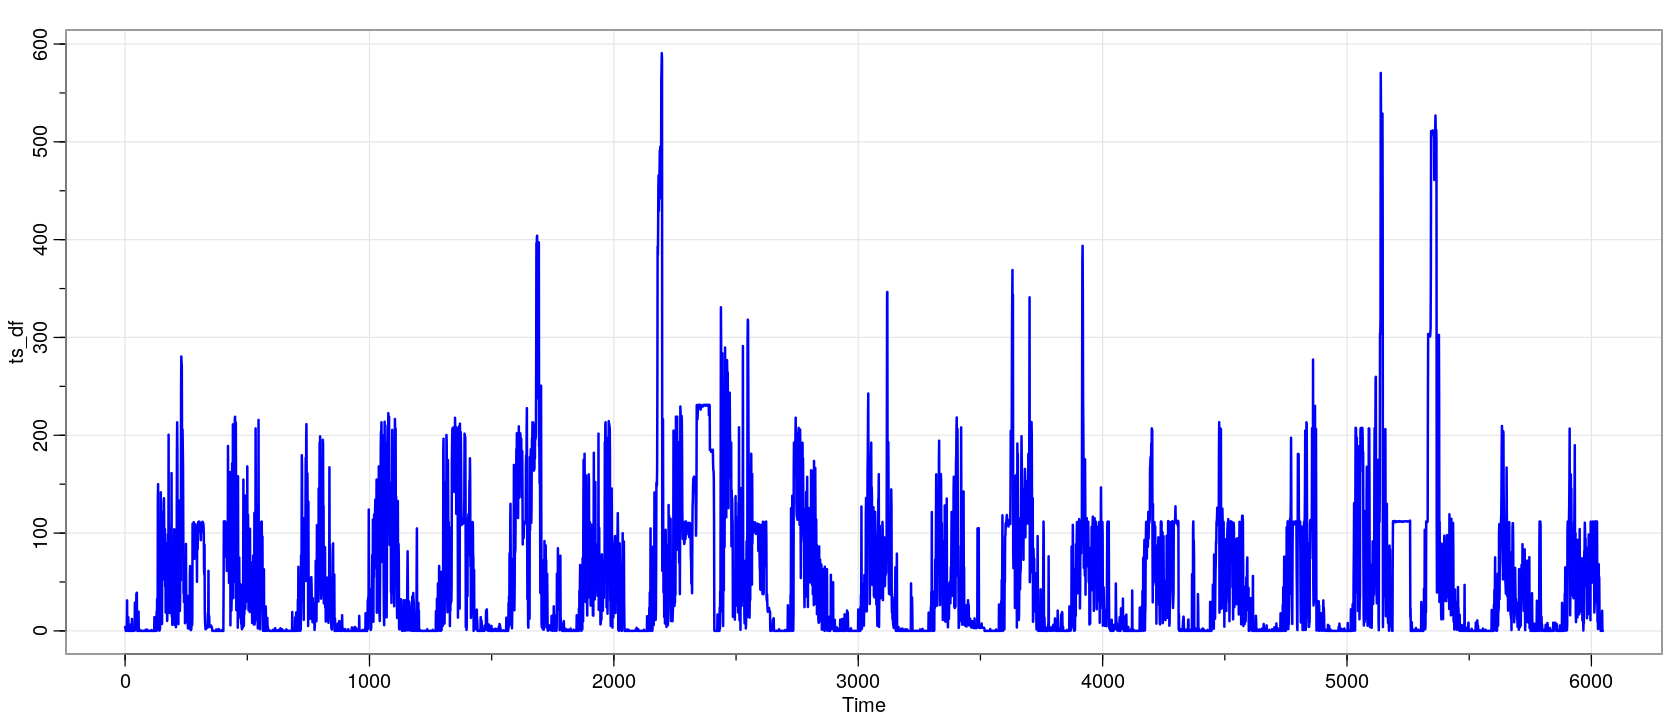

In [7]:
tsplot(ts_df, col=4, lwd=2)

In [8]:
# A simple vista se observan los períodos de uso de la plataforma, con un comportamiento relativamente similar 
# (con período de 288 observaciones).

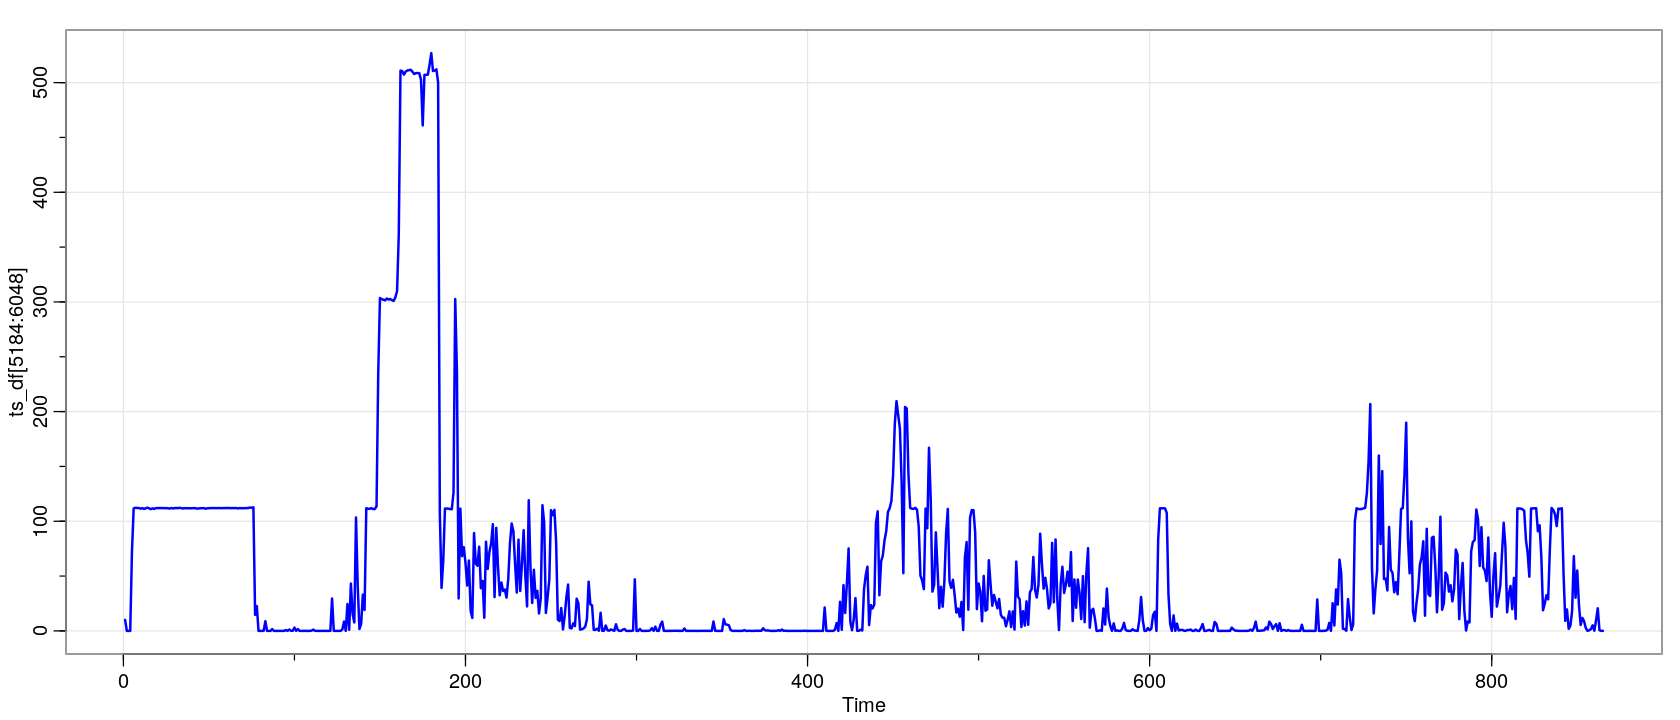

In [9]:
# Hacemos zoom para mostrar los últimos días que queremos predecir
tsplot(ts_df[5184:6048], col=4, lwd=2)

#### Particion Train-Test

In [10]:
# Definimos el tamaño del dataset para el ajuste
# start_test en 5184, usa 18 dias (5184/288) para ajustar y nos quedan 3 dias para predecir

In [11]:
start_train = 1
start_test = 5184 # 4392
time_series = ts_df

In [12]:
ret = c(0,0)

ts_length = length(time_series)        
end_train = start_test - 1

ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)

dn = ts_df_train
dnt = ts_df_test

In [13]:
# Transformamos a log   
# agrego para probar +1 para evitar log(0)
ldn = log(dn+1)
ldnt = log(dnt+1)
t = time(ldn)

In [14]:
print(head(t))

Time Series:
Start = 0 
End = 5 
Frequency = 1 
[1] 0 1 2 3 4 5


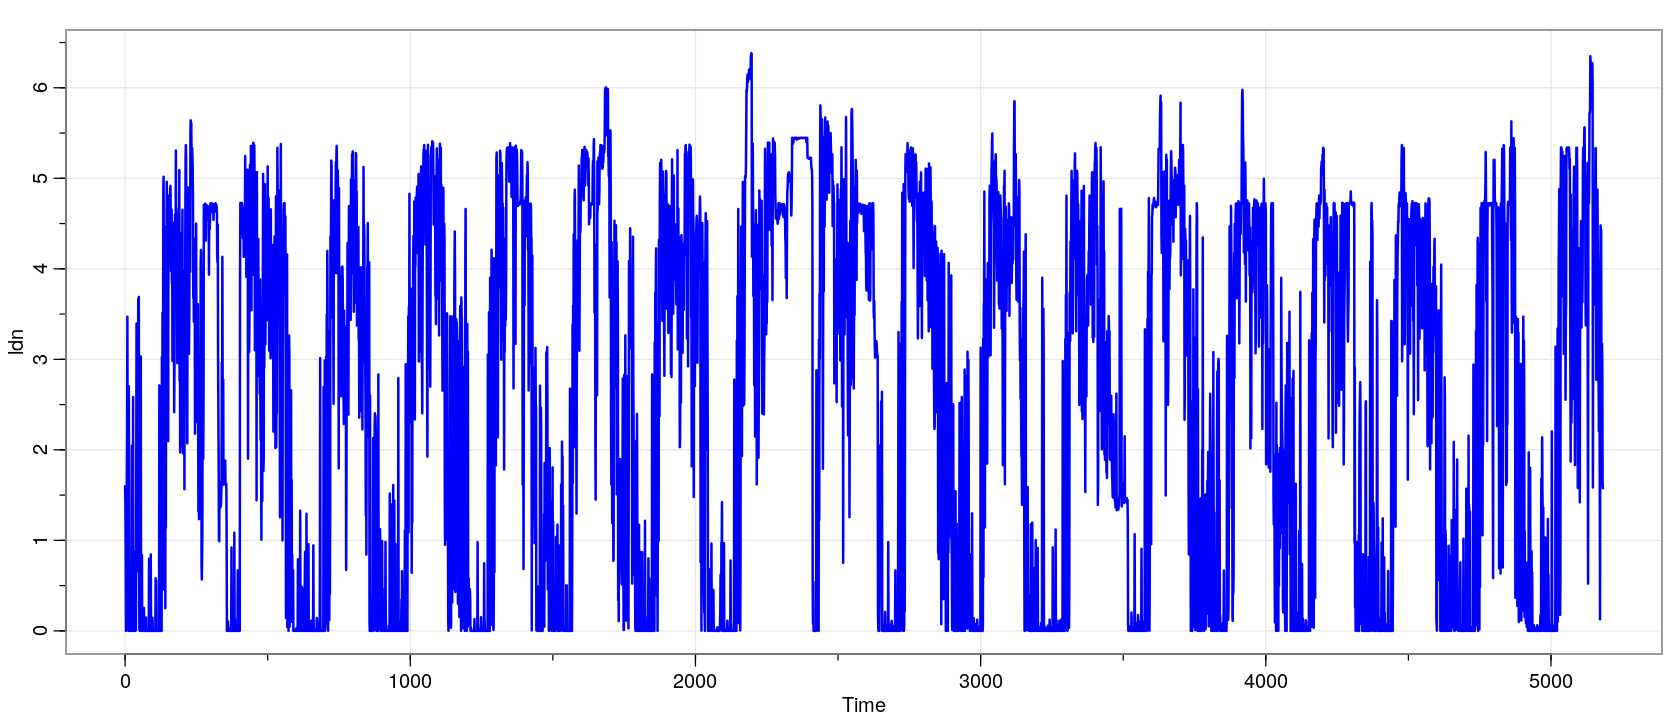

In [15]:
tsplot(ldn, col=4, lwd=2)

### Tendencia

In [16]:
fittrn = lm(ldn ~ t, na.action=NULL)

predicttrend = ts(fitted(fittrn), start=start_train-1, freq=1)

ldnc = ldn-predicttrend

ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)

In [17]:
summary(fittrn)


Call:
lm(formula = ldn ~ t, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6436 -2.4954  0.4345  1.9538  3.7952 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.545e+00  5.613e-02  45.332   <2e-16 ***
t           1.973e-05  1.876e-05   1.052    0.293    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.021 on 5181 degrees of freedom
Multiple R-squared:  0.0002134,	Adjusted R-squared:  2.045e-05 
F-statistic: 1.106 on 1 and 5181 DF,  p-value: 0.293


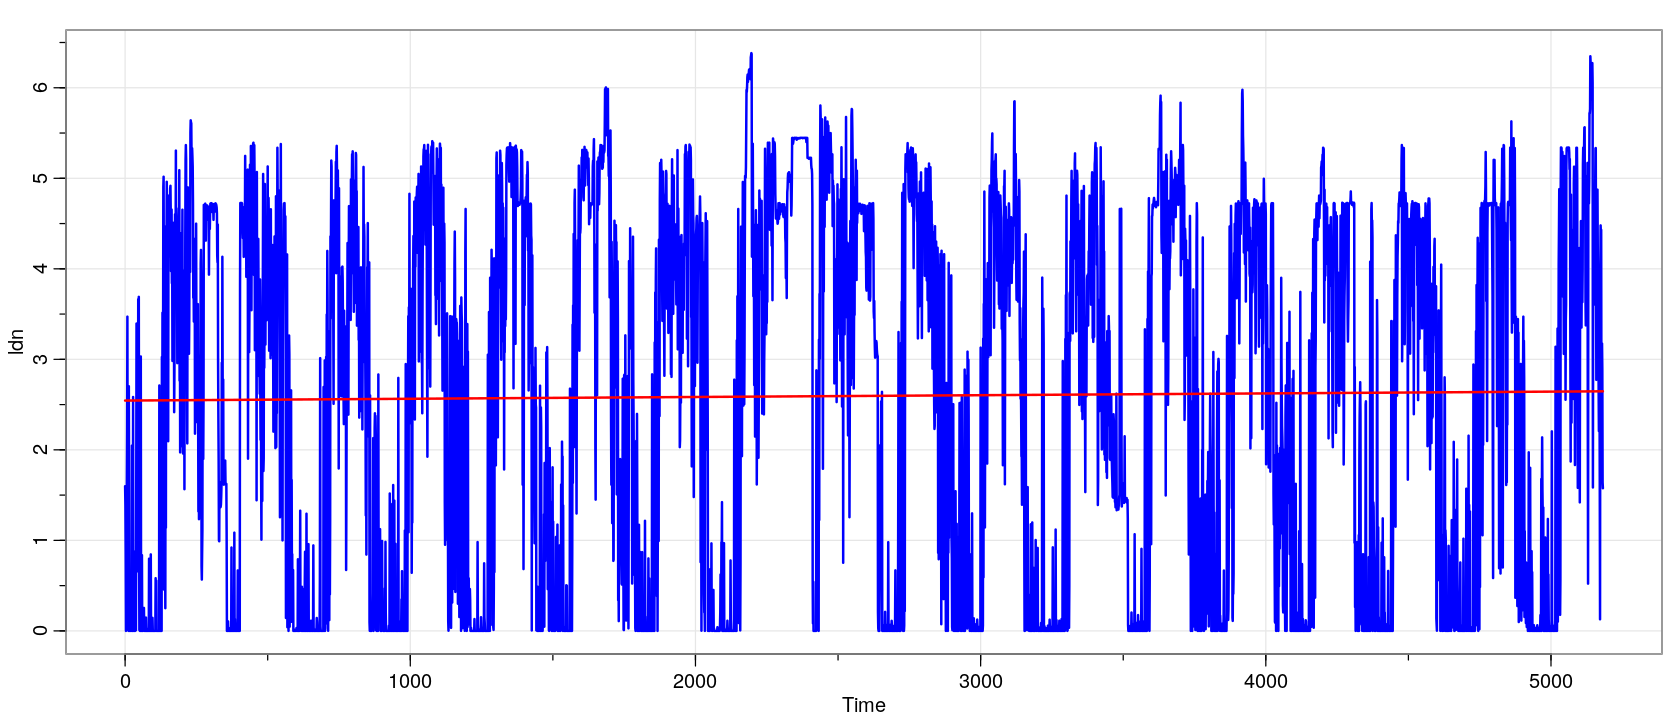

In [18]:
tsplot(ldn, col=4, lwd=2)
lines(predicttrend, col=2, lwd=2)

In [19]:
# tiene sentido que la tendencia sea creciente, por el hecho de que se van sumando usuarios a la plataforma
# pero no podemos afirmarlo con los datos de un mes

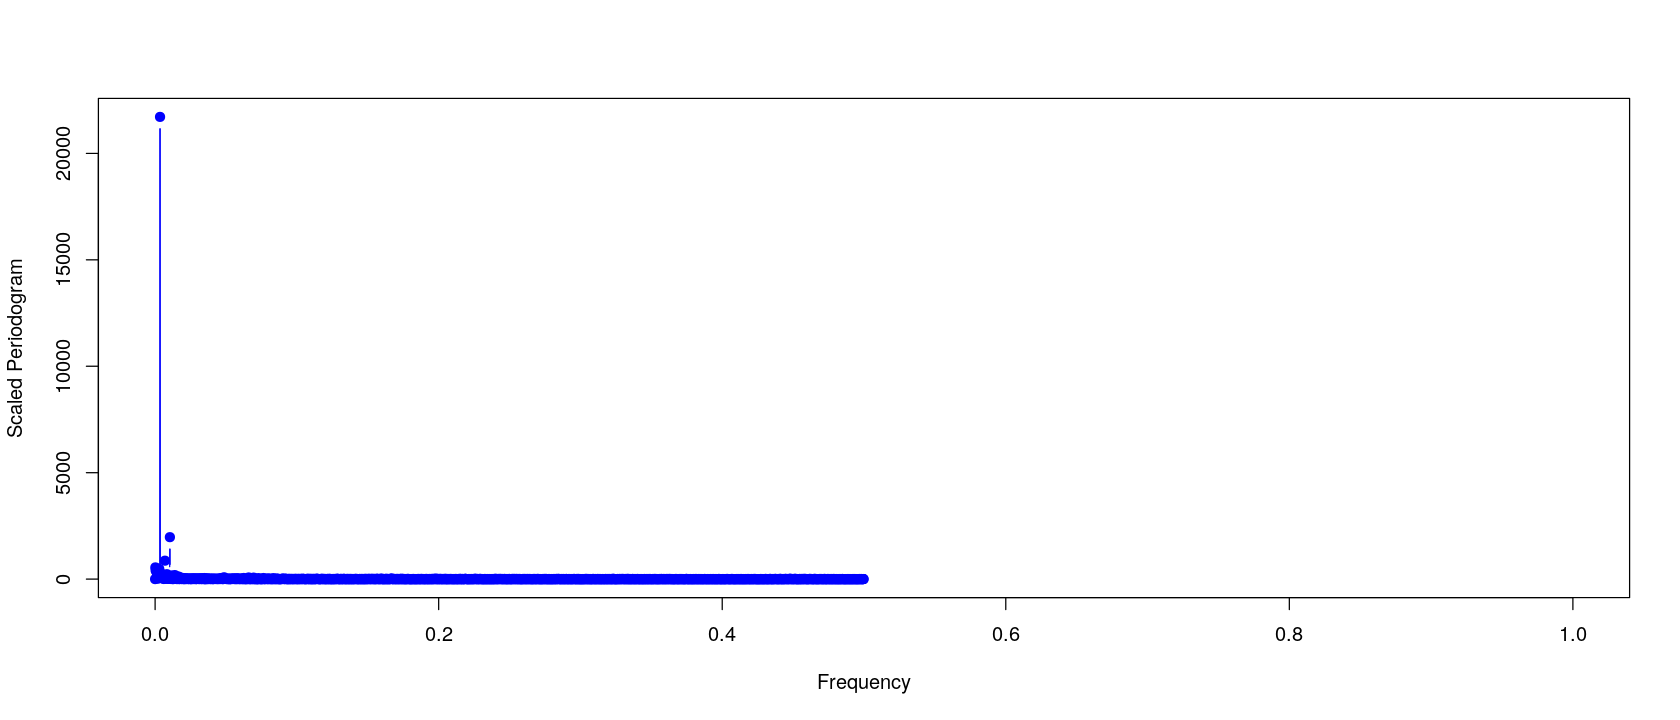

In [20]:
# Periodograma
n=length(ldnc)

P = 4/n*abs(fft(ldnc))^2 
P=P[1:floor(n/2)]#me quedo con las frecuencias posibles
f = (0:(n/2-1))/n 
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 1), col=4, lwd=1, pch=19)

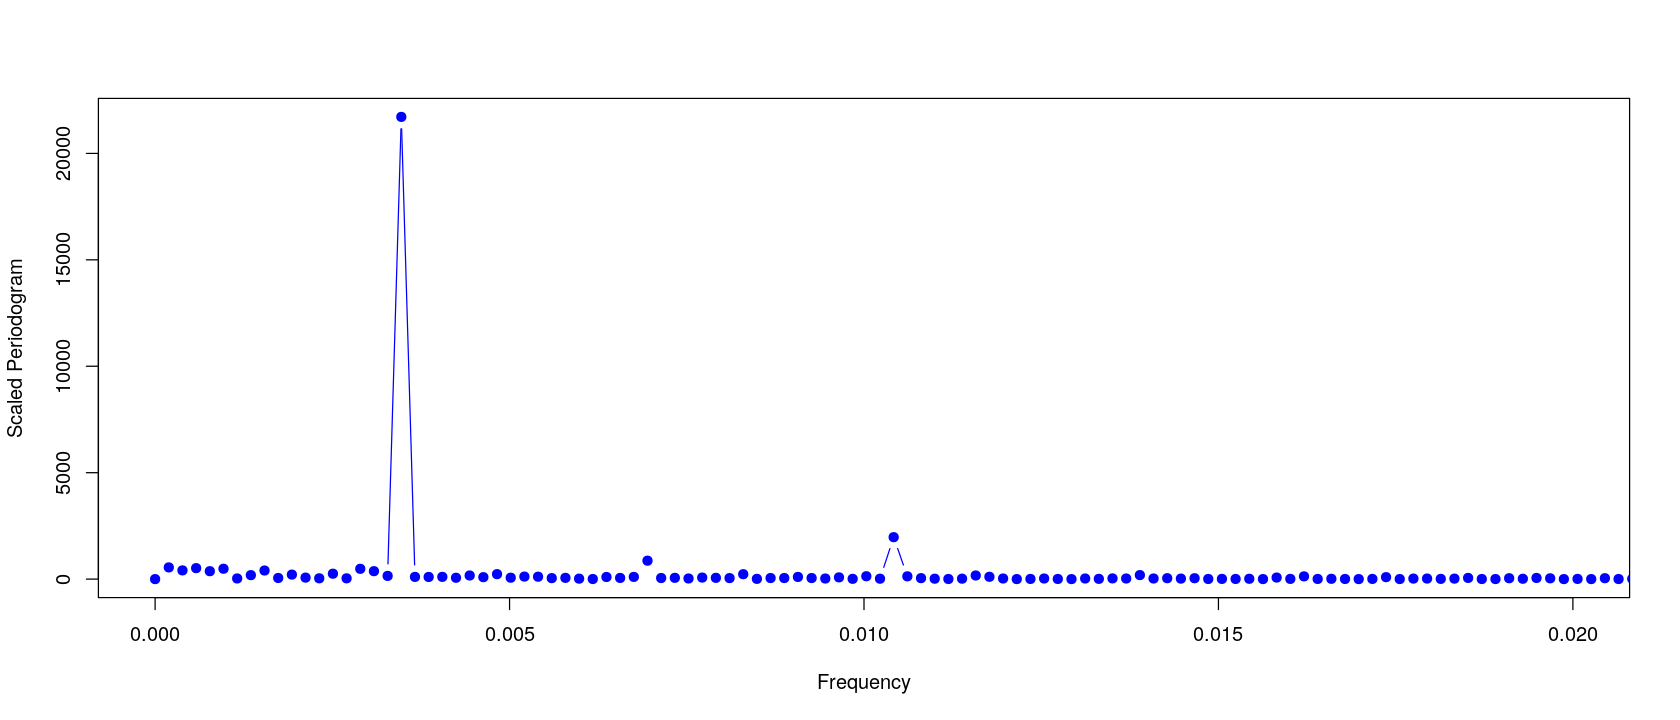

In [21]:
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.02), col=4, lwd=1, pch=19)

[1] "0.00347289214740498   21715.3315064483"
[1] "0.00694578429480996   866.084552524173"
[1] "0.0104186764422149   1970.71556742661"


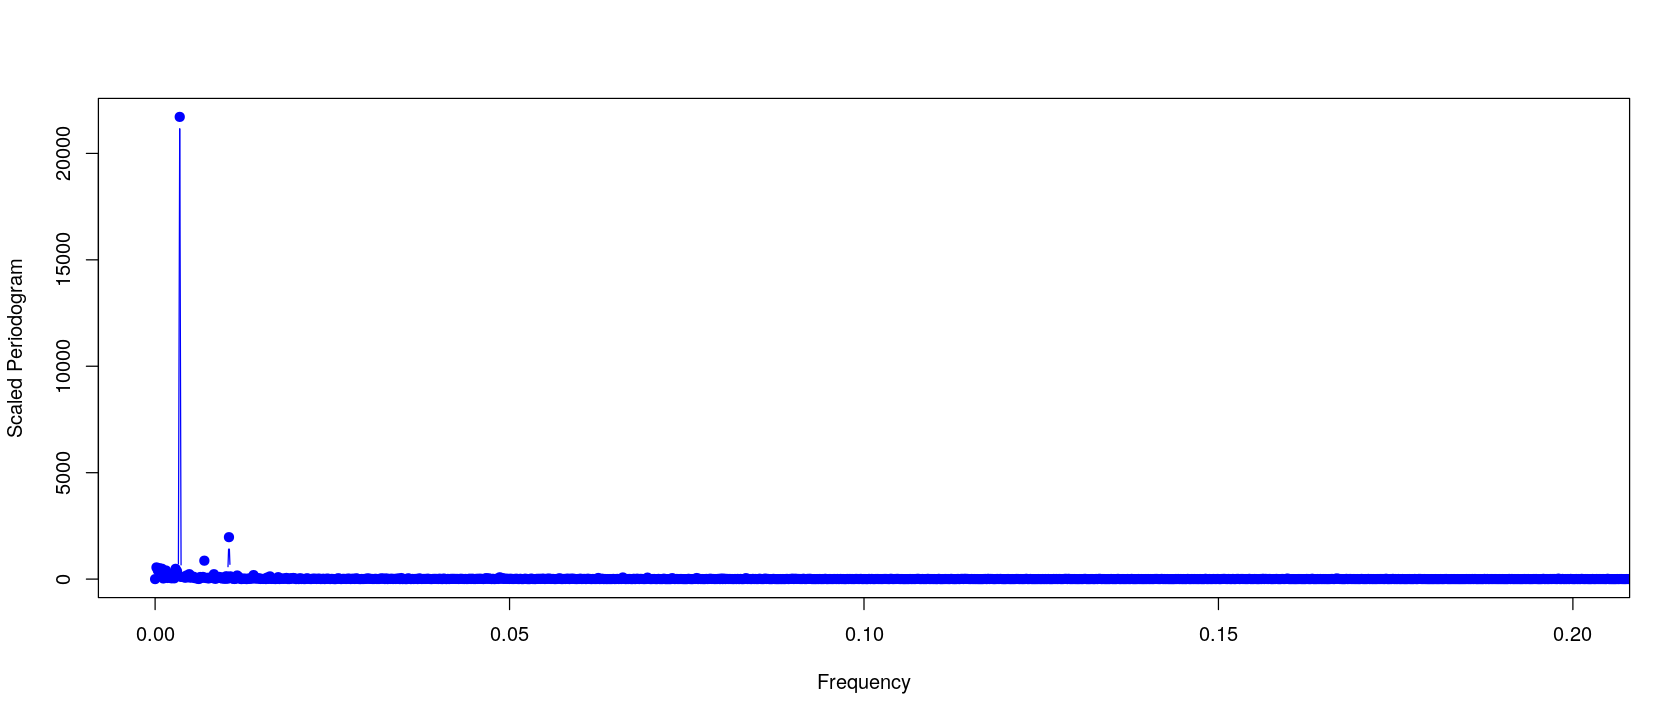

In [22]:
# imprimo de nuevo el periodograma de la serie original transformada
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.2), col=4, lwd=1, pch=19)

# me quedo con los valores de un umbral que defino a partir de las primeras observaciones del periodograma
# para elegir las frecuencias
# ajusto el limite de frecuencias a 0.2
P_thresh = 550 # umbral del eje y 
max_freq_idx = length(f)

for (i in (1:max_freq_idx)){
    if (P[i] > P_thresh & f[i] < .2) {
        print(paste(f[i], " " ,P[i]))
        }
}

In [23]:
t = time(ldnc) 


f1 = 0.003473
f2 = 0.006946
f3 = 0.010419

fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                    cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                    cos(2*pi*f3*t) + sin(2*pi*f3*t) ,
         na.action=NULL)

prediction = ts(fitted(fit), start=start_train-1, freq=1)

tn = start_test - 1 

res = (ts(residuals(fit), start=start_train -1, freq=1))

In [24]:
summary(fit)


Call:
lm(formula = ldnc ~ 0 + cos(2 * pi * f1 * t) + sin(2 * pi * f1 * 
    t) + cos(2 * pi * f2 * t) + sin(2 * pi * f2 * t) + cos(2 * 
    pi * f3 * t) + sin(2 * pi * f3 * t), na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7985 -0.8809 -0.0984  0.7018  5.2646 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
cos(2 * pi * f1 * t) -0.14528    0.02573  -5.646 1.73e-08 ***
sin(2 * pi * f1 * t) -2.04181    0.02573 -79.354  < 2e-16 ***
cos(2 * pi * f2 * t)  0.19837    0.02573   7.710 1.50e-14 ***
sin(2 * pi * f2 * t)  0.35731    0.02573  13.887  < 2e-16 ***
cos(2 * pi * f3 * t) -0.42589    0.02573 -16.552  < 2e-16 ***
sin(2 * pi * f3 * t) -0.44545    0.02573 -17.312  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.31 on 5177 degrees of freedom
Multiple R-squared:  0.5802,	Adjusted R-squared:  0.5797 
F-statistic:  1192 on 6 and 5177 DF,  p-value: < 2.2e-16


In [25]:
# encontramos todos los coeficientes de las frecuencias significativos, con las tres frecuencias que encontramos
# queda explicado el 58% de la varianza de la serie

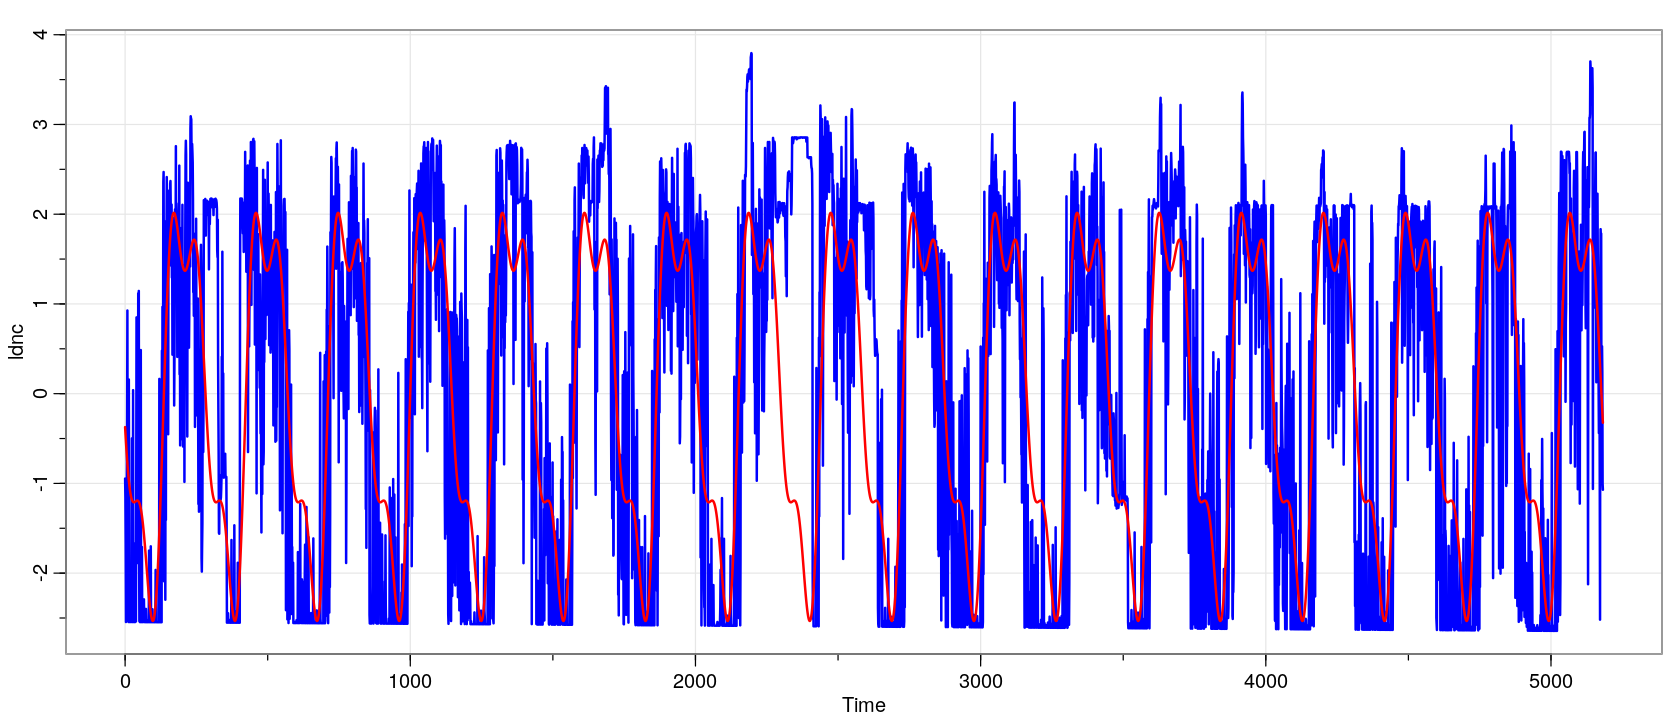

In [26]:
tsplot(ldnc, col=4, lwd=2)
lines(prediction, col=2, lwd=2)

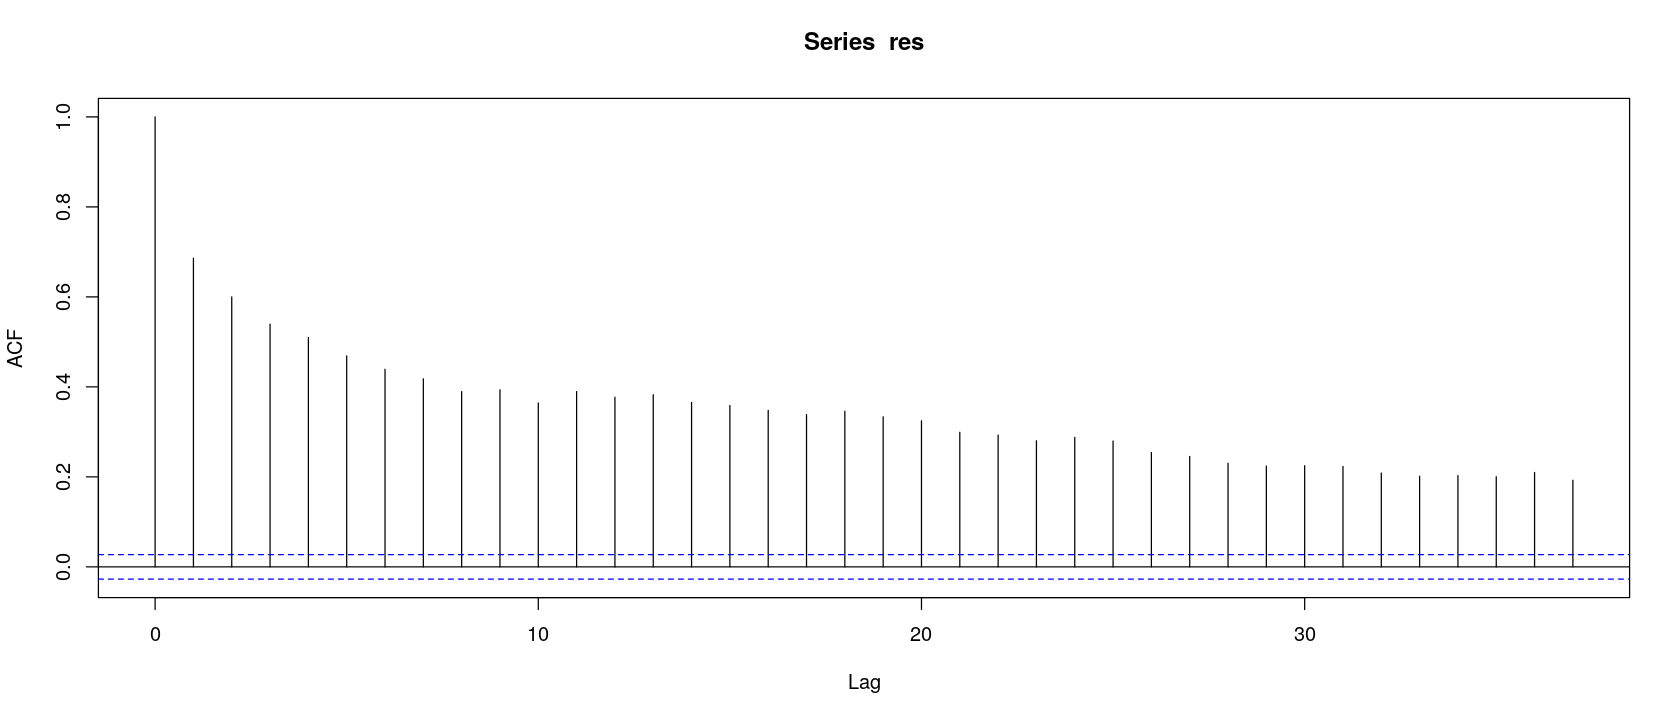

In [27]:
acf(res)

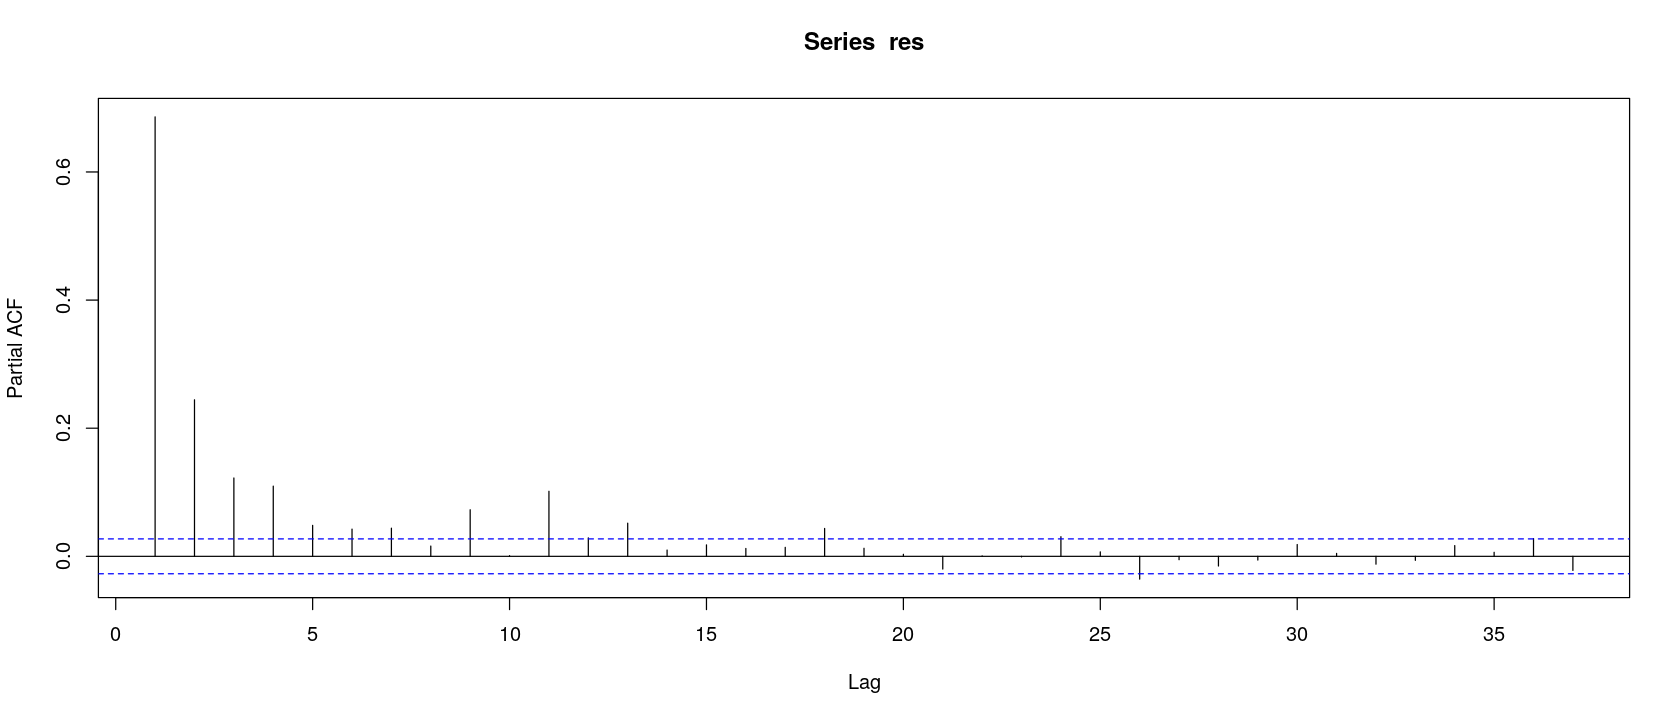

In [28]:
pacf(res)

In [29]:
# empezamos probando con un AR de órden 7, de acuerdo al resultado del acf y pacf de los residuos del ajuste de 
# las componentes periódicas
# vimos que acf decae exponencialmente y pacf corta en 7


Series: ldncr1 
ARIMA(7,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6     ar7
      0.4657  0.1528  0.0548  0.0773  0.0217  0.0222  0.0437
s.e.  0.0139  0.0153  0.0154  0.0154  0.0154  0.0153  0.0139

sigma^2 estimated as 0.8263:  log likelihood=-6856.72
AIC=13729.44   AICc=13729.46   BIC=13781.86

Training set error measures:
                       ME      RMSE       MAE      MPE     MAPE      MASE
Training set 7.512722e-06 0.9083735 0.6380347 54.74792 191.2064 0.9988393
                     ACF1
Training set -0.000578822

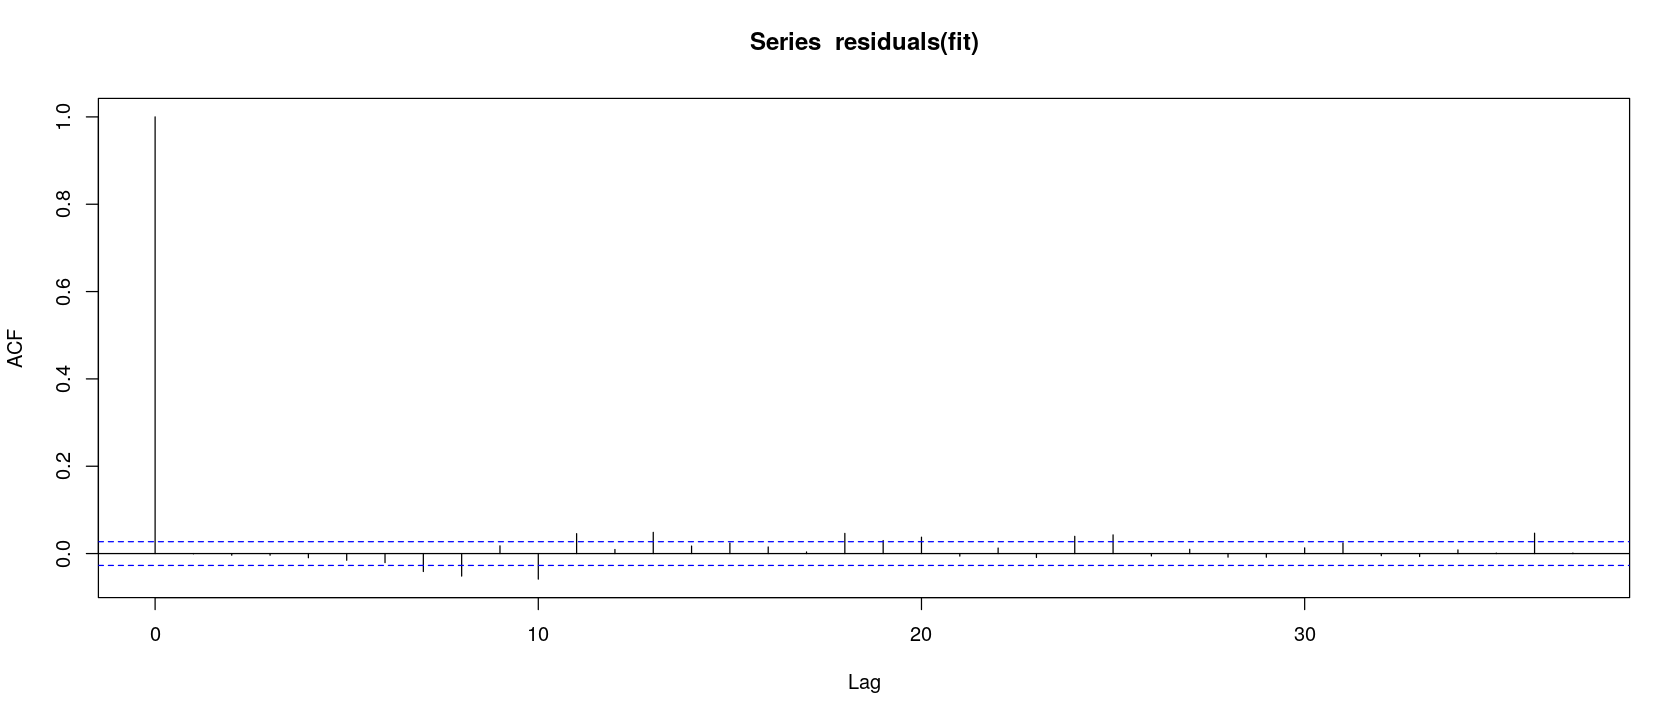

In [30]:
ldncr1 = res
        
fit = Arima(ldncr1, order = c(7,0,0), include.mean=FALSE)
summary(fit)
acf(residuals(fit))

In [31]:
# Obtuvimos 2 coeficientes no significativos, entonces probamos AR con órden 6, 5 y 4

Series: ldncr1 
ARIMA(6,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6
      0.4675  0.1541  0.0583  0.0799  0.0285  0.0427
s.e.  0.0139  0.0153  0.0154  0.0154  0.0153  0.0139

sigma^2 estimated as 0.8277:  log likelihood=-6861.67
AIC=13737.35   AICc=13737.37   BIC=13783.22

Training set error measures:
                        ME      RMSE       MAE      MPE   MAPE      MASE
Training set -1.947069e-05 0.9092436 0.6380043 59.32708 188.64 0.9987917
                     ACF1
Training set -0.001775459

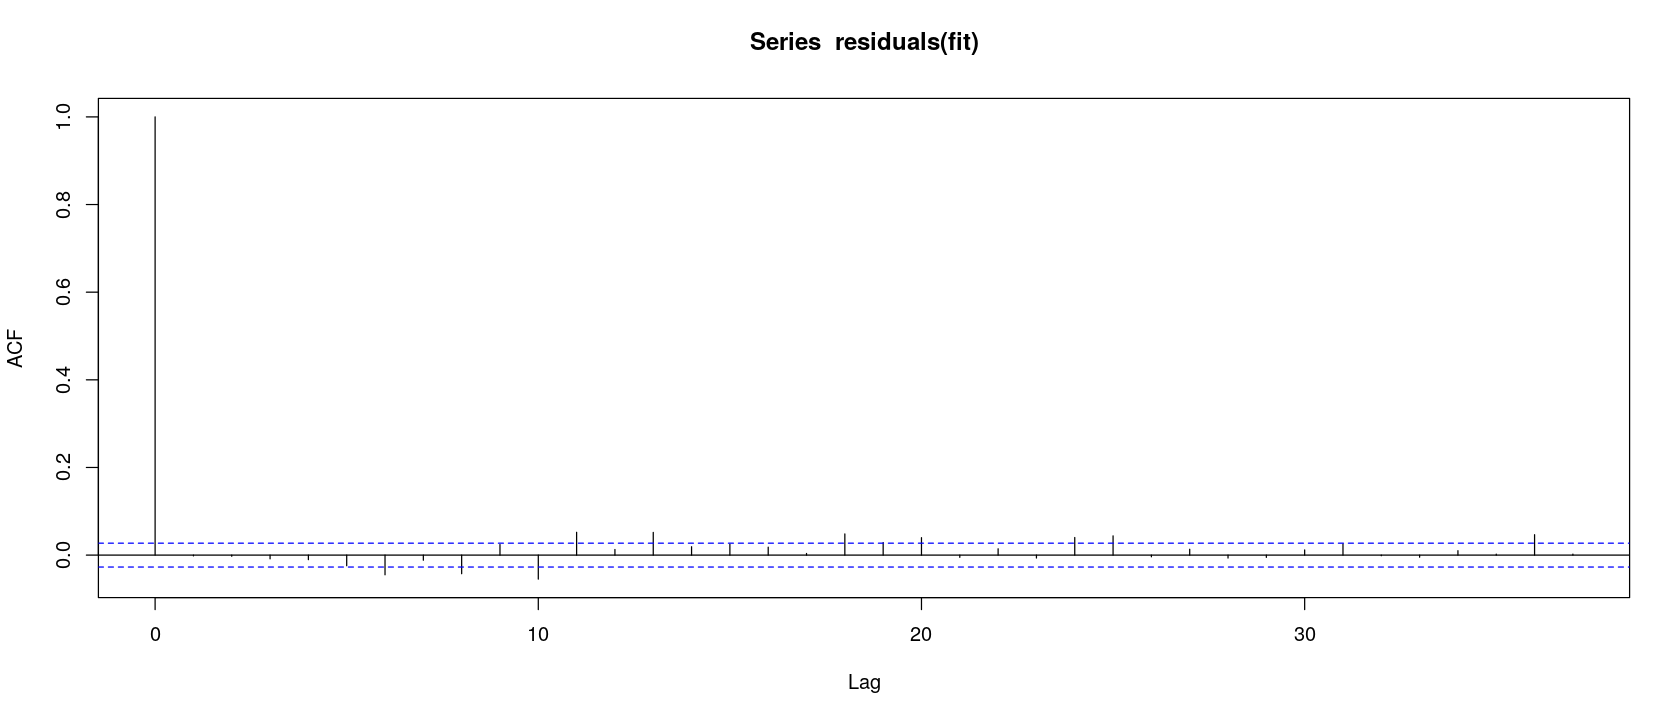

In [32]:
fit = Arima(ldncr1, order = c(6,0,0), include.mean=FALSE)
summary(fit)
acf(residuals(fit))

Series: ldncr1 
ARIMA(5,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5
      0.4696  0.1577  0.0609  0.0866  0.0485
s.e.  0.0139  0.0153  0.0154  0.0153  0.0139

sigma^2 estimated as 0.829:  log likelihood=-6866.4
AIC=13744.79   AICc=13744.81   BIC=13784.11

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -2.935708e-05 0.9100736 0.6385655 62.94482 186.7103 0.9996702
                     ACF1
Training set -0.001981949

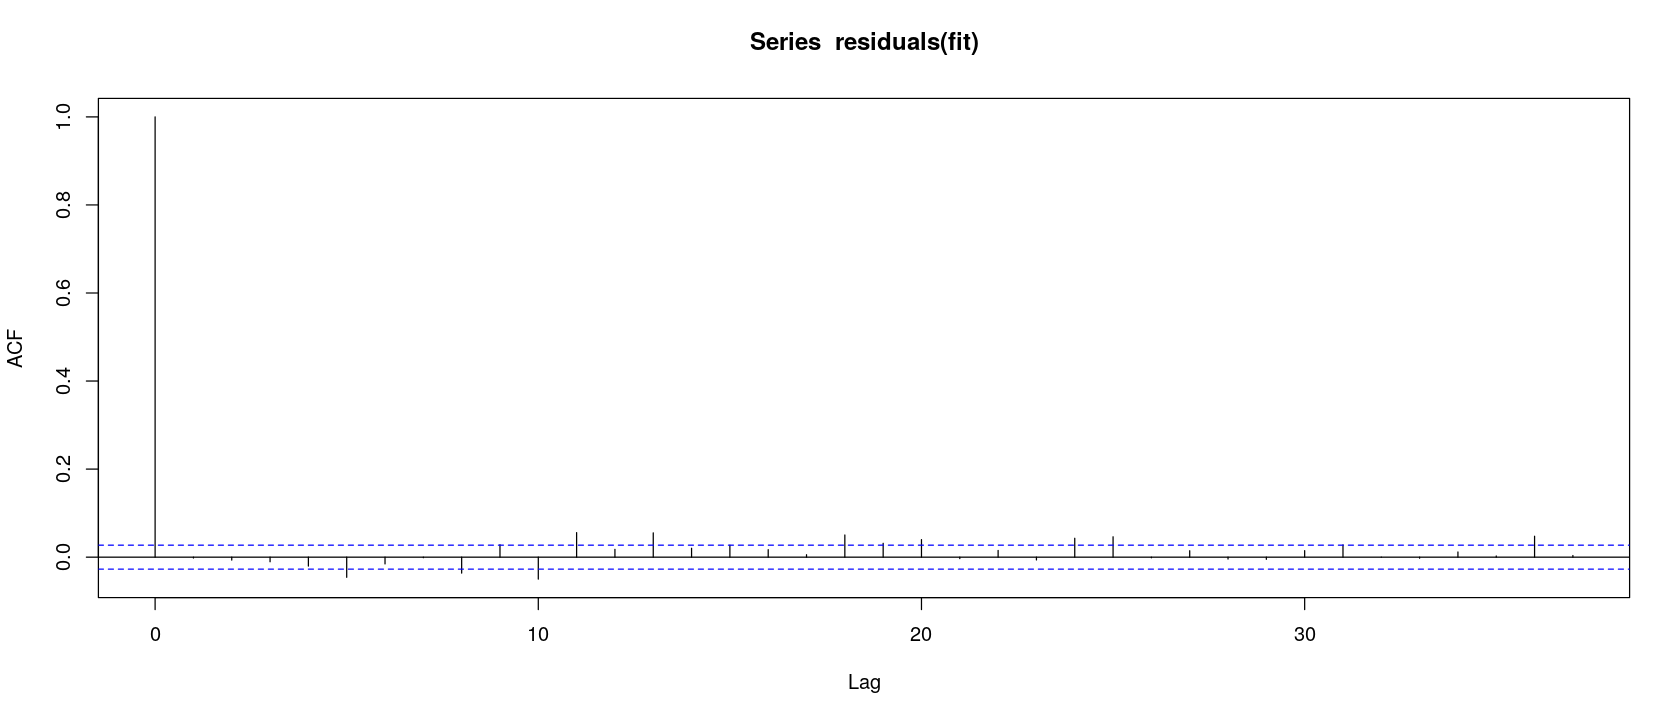

In [33]:
fit = Arima(ldncr1, order = c(5,0,0), include.mean=FALSE)
summary(fit)
acf(residuals(fit))

Series: ldncr1 
ARIMA(4,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4
      0.4749  0.1611  0.0687  0.1097
s.e.  0.0138  0.0153  0.0153  0.0138

sigma^2 estimated as 0.8308:  log likelihood=-6872.5
AIC=13755   AICc=13755.01   BIC=13787.77

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE     MASE
Training set -4.452313e-05 0.9111471 0.6388454 65.50802 183.8188 1.000108
                     ACF1
Training set -0.005232773

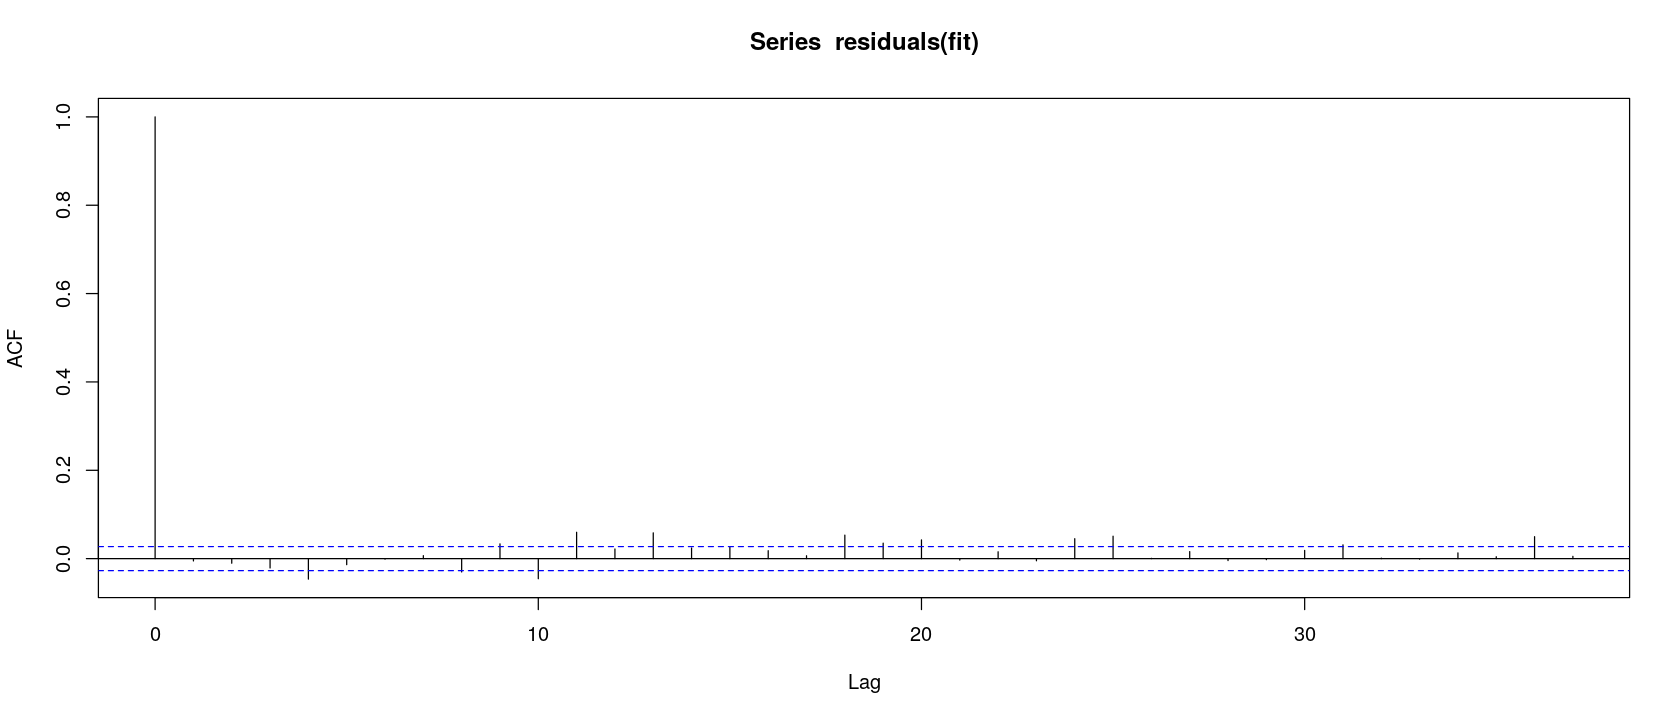

In [34]:
fit = Arima(ldncr1, order = c(4,0,0), include.mean=FALSE)
summary(fit)
acf(residuals(fit))

In [ ]:
# del ajuste de estos tres modelos ARs, observamos que el AR(5) performa mejor, tiene todos sus coeficientes
# significativos (el AR(6) tiene uno no significativo), poderamos el hecho de que todos los coeficientes sean 
# significativos a pesar de que el AIC devuelve un mejor resultado en el AR(6) 
# El AR(4) lo descartamos porque da un peor AIC respecto al AR(5)

In [ ]:
# Respecto al residuo que obtenemos del fit del AR(5), si bien tiene algunas autocorrelaciones en lags que
# sobresalen levemente del intervalo de confianza (con el criterio del 95% en 20 lags), 
# entendemos que el resultado tiende a ser ruido blanco
# De cualquier manera en la sección siguiente hacemos pruebas con otros modelos de los cuales si obtenemos ruido 
# blanco como residuo

In [ ]:
# En los ajustes que hicimos al inicio del trabajo sobre la serie que incluía los fines de semana encontramos
# en las autocorrelaciones componentes estacionales, por lo tanto hicimos pruebas con modelos ARMA con estacionalidad.

# Entre las pruebas mencionadas hicimos una búsqueda de parámetros por fuerza bruta. Lo que arrojó algunos modelos
# que llegamos a probar basándonos en principio en el criterio AIC. El ajuste y predicción de los modelos 
# encontrados (que también incluía ajustes con media movil) tomaba mucho tiempo de procesamiento, por lo tanto 
# no incluimos una prediccion de 3 días con los mismos.

# Del resultado de una búsqueda de parámetros por fuerza bruta que hicimos sobre ambas series (con y sin fines de
# semana), encontramos algunos juegos de parámetros que entendimos que valía la pena evaluar como lo hacemos 
# a continuación.


In [ ]:
# El modelo que mejor AIC tiene del resultado de la búsqueda es el ARMA(606)(601)[6]
# Mostramos un ajuste en la siguiente celda:

In [ ]:
ldncr1 = res
        
fit = Arima(ldncr1, order = c(6,0,6), seasonal = list(order = c(6,0,1), period = 6), include.mean=FALSE)
summary(fit)
acf(residuals(fit))

In [ ]:
# En la búsqueda tambien encontramos un ARMA(4,6)
# Mostramos el ajuste en la siguiente celda:

In [ ]:
fit = Arima(ldncr1, order = c(4,0,6), include.mean=FALSE)
summary(fit)
acf(residuals(fit))

In [ ]:
# En estos modelos mas complejos podemos observar que los residuos son ruido blanco (todas las autocorrelaciones
# se ubican dentro del intervalo de confianza).

# En contraposición a los modelos autorregresivos puros, encontramos que los que incluyen media móvil son 
# mas caros en términos de procesamiento de ajustar y de obtener las predicciones. Vamos a incluir
# una predicción de tres días para el modelo ARMA(4,0,6)



In [ ]:
# Los ajustes que obtenemos a partir de estos modelos que encontramos con la búsquedas por fuerza bruta
# tienen mejores AIC y sigma^2 respecto al AR(5). 
# Recordar que el sigma^2 representa la varianza del ruido blanco, por lo tanto es algo que buscamos minimizar.

### Predicción próximos 3 días

In [35]:
# generamos una función de ajuste y predicción 

fit_predict <- function(start_train, start_test, time_series) {
    
    ret = c(0,0)
    
    ts_length = length(time_series)        
    
    end_train = start_test - 1

    ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
    ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)
    
    dn = ts_df_train
    dnt = ts_df_test
    
    # nuevos datos para prediccion 
    new_t = seq(start_test-1,start_test-1,by=1)
    new_t = ts(new_t,start=start_test-1,freq=1)
    new_data = data.frame(t=new_t)
    
    # agrego para probar +1 para evitar log(0)
    ldn = log(dn+1)
    ldnt = log(dnt+1)
    t = time(ldn)
    
    fit = lm(ldn ~ t, na.action=NULL)
    
    ndata <- data.frame(t = new_data)
    
    predict_trend = predict(fit,newdata=ndata)
    
    predicttrend = ts(fitted(fit), start=start_train-1, freq=1)
    
    ldnc = ldn-predicttrend
    ###
    ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)
    ### 
    
    t = time(ldnc)
    
    f1 =  0.003473
    f2 =  0.006946
    f3 =  0.010419

    fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                      cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                     cos(2*pi*f3*t) + sin(2*pi*f3*t) ,
             na.action=NULL)
    
    prediction = ts(fitted(fit), start=start_train-1, freq=1)
    
    #tn = ts_length
    tn = start_test - 1 
            
#    v = 0 + cos(2*pi*f1*tn) + sin(2*pi*f1*tn) +
#                  cos(2*pi*f2*tn) + sin(2*pi*f2*tn) +
#                 cos(2*pi*f3*tn) + sin(2*pi*f3*tn)

    #vdf <- data.frame(t = v)
    
    vdf <- data.frame(t = new_data)
    fore_f = predict(fit, vdf)    

    res = (ts(residuals(fit), start=start_train -1, freq=1))

    ldncr1 = res
        
    fit = Arima(ldncr1, order = c(5,0,0), include.mean=FALSE)
    #fit = Arima(ldncr1, order = c(4,0,6), include.mean=FALSE)
    
    fore = forecast(fit, h=1)   
    
    ldnt = as.numeric(ldnt)

    ldnt = ts(ldnt, start=start_test -1, frequency=1)    
    
    v_ldnt = ldnt 
    v_pred = fore$mean + fore_f + predict_trend    
    
    v_ldnt = (exp(v_ldnt)) -1 
    v_pred = (exp(v_pred)) -1 
    
    v_ldnt[1:5]
    v_pred[1:5]
    ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1],fore$mean,fore_f,predict_trend)
    
    return(ret)
    
}

In [36]:

df_validation <- data.frame(observed=double(), predicted=double(), timeo=integer(), timep=integer())

vect_obs <- c()
vect_pred <- c()

vect_arma <- c()
#vect_freq <- c()
#vect_tren <- c()
#vect_tren_freq <- c()

for (i in (5184:6048)) {   
    print(i)
    #print(paste0("parametros: ", i-5180, " ", i))
    testv <- fit_predict(i-3550, i, ts_df)
    print(testv)
    vect_obs <- append(vect_obs, testv[1])
    vect_pred <- append(vect_pred, testv[2])
#    vect_arma <- append(vect_arma, testv[5])
#    vect_freq <- append(vect_freq, testv[6])
#    vect_tren <- append(vect_tren, testv[7])
#    vect_tren_freq <- append(vect_tren_freq, testv[6]+testv[7])  
    
    #print(testv)
    df_validation[nrow(df_validation)+1,] = testv
}

[1] 5184
                      1                                               1 
  10.024913    5.154535 5183.000000 5183.000000   -0.153582   -0.338479 
          1 
   2.309250 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5185
                        1                                                   1 
   0.0384400    7.4314935 5184.0000000 5184.0000000    0.2242246   -0.4022948 
           1 
   2.3100441 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5186
                          1                                           
 5.016667e-03  1.609327e+00  5.185000e+03  5.185000e+03 -8.807349e-01 
            1             1 
-4.683383e-01  2.308166e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5187
                        1                                                   1 
   0.0231700    0.7880825 5186.0000000 5186.0000000   -1.1925723   -0.5325487 
           1 
   2.3062649 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5188
                        1                                                   1 
  72.2856433    0.6351954 5187.0000000 5187.0000000   -1.2179154   -0.5947055 
           1 
   2.3043832 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5189
                        1                                                   1 
 111.7091900   10.8134987 5188.0000000 5188.0000000    0.8094751   -0.6475459 
           1 
   2.3073136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5190
                        1                                                   1 
 112.2612533   22.0259428 5189.0000000 5189.0000000    1.5233119   -0.6974266 
           1 
   2.3107362 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5191
                        1                                                   1 
 112.1178467   30.2093759 5190.0000000 5190.0000000    1.8715308   -0.7449737 
           1 
   2.3141614 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5192
                        1                                                   1 
 112.0400633   42.8000114 5191.0000000 5191.0000000    2.2519325   -0.7901182 
           1 
   2.3178198 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5193
                        1                                                   1 
 111.4374967   56.0608761 5192.0000000 5192.0000000    2.5554019   -0.8327946 
           1 
   2.3215114 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5194
                        1                                                   1 
 111.9800500   57.1773498 5193.0000000 5193.0000000    2.6114386   -0.8729535 
           1 
   2.3250110 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5195
                        1                                                   1 
 111.2495167   57.2353760 5194.0000000 5194.0000000    2.6462462   -0.9105279 
           1 
   2.3287747 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5196
                        1                                                   1 
 111.7767600   57.0828053 5195.0000000 5195.0000000    2.6747825   -0.9455061 
           1 
   2.3325933 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5197
                        1                                                   1 
 112.3678267   57.2635929 5196.0000000 5196.0000000    2.7067340   -0.9778466 
           1 
   2.3360901 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5198
                      1                                               1 
 111.781473   57.477905 5197.000000 5197.000000    2.737341   -1.007532 
          1 
   2.338839 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5199
                      1                                               1 
 111.005633   57.451318 5198.000000 5198.000000    2.761064   -1.034567 
          1 
   2.341697 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5200
                      1                                               1 
 111.706627   57.441775 5199.000000 5199.000000    2.782145   -1.058971 
          1 
   2.344857 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5201
                      1                                               1 
 111.264197   57.682506 5200.000000 5200.000000    2.806132   -1.080753 
          1 
   2.346763 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5202
                      1                                               1 
 111.957293   57.660461 5201.000000 5201.000000    2.823380   -1.099948 
          1 
   2.348334 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5203
                      1                                               1 
 112.011300   57.978975 5202.000000 5202.000000    2.842363   -1.116581 
          1 
   2.351400 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5204
                      1                                               1 
 112.017720   58.250324 5203.000000 5203.000000    2.858209   -1.130751 
          1 
   2.354314 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5205
                      1                                               1 
 112.003947   58.513980 5204.000000 5204.000000    2.871682   -1.142525 
          1 
   2.357054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5206
                      1                                               1 
 111.977190   58.782555 5205.000000 5205.000000    2.882601   -1.151980 
          1 
   2.360092 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5207
                      1                                               1 
 111.945190   59.149431 5206.000000 5206.000000    2.893727   -1.159213 
          1 
   2.362317 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5208
                      1                                               1 
 111.966773   59.421432 5207.000000 5207.000000    2.899655   -1.164308 
          1 
   2.365997 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5209
                      1                                               1 
 111.807650   59.738734 5208.000000 5208.000000    2.904609   -1.167400 
          1 
   2.369372 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5210
                      1                                               1 
 111.538163   60.011362 5209.000000 5209.000000    2.906699   -1.168601 
          1 
   2.372962 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5211
                      1                                               1 
 112.023600   60.245604 5210.000000 5210.000000    2.906306   -1.168039 
          1 
   2.376625 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5212
                      1                                               1 
 111.656463   60.678143 5211.000000 5211.000000    2.907434   -1.165836 
          1 
   2.380331 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5213
                      1                                               1 
 111.997350   60.923463 5212.000000 5212.000000    2.904010   -1.162141 
          1 
   2.384030 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5214
                      1                                               1 
 111.997157   61.331826 5213.000000 5213.000000    2.902114   -1.157086 
          1 
   2.387445 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5215
                      1                                               1 
 112.004130   61.706073 5214.000000 5214.000000    2.898353   -1.150822 
          1 
   2.390927 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5216
                      1                                               1 
 112.241110   62.052742 5215.000000 5215.000000    2.892866   -1.143503 
          1 
   2.394608 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5217
                      1                                               1 
 111.831763   62.448012 5216.000000 5216.000000    2.887156   -1.135285 
          1 
   2.398350 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5218
                      1                                               1 
 111.637533   62.681124 5217.000000 5217.000000    2.878144   -1.126341 
          1 
   2.402085 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5219
                      1                                               1 
 111.969667   62.904990 5218.000000 5218.000000    2.868361   -1.116830 
          1 
   2.405866 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5220
                      1                                               1 
 111.783217   63.277321 5219.000000 5219.000000    2.860516   -1.106909 
          1 
   2.409600 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5221
                      1                                               1 
 111.951437   63.517250 5220.000000 5220.000000    2.850359   -1.096750 
          1 
   2.413323 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5222
                      1                                               1 
 111.733187   63.801766 5221.000000 5221.000000    2.840738   -1.086513 
          1 
   2.417108 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5223
                      1                                               1 
 111.857370   64.000859 5222.000000 5222.000000    2.829944   -1.076370 
          1 
   2.420827 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5224
                      1                                               1 
 111.956187   64.251368 5223.000000 5223.000000    2.820150   -1.066479 
          1 
   2.424576 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5225
                      1                                               1 
 111.956000   64.494340 5224.000000 5224.000000    2.810750   -1.057001 
          1 
   2.428214 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5226
                      1                                               1 
 111.512567   64.680790 5225.000000 5225.000000    2.800926   -1.048094 
          1 
   2.431974 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5227
                      1                                               1 
 111.695367   64.713165 5226.000000 5226.000000    2.789606   -1.039921 
          1 
   2.435615 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5228
                      1                                               1 
 111.820777   64.865563 5227.000000 5227.000000    2.780851   -1.032622 
          1 
   2.439387 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5229
                      1                                               1 
 111.912883   65.013504 5228.000000 5228.000000    2.773137   -1.026344 
          1 
   2.443067 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5230
                      1                                               1 
 111.963120   65.116600 5229.000000 5229.000000    2.765797   -1.021225 
          1 
   2.446847 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5231
                      1                                               1 
 111.421820   65.173377 5230.000000 5230.000000    2.759090   -1.017398 
          1 
   2.450586 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5232
                      1                                               1 
 111.814530   65.058871 5231.000000 5231.000000    2.751220   -1.014998 
          1 
   2.454325 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5233
                      1                                               1 
 111.903503   65.144556 5232.000000 5232.000000    2.747890   -1.014127 
          1 
   2.458080 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5234
                      1                                               1 
 111.947290   65.158512 5233.000000 5233.000000    2.744958   -1.014897 
          1 
   2.461993 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5235
                      1                                               1 
 112.005000   65.084134 5234.000000 5234.000000    2.742210   -1.017411 
          1 
   2.466130 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5236
                      1                                               1 
 112.003787   64.994668 5235.000000 5235.000000    2.741094   -1.021761 
          1 
   2.470242 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5237
                      1                                               1 
 111.967337   64.871300 5236.000000 5236.000000    2.741341   -1.028026 
          1 
   2.474388 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5238
                      1                                               1 
 111.975787   64.679539 5237.000000 5237.000000    2.742525   -1.036275 
          1 
   2.478537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5239
                      1                                               1 
 112.007617   64.496685 5238.000000 5238.000000    2.746173   -1.046563 
          1 
   2.482389 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5240
                      1                                               1 
 111.910653   64.302057 5239.000000 5239.000000    2.751703   -1.058931 
          1 
   2.486252 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5241
                      1                                               1 
 111.990293   64.038074 5240.000000 5240.000000    2.758161   -1.073417 
          1 
   2.490228 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5242
                      1                                               1 
 112.008550   63.778567 5241.000000 5241.000000    2.766675   -1.090040 
          1 
   2.494340 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5243
                      1                                               1 
 111.996137   63.484918 5242.000000 5242.000000    2.776766   -1.108817 
          1 
   2.498482 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5244
                      1                                               1 
 112.077520   63.166641 5243.000000 5243.000000    2.788607   -1.129744 
          1 
   2.502620 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5245
                      1                                               1 
 112.009943   62.833422 5244.000000 5244.000000    2.802318   -1.152806 
          1 
   2.506765 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5246
                      1                                               1 
 111.936703   62.476641 5245.000000 5245.000000    2.818159   -1.177980 
          1 
   2.510492 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5247
                      1                                               1 
 111.977190   62.087578 5246.000000 5246.000000    2.835526   -1.205219 
          1 
   2.514216 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5248
                      1                                               1 
 112.009117   61.721908 5247.000000 5247.000000    2.855364   -1.234472 
          1 
   2.517819 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5249
                      1                                               1 
 112.010850   61.340921 5248.000000 5248.000000    2.876811   -1.265676 
          1 
   2.521483 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5250
                      1                                               1 
 111.681393   60.936584 5249.000000 5249.000000    2.899821   -1.298758 
          1 
   2.525048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5251
                      1                                               1 
 111.989620   60.465469 5250.000000 5250.000000    2.924221   -1.333638 
          1 
   2.527892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5252
                      1                                               1 
 111.868710   60.134400 5251.000000 5251.000000    2.951771   -1.370197 
          1 
   2.531501 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5253
                      1                                               1 
 111.887417   59.720254 5252.000000 5252.000000    2.979278   -1.408349 
          1 
   2.535349 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5254
                      1                                               1 
 111.912903   59.340603 5253.000000 5253.000000    3.008748   -1.447977 
          1 
   2.539234 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5255
                      1                                               1 
 111.974383   59.091750 5254.000000 5254.000000    3.042098   -1.488952 
          1 
   2.542727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5256
                      1                                               1 
 112.028107   58.704155 5255.000000 5255.000000    3.075728   -1.531131 
          1 
   2.544805 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5257
                      1                                               1 
 112.578530   58.268379 5256.000000 5256.000000    3.109936   -1.574345 
          1 
   2.546485 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5258
                      1                                               1 
 112.197173   58.094422 5257.000000 5257.000000    3.147881   -1.618426 
          1 
   2.549681 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5259
                      1                                               1 
 112.738197   57.825973 5258.000000 5258.000000    3.185235   -1.663255 
          1 
   2.552603 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5260
                      1                                               1 
  14.640450   57.499741 5259.000000 5259.000000    3.223618   -1.708644 
          1 
   2.554048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5261
                      1                                               1 
  22.631273   20.177103 5260.000000 5260.000000    2.256451   -1.757731 
          1 
   2.554200 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5262
                      1                                               1 
   0.000780   18.377706 5261.000000 5261.000000    2.215839   -1.806316 
          1 
   2.554601 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5263
                        1                                                   1 
   0.0000000    2.6356769 5262.0000000 5262.0000000    0.5992519   -1.8602038 
           1 
   2.5517472 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5264
                        1                                                   1 
   0.0000000    0.9881881 5263.0000000 5263.0000000    0.0534787   -1.9138778 
           1 
   2.5476229 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5265
                        1                                                   1 
   0.0658500    0.5067735 5264.0000000 5264.0000000   -0.1664299   -1.9671049 
           1 
   2.5435055 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5266
                        1                                                   1 
   8.8279867    0.2447623 5265.0000000 5265.0000000   -0.3020432   -2.0195659 
           1 
   2.5405537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5267
                        1                                                   1 
   0.0000000    2.1806166 5266.0000000 5266.0000000    0.6840122   -2.0674448 
           1 
   2.5405077 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5268
                          1                                           
   0.00000000    0.38694986 5267.00000000 5267.00000000   -0.09329178 
            1             1 
  -2.11810600    2.53850477 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5269
                        1                                                   1 
   0.0000000    0.1209139 5268.0000000 5268.0000000   -0.2547251   -2.1674984 
           1 
   2.5363679 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5270
                        1                                                   1 
   1.6619533    0.1553963 5269.0000000 5269.0000000   -0.1742328   -2.2153991 
           1 
   2.5340753 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5271
                        1                                                   1 
   0.0000000    0.8240974 5270.0000000 5270.0000000    0.3288866   -2.2599447 
           1 
   2.5321434 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5272
                        1                                                   1 
   0.0000000    0.1144733 5271.0000000 5271.0000000   -0.1175339   -2.3041979 
           1 
   2.5301137 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5273
                          1                                           
   0.01429667    0.01574280 5272.00000000 5272.00000000   -0.16615407 
            1             1 
  -2.34631801    2.52809224 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5274
                          1                                           
   0.00000000    0.03809807 5273.00000000 5273.00000000   -0.10238090 
            1             1 
  -2.38607169    2.52584284 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5275
                          1                                           
   0.00000000    0.01451610 5274.00000000 5274.00000000   -0.08601025 
            1             1 
  -2.42329767    2.52371967 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5276
                          1                                           
   0.00000000   -0.04607576 5275.00000000 5275.00000000   -0.10942085 
            1             1 
  -2.45777745    2.52002727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5277
                          1                                           
   0.06687667   -0.04680079 5276.00000000 5276.00000000   -0.07619101 
            1             1 
  -2.48929283    2.51755248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5278
                          1                                           
   0.75584333   -0.01540237 5277.00000000 5277.00000000   -0.01267698 
            1             1 
  -2.51757505    2.51472980 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5279
                        1                                                   1 
   0.0000000    0.2788470 5278.0000000 5278.0000000    0.2745464   -2.5417147 
           1 
   2.5131272 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5280
                          1                                           
   1.23558000    0.04111982 5279.00000000 5279.00000000    0.09310748 
            1             1 
  -2.56334142    2.51053083 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5281
                        1                                                   1 
   0.1174033    0.4939738 5280.0000000 5280.0000000    0.4743447   -2.5799980 
           1 
   2.5070929 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5282
                        1                                                   1 
   0.0470600    0.1976142 5281.0000000 5281.0000000    0.2712795   -2.5940296 
           1 
   2.5030815 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5283
                          1                                           
   3.01235000    0.08616295 5282.00000000 5282.00000000    0.18824692 
            1             1 
  -2.60425426    2.49865860 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5284
                          1                                           
   0.02853667    1.10627588 5283.00000000 5283.00000000    0.85641512 
            1             1 
  -2.60818458    2.49669086 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5285
                        1                                                   1 
   1.6343967    0.2843594 5284.0000000 5284.0000000    0.3678442   -2.6102779 
           1 
   2.4926938 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5286
                        1                                                   1 
   0.0000000    0.7628607 5285.0000000 5285.0000000    0.6837416   -2.6065653 
           1 
   2.4897616 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5287
                        1                                                   1 
   0.0000000    0.2698966 5286.0000000 5286.0000000    0.3533419   -2.6001757 
           1 
   2.4857693 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5288
                        1                                                   1 
   0.0000000    0.1455059 5287.0000000 5287.0000000    0.2429552   -2.5894139 
           1 
   2.4823051 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5289
                          1                                           
   0.04909667    0.08045063 5288.00000000 5288.00000000    0.17282171 
            1             1 
  -2.57423474    2.47879123 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5290
                          1                                           
   0.00000000    0.09790352 5289.00000000 5289.00000000    0.17315248 
            1             1 
  -2.55451675    2.47476674 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5291
                          1                                           
   0.00000000    0.02999966 5290.00000000 5290.00000000    0.08927272 
            1             1 
  -2.53038574    2.47067150 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5292
                          1                                           
   0.00000000    0.03682084 5291.00000000 5291.00000000    0.07133499 
            1             1 
  -2.50175075    2.46657491 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5293
                          1                                           
   0.23140333    0.04965340 5292.00000000 5292.00000000    0.05473921 
            1             1 
  -2.46861650    2.46233730 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5294
                        1                                                   1 
   1.1512800    0.1795239 5293.0000000 5293.0000000    0.1374327   -2.4306509 
           1 
   2.4583291 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5295
                          1                                           
   0.09060333    0.62939649 5294.00000000 5294.00000000    0.42024179 
            1             1 
  -2.38730266    2.45527056 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5296
                        1                                                   1 
   0.0000000    0.2889049 5295.0000000 5295.0000000    0.1431245   -2.3407065 
           1 
   2.4513749 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5297
                          1                                           
 2.033333e-04  1.893453e-01  5.296000e+03  5.296000e+03  1.491439e-02 
            1             1 
-2.289927e+00  2.448415e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5298
                          1                                           
   0.00000000    0.20718397 5297.00000000 5297.00000000   -0.02130853 
            1             1 
  -2.23491187    2.44451074 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5299
                          1                                           
   0.00000000    0.19507448 5298.00000000 5298.00000000   -0.08656053 
            1             1 
  -2.17573584    2.44050488 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5300
                        1                                                   1 
   0.0000000    0.1602113 5299.0000000 5299.0000000   -0.1748790   -2.1125022 
           1 
   2.4359833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5301
                        1                                                   1 
   0.0715600    0.1731698 5300.0000000 5300.0000000   -0.2264291   -2.0453214 
           1 
   2.4314598 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5302
                        1                                                   1 
   0.0000000    0.2352938 5301.0000000 5301.0000000   -0.2430842   -1.9742096 
           1 
   2.4286027 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5303
                        1                                                   1 
   0.0000000    0.2260093 5302.0000000 5302.0000000   -0.3223371   -1.8995704 
           1 
   2.4256719 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5304
                        1                                                   1 
   0.0000000    0.2397044 5303.0000000 5303.0000000   -0.3860212   -1.8214415 
           1 
   2.4223357 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5305
                        1                                                   1 
  29.5051433    0.2622370 5304.0000000 5304.0000000   -0.4452983   -1.7399824 
           1 
   2.4181663 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5306
                      1                                               1 
   0.036520    6.243707 5305.000000 5305.000000    1.210421   -1.649622 
          1 
   2.419334 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5307
                          1                                           
   0.00000000    1.21862591 5306.00000000 5306.00000000   -0.05713655 
            1             1 
  -1.56200549    2.41603008 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5308
                        1                                                   1 
   0.0000000    0.6542262 5307.0000000 5307.0000000   -0.4376774   -1.4716944 
           1 
   2.4127051 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5309
                        1                                                   1 
   0.0003800    0.7451105 5308.0000000 5308.0000000   -0.4725933   -1.3788359 
           1 
   2.4082470 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5310
                        1                                                   1 
   0.0000000    0.6804927 5309.0000000 5309.0000000   -0.6014314   -1.2836258 
           1 
   2.4041442 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5311
                        1                                                   1 
   1.3188800    0.4048198 5310.0000000 5310.0000000   -0.8744765   -1.1862962 
           1 
   2.4006818 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5312
                        1                                                   1 
   8.5171133    1.1836072 5311.0000000 5311.0000000   -0.5310323   -1.0856775 
           1 
   2.3976880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5313
                        1                                                   1 
   0.0505000    4.1492663 5312.0000000 5312.0000000    0.2228138   -0.9810447 
           1 
   2.3970851 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5314
                      1                                               1 
  24.496863    1.246144 5313.000000 5313.000000   -0.706261   -0.878731 
          1 
   2.394207 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5315
                        1                                                   1 
   0.9949133    8.5131146 5314.0000000 5314.0000000    0.6291532   -0.7699299 
           1 
   2.3934479 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5316
                        1                                                   1 
  43.1458700    3.4424640 5315.0000000 5315.0000000   -0.2342161   -0.6645114 
           1 
   2.3899366 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5317
                        1                                                   1 
  15.4643033   14.8982507 5316.0000000 5316.0000000    0.9297651   -0.5532546 
           1 
   2.3896986 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5318
                        1                                                   1 
   7.7067900   14.6046137 5317.0000000 5317.0000000    0.8016314   -0.4432836 
           1 
   2.3892189 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5319
                        1                                                   1 
 103.3897767   10.7806958 5318.0000000 5318.0000000    0.4113119   -0.3342869 
           1 
   2.3894372 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5320
                        1                                                   1 
  40.7138133   37.3757311 5319.0000000 5319.0000000    1.4763495   -0.2213084 
           1 
   2.3923842 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5321
                        1                                                   1 
   1.7277867   37.9138122 5320.0000000 5320.0000000    1.3773302   -0.1103242 
           1 
   2.3943433 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5322
                          1                                           
 6.406297e+00  8.293078e+00  5.321000e+03  5.321000e+03 -1.588603e-01 
            1             1 
-4.626388e-03  2.392757e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5323
                          1                                           
  33.06650667   10.13922199 5322.00000000 5322.00000000   -0.08433645 
            1             1 
   0.10180989    2.39299896 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5324
                        1                                                   1 
  19.1323900   24.4093435 5323.0000000 5323.0000000    0.6308994    0.2096099 
           1 
   2.3946077 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5325
                        1                                                   1 
 111.8717500   19.7143050 5324.0000000 5324.0000000    0.3202932    0.3150887 
           1 
   2.3954426 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5326
                        1                                                   1 
 111.3747633   45.6388740 5325.0000000 5325.0000000    1.0224690    0.4217898 
           1 
   2.3981756 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5327
                        1                                                   1 
 111.3080200   69.5373494 5326.0000000 5326.0000000    1.3288341    0.5265724 
           1 
   2.4007358 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5328
                        1                                                   1 
 111.9396833   82.7915593 5327.0000000 5327.0000000    1.3958269    0.6292174 
           1 
   2.4032880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5329
                        1                                                   1 
 111.0434000   92.7541732 5328.0000000 5328.0000000    1.4050633    0.7295149 
           1 
   2.4060979 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5330
                        1                                                   1 
 111.1930633  103.2639980 5329.0000000 5329.0000000    1.4125138    0.8272254 
           1 
   2.4071869 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5331
                        1                                                   1 
 113.5895433  104.3769532 5330.0000000 5330.0000000    1.3259137    0.9221922 
           1 
   2.4094380 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5332
                      1                                               1 
 235.925457  106.598943 5331.000000 5331.000000    1.252292    1.014235 
          1 
   2.411884 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5333
                      1                                               1 
 303.574390  155.675377 5332.000000 5332.000000    1.533848    1.104355 
          1 
   2.415973 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5334
                      1                                               1 
 302.535293  199.580031 5333.000000 5333.000000    1.690189    1.191568 
          1 
   2.419457 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5335
                      1                                               1 
 302.036357  219.727939 5334.000000 5334.000000    1.698938    1.275303 
          1 
   2.422690 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5336
                      1                                               1 
 301.445650  237.567464 5335.000000 5335.000000    1.693694    1.355420 
          1 
   2.425538 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5337
                      1                                               1 
 303.129613  253.297019 5336.000000 5336.000000    1.678921    1.431790 
          1 
   2.427791 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5338
                      1                                               1 
 302.177760  259.153118 5337.000000 5337.000000    1.626199    1.504316 
          1 
   2.430754 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5339
                      1                                               1 
 302.673503  260.107324 5338.000000 5338.000000    1.559054    1.572863 
          1 
   2.433015 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5340
                      1                                               1 
 301.652047  261.349216 5339.000000 5339.000000    1.496927    1.637356 
          1 
   2.435394 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5341
                      1                                               1 
 300.947903  261.788809 5340.000000 5340.000000    1.436339    1.697706 
          1 
   2.437306 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5342
                      1                                               1 
 304.223153  262.022786 5341.000000 5341.000000    1.379187    1.753857 
          1 
   2.439196 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5343
                      1                                               1 
 309.813180  263.688829 5342.000000 5342.000000    1.331675    1.805781 
          1 
   2.441099 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5344
                      1                                               1 
 361.542613  266.902985 5343.000000 5343.000000    1.292969    1.853456 
          1 
   2.444199 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5345
                      1                                               1 
 510.909393  289.268262 5344.000000 5344.000000    1.327447    1.897069 
          1 
   2.446290 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5346
                      1                                               1 
 510.578123  352.772579 5345.000000 5345.000000    1.482932    1.936956 
          1 
   2.448767 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5347
                      1                                               1 
 507.280513  376.361124 5346.000000 5346.000000    1.508069    1.972545 
          1 
   2.452589 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5348
                      1                                               1 
 509.967917  388.065007 5347.000000 5347.000000    1.504088    2.003825 
          1 
   2.455833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5349
                      1                                               1 
 511.098847  401.236869 5348.000000 5348.000000    1.507875    2.030867 
          1 
   2.458298 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5350
                      1                                               1 
 511.325703  408.742263 5349.000000 5349.000000    1.501033    2.053731 
          1 
   2.460764 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5351
                      1                                               1 
 511.738607  407.541506 5350.000000 5350.000000    1.476888    2.072480 
          1 
   2.463226 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5352
                      1                                               1 
 509.957230  406.196895 5351.000000 5351.000000    1.456419    2.087191 
          1 
   2.465687 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5353
                      1                                               1 
 507.862737  403.953199 5352.000000 5352.000000    1.437656    2.097950 
          1 
   2.468165 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5354
                      1                                               1 
 508.632633  401.260121 5353.000000 5353.000000    1.420966    2.104861 
          1 
   2.471272 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5355
                      1                                               1 
 508.788493  399.181766 5354.000000 5354.000000    1.410163    2.108039 
          1 
   2.473718 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5356
                      1                                               1 
 508.514510  396.935409 5355.000000 5355.000000    1.402508    2.107622 
          1 
   2.476160 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5357
                      1                                               1 
 502.638163  394.352567 5356.000000 5356.000000    1.397397    2.103748 
          1 
   2.478634 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5358
                      1                                               1 
 461.007987  389.722476 5357.000000 5357.000000    1.389902    2.096547 
          1 
   2.481549 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5359
                      1                                               1 
 507.083293  370.191256 5358.000000 5358.000000    1.346754    2.086046 
          1 
   2.483917 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5360
                      1                                               1 
 507.105317  380.339296 5359.000000 5359.000000    1.384602    2.072725 
          1 
   2.486362 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5361
                      1                                               1 
 507.310210  380.935816 5360.000000 5360.000000    1.399864    2.056601 
          1 
   2.488787 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5362
                      1                                               1 
 516.311817  378.145418 5361.000000 5361.000000    1.408852    2.037858 
          1 
   2.491209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5363
                      1                                               1 
 526.918800  379.624530 5362.000000 5362.000000    1.431451    2.016714 
          1 
   2.493648 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5364
                      1                                               1 
 510.601420  384.029558 5363.000000 5363.000000    1.463846    1.993367 
          1 
   2.496107 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5365
                      1                                               1 
 510.998663  377.147097 5364.000000 5364.000000    1.468333    1.967931 
          1 
   2.499019 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5366
                      1                                               1 
 512.115213  373.882318 5365.000000 5365.000000    1.484519    1.940656 
          1 
   2.501438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5367
                      1                                               1 
 500.257667  371.984941 5366.000000 5366.000000    1.505924    1.911758 
          1 
   2.503856 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5368
                      1                                               1 
 107.760897  364.946849 5367.000000 5367.000000    1.514840    1.881403 
          1 
   2.506245 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5369
                        1                                                   1 
  39.2118000  167.0961389 5368.0000000 5368.0000000    0.7703501    1.8472760 
           1 
   2.5069099 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5370
                        1                                                   1 
6.377215e+01 7.886105e+01 5.369000e+03 5.369000e+03 6.334489e-02 1.810492e+00 
           1 
2.506451e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5371
                        1                                                   1 
1.115675e+02 7.711368e+01 5.370000e+03 5.370000e+03 7.789549e-02 1.773742e+00 
           1 
2.506528e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5372
                        1                                                   1 
 111.5659200   91.3791725 5371.0000000 5371.0000000    0.2813106    1.7373660 
           1 
   2.5072249 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5373
                        1                                                   1 
 111.4337900   86.8113876 5372.0000000 5372.0000000    0.2666193    1.7006455 
           1 
   2.5079264 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5374
                        1                                                   1 
 111.1162433   87.3533310 5373.0000000 5373.0000000    0.3089406    1.6637854 
           1 
   2.5086178 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5375
                        1                                                   1 
 110.9468900   92.8544965 5374.0000000 5374.0000000    0.4047695    1.6269866 
           1 
   2.5099897 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5376
                        1                                                   1 
 125.9768567   95.2628637 5375.0000000 5375.0000000    0.4659731    1.5904373 
           1 
   2.5106723 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5377
                      1                                               1 
 302.626333  100.990627 5376.000000 5376.000000    0.558741    1.554556 
          1 
   2.511584 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5378
                      1                                               1 
 236.378320  159.303261 5377.000000 5377.000000    1.042904    1.520778 
          1 
   2.513386 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5379
                      1                                               1 
  29.597580  161.692852 5378.000000 5378.000000    1.089557    1.487399 
          1 
   2.514908 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5380
                      1                                               1 
 111.533080   58.569977 5379.000000 5379.000000    0.121469    1.451563 
          1 
   2.514120 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5381
                        1                                                   1 
  68.1546867   86.9961698 5380.0000000 5380.0000000    0.5434317    1.4190647 
           1 
   2.5147969 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5382
                        1                                                   1 
  76.3643667   74.9190636 5381.0000000 5381.0000000    0.4276951    1.3870496 
           1 
   2.5149232 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5383
                        1                                                   1 
  62.1274167   67.7573584 5382.0000000 5382.0000000    0.3587425    1.3566675 
           1 
   2.5151738 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5384
                        1                                                   1 
  41.3246367   58.6184664 5383.0000000 5383.0000000    0.2452512    1.3275210 
           1 
   2.5151932 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5385
                        1                                                   1 
6.417248e+01 4.849812e+01 5.384000e+03 5.384000e+03 8.777113e-02 1.299403e+00 
           1 
2.514760e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5386
                        1                                                   1 
  18.4287200   54.8288093 5385.0000000 5385.0000000    0.2336556    1.2738228 
           1 
   2.5148117 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5387
                        1                                                   1 
  11.8159300   30.4030433 5386.0000000 5386.0000000   -0.3151666    1.2481223 
           1 
   2.5139491 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5388
                        1                                                   1 
  89.2119933   19.8724153 5387.0000000 5387.0000000   -0.6974583    1.2237216 
           1 
   2.5121651 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5389
                        1                                                   1 
  61.6099600   47.5400889 5388.0000000 5388.0000000    0.1648655    1.2046828 
           1 
   2.5128417 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5390
                        1                                                   1 
  59.3234467   48.8867986 5389.0000000 5389.0000000    0.2094191    1.1871685 
           1 
   2.5131688 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5391
                        1                                                   1 
  76.7902100   46.6129206 5390.0000000 5390.0000000    0.1782005    1.1717783 
           1 
   2.5131254 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5392
                        1                                                   1 
  38.9562400   58.1042458 5391.0000000 5391.0000000    0.4068933    1.1590428 
           1 
   2.5133666 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5393
                        1                                                   1 
  45.6025767   46.9860392 5392.0000000 5392.0000000    0.2104924    1.1474387 
           1 
   2.5129790 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5394
                        1                                                   1 
  11.9752000   45.5552055 5393.0000000 5393.0000000    0.1896471    1.1383526 
           1 
   2.5126392 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5395
                        1                                                   1 
  81.3241900   23.4839398 5394.0000000 5394.0000000   -0.4422198    1.1293804 
           1 
   2.5108568 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5396
                        1                                                   1 
  56.5398133   48.7505212 5395.0000000 5395.0000000    0.2701059    1.1257601 
           1 
   2.5111550 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5397
                        1                                                   1 
  72.1757500   48.5821115 5396.0000000 5396.0000000    0.2688281    1.1237544 
           1 
   2.5110475 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5398
                        1                                                   1 
  79.7545500   54.1237994 5397.0000000 5397.0000000    0.3740455    1.1243271 
           1 
   2.5112090 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5399
                        1                                                   1 
  97.3094767   61.5512350 5398.0000000 5398.0000000    0.4973222    1.1271844 
           1 
   2.5114794 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5400
                        1                                                   1 
  30.8539600   76.5847828 5399.0000000 5399.0000000    0.7053787    1.1324250 
           1 
   2.5135676 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5401
                        1                                                   1 
  93.9746900   44.7842567 5400.0000000 5400.0000000    0.1730187    1.1377218 
           1 
   2.5131997 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5402
                        1                                                   1 
  59.0691400   68.1040808 5401.0000000 5401.0000000    0.5752261    1.1467390 
           1 
   2.5136487 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5403
                        1                                                   1 
  32.4459700   60.9520899 5402.0000000 5402.0000000    0.4560035    1.1567785 
           1 
   2.5135794 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5404
                        1                                                   1 
4.408055e+01 4.228497e+01 5.403000e+03 5.403000e+03 8.743778e-02 1.167519e+00 
           1 
2.512849e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5405
                        1                                                   1 
  36.3704800   44.3692691 5404.0000000 5404.0000000    0.1220529    1.1803280 
           1 
   2.5124541 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5406
                        1                                                   1 
3.775346e+01 4.211934e+01 5.405000e+03 5.405000e+03 5.786352e-02 1.194263e+00 
           1 
2.511845e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5407
                          1                                           
  30.36999333   39.77854211 5406.00000000 5406.00000000   -0.01268498 
            1             1 
   1.20956665    2.51127435 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5408
                        1                                                   1 
  47.2912567   35.1352599 5407.0000000 5407.0000000   -0.1488754    1.2256804 
           1 
   2.5104641 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5409
                        1                                                   1 
7.977853e+01 4.294567e+01 5.408000e+03 5.408000e+03 2.748198e-02 1.243537e+00 
           1 
2.511935e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5410
                        1                                                   1 
  97.9590033   58.6809002 5409.0000000 5409.0000000    0.3133942    1.2630896 
           1 
   2.5125282 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5411
                        1                                                   1 
  90.8693533   71.8460840 5410.0000000 5410.0000000    0.4895515    1.2836805 
           1 
   2.5151167 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5412
                        1                                                   1 
  61.1083833   75.6696106 5411.0000000 5411.0000000    0.5177648    1.3046483 
           1 
   2.5170923 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5413
                        1                                                   1 
  34.9640033   66.5138199 5412.0000000 5412.0000000    0.3677888    1.3253049 
           1 
   2.5192387 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5414
                        1                                                   1 
8.321009e+01 4.954222e+01 5.413000e+03 5.413000e+03 5.663525e-02 1.345214e+00 
           1 
2.520960e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5415
                        1                                                   1 
  36.4047000   69.1984846 5414.0000000 5414.0000000    0.3625139    1.3665500 
           1 
   2.5222628 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5416
                          1                                           
 6.042464e+01  4.876295e+01  5.415000e+03  5.415000e+03 -1.110431e-03 
            1             1 
 1.386373e+00  2.522009e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5417
                        1                                                   1 
  91.8663333   55.2754982 5416.0000000 5416.0000000    0.1013791    1.4067156 
           1 
   2.5221645 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5418
                        1                                                   1 
  50.1860800   71.9824247 5417.0000000 5417.0000000    0.3384617    1.4272669 
           1 
   2.5244901 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5419
                        1                                                   1 
  22.3283200   58.2426661 5418.0000000 5418.0000000    0.1112933    1.4461270 
           1 
   2.5242217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5420
                      1                                               1 
 119.195413   35.943583 5419.000000 5419.000000   -0.377176    1.462843 
          1 
   2.523725 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5421
                        1                                                   1 
  57.1592400   75.7241841 5420.0000000 5420.0000000    0.3336957    1.4813070 
           1 
   2.5252143 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5422
                        1                                                   1 
  25.4402000   62.5300336 5421.0000000 5421.0000000    0.1281727    1.4973765 
           1 
   2.5259635 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5423
                        1                                                   1 
  55.7642067   37.9061118 5422.0000000 5422.0000000   -0.3751407    1.5107867 
           1 
   2.5255053 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5424
                        1                                                   1 
  30.0641200   50.8080446 5423.0000000 5423.0000000   -0.1042372    1.5239988 
           1 
   2.5277839 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5425
                      1                                               1 
  36.546463   41.904055 5424.000000 5424.000000   -0.304787    1.534537 
          1 
   2.529217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5426
                        1                                                   1 
  15.9013467   39.8351538 5425.0000000 5425.0000000   -0.3639855    1.5435979 
           1 
   2.5299310 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5427
                        1                                                   1 
  29.5915833   26.1514177 5426.0000000 5426.0000000   -0.7790774    1.5494105 
           1 
   2.5310961 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5428
                        1                                                   1 
 114.6338667   31.9251058 5427.0000000 5427.0000000   -0.5930895    1.5541685 
           1 
   2.5331564 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5429
                        1                                                   1 
  98.9232267   64.1864813 5428.0000000 5428.0000000    0.0822256    1.5589894 
           1 
   2.5360371 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5430
                        1                                                   1 
  16.3840733   72.2430771 5429.0000000 5429.0000000    0.1931015    1.5612973 
           1 
   2.5393849 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5431
                        1                                                   1 
  30.4489233   30.8879433 5430.0000000 5430.0000000   -0.6367719    1.5582943 
           1 
   2.5407055 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5432
                        1                                                   1 
  46.5043067   36.3015970 5431.0000000 5431.0000000   -0.4776174    1.5538349 
           1 
   2.5428187 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5433
                        1                                                   1 
 110.1232233   47.0634127 5432.0000000 5432.0000000   -0.2203173    1.5475392 
           1 
   2.5452993 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5434
                        1                                                   1 
 105.4831100   69.8141745 5433.0000000 5433.0000000    0.1713006    1.5400776 
           1 
   2.5486809 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5435
                        1                                                   1 
 110.3753933   74.1908928 5434.0000000 5434.0000000    0.2386822    1.5298942 
           1 
   2.5514537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5436
                        1                                                   1 
  80.6127100   84.7721152 5435.0000000 5435.0000000    0.3806052    1.5170995 
           1 
   2.5539892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5437
                        1                                                   1 
  10.3529367   78.8275237 5436.0000000 5436.0000000    0.3221341    1.5010658 
           1 
   2.5566685 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5438
                        1                                                   1 
   8.9747067   28.5288660 5437.0000000 5437.0000000   -0.6511677    1.4789752 
           1 
   2.5575608 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5439
                      1                                               1 
  20.852380   19.010077 5438.000000 5438.000000   -1.015755    1.453916 
          1 
   2.558075 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5440
                        1                                                   1 
   1.3592033   24.0677793 5439.0000000 5439.0000000   -0.7648621    1.4274341 
           1 
   2.5590114 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5441
                      1                                               1 
  13.434777    6.652731 5440.000000 5440.000000   -1.917355    1.394503 
          1 
   2.557914 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5442
                      1                                               1 
  30.834490   11.433407 5441.000000 5441.000000   -1.399674    1.361932 
          1 
   2.558129 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5443
                        1                                                   1 
  42.2669700   20.9935903 5442.0000000 5442.0000000   -0.7962206    1.3280558 
           1 
   2.5589159 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5444
                        1                                                   1 
   2.7013767   27.8301777 5443.0000000 5443.0000000   -0.4913742    1.2921148 
           1 
   2.5606821 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5445
                      1                                               1 
   2.292100    7.988384 5444.000000 5444.000000   -1.613299    1.249516 
          1 
   2.559716 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5446
                      1                                               1 
   6.896770    6.007549 5445.000000 5445.000000   -1.815709    1.204273 
          1 
   2.558424 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5447
                      1                                               1 
   4.370777    8.764539 5446.000000 5446.000000   -1.438148    1.158146 
          1 
   2.558759 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5448
                      1                                               1 
  29.370407    6.654663 5447.000000 5447.000000   -1.632474    1.109103 
          1 
   2.558687 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5449
                        1                                                   1 
  25.3554767   14.3758480 5448.0000000 5448.0000000   -0.8887109    1.0608074 
           1 
   2.5607015 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5450
                        1                                                   1 
   1.2265700   17.9543310 5449.0000000 5449.0000000   -0.6307256    1.0102200 
           1 
   2.5625381 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5451
                        1                                                   1 
   1.4356367    5.0408692 5450.0000000 5450.0000000   -1.7161976    0.9535547 
           1 
   2.5611908 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5452
                      1                                               1 
   2.211590    3.729929 5451.000000 5451.000000   -1.900859    0.895261 
          1 
   2.559508 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5453
                        1                                                   1 
   3.8185700    4.1567396 5452.0000000 5452.0000000   -1.7540191    0.8358042 
           1 
   2.5585194 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5454
                        1                                                   1 
  10.5701133    4.4386187 5453.0000000 5453.0000000   -1.6402801    0.7755438 
           1 
   2.5582614 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5455
                        1                                                   1 
  44.8483300    6.7583516 5454.0000000 5454.0000000   -1.2254733    0.7154183 
           1 
   2.5588249 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5456
                        1                                                   1 
  24.2153267   17.4908922 5455.0000000 5455.0000000   -0.2997744    0.6564260 
           1 
   2.5606267 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5457
                        1                                                   1 
  23.2340300   17.3656842 5456.0000000 5456.0000000   -0.2463592    0.5954118 
           1 
   2.5614313 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5458
                        1                                                   1 
   0.9275300   18.4104262 5457.0000000 5457.0000000   -0.1302148    0.5334824 
           1 
   2.5625428 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5459
                        1                                                   1 
   0.9253133    4.9660630 5458.0000000 5458.0000000   -1.2411412    0.4666176 
           1 
   2.5606109 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5460
                      1                                               1 
   2.039207    3.228828 5459.000000 5459.000000   -1.516581    0.399253 
          1 
   2.559253 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5461
                        1                                                   1 
   0.1488233    3.3220816 5460.0000000 5460.0000000   -1.4270585    0.3323273 
           1 
   2.5584683 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5462
                        1                                                   1 
  16.5355733    1.3273576 5461.0000000 5461.0000000   -1.9754332    0.2636214 
           1 
   2.5565454 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5463
                        1                                                   1 
   0.0013400    5.9003371 5462.0000000 5462.0000000   -0.8256580    0.1995289 
           1 
   2.5576994 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5464
                        1                                                   1 
   0.1959233    1.3491092 5463.0000000 5463.0000000   -1.8320529    0.1308396 
           1 
   2.5552495 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5465
                          1                                           
   4.91437667    0.88992354 5464.00000000 5464.00000000   -1.97954934 
            1             1 
   0.06285375    2.55323197 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5466
                          1                                           
 6.290133e-01  3.070472e+00  5.465000e+03  5.465000e+03 -1.146529e+00 
            1             1 
-1.870025e-03  2.552158e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5467
                          1                                           
   0.16337333    1.66460528 5466.00000000 5466.00000000   -1.50216260 
            1             1 
  -0.06799592    2.55021445 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5468
                        1                                                   1 
   1.2880933    0.7010466 5467.0000000 5467.0000000   -1.8822888   -0.1337609 
           1 
   2.5472934 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5469
                        1                                                   1 
   0.7244033    1.3447622 5468.0000000 5468.0000000   -1.4966526   -0.1972850 
           1 
   2.5461217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5470
                          1                                           
   0.01995333    1.22235118 5469.00000000 5469.00000000   -1.48640132 
            1             1 
  -0.26003575    2.54500279 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5471
                        1                                                   1 
   6.0272433    0.5196990 5470.0000000 5470.0000000   -1.8020126   -0.3222673 
           1 
   2.5427923 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5472
                        1                                                   1 
   0.8894667    2.7191979 5471.0000000 5471.0000000   -0.8496133   -0.3796971 
           1 
   2.5428184 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5473
                        1                                                   1 
   0.0000000    1.5166981 5472.0000000 5472.0000000   -1.1805271   -0.4376358 
           1 
   2.5411107 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5474
                          1                                           
   0.05778333    0.60470351 5473.00000000 5473.00000000   -1.57067942 
            1             1 
  -0.49480382    2.53842225 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5475
                        1                                                   1 
   1.1294233    0.5082829 5474.0000000 5474.0000000   -1.5753131   -0.5499043 
           1 
   2.5361892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5476
                        1                                                   1 
   1.6453000    1.1474590 5475.0000000 5475.0000000   -1.1691878   -0.6017448 
           1 
   2.5352179 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5477
                        1                                                   1 
   0.0005200    1.3299569 5476.0000000 5476.0000000   -1.0371927   -0.6510379 
           1 
   2.5340804 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5478
                        1                                                   1 
   0.0000000    0.4785672 5477.0000000 5477.0000000   -1.4411583   -0.6996742 
           1 
   2.5319061 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5479
                          1                                           
 1.486667e-03  3.622486e-01  5.478000e+03  5.478000e+03 -1.474383e+00 
            1             1 
-7.459313e-01  2.529451e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5480
                        1                                                   1 
   0.0000000    0.3553476 5479.0000000 5479.0000000   -1.4333521   -0.7897214 
           1 
   2.5271314 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5481
                        1                                                   1 
   0.3463767    0.2821259 5480.0000000 5480.0000000   -1.4451656   -0.8309842 
           1 
   2.5246693 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5482
                        1                                                   1 
  47.0158767    0.3929242 5481.0000000 5481.0000000   -1.3223238   -0.8691588 
           1 
   2.5228879 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5483
                        1                                                   1 
   0.0000000    7.8364395 5482.0000000 5482.0000000    0.5525810   -0.8987112 
           1 
   2.5250143 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5484
                        1                                                   1 
   0.0000000    1.1781320 5483.0000000 5483.0000000   -0.8120077   -0.9321231 
           1 
   2.5225985 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5485
                        1                                                   1 
   1.7757500    0.5831437 5484.0000000 5484.0000000   -1.0977126   -0.9628626 
           1 
   2.5199878 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5486
                        1                                                   1 
   0.0335500    1.6611333 5485.0000000 5485.0000000   -0.5506077   -0.9892049 
           1 
   2.5185648 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5487
                        1                                                   1 
   0.0000000    0.8377572 5486.0000000 5486.0000000   -0.8932481   -1.0145313 
           1 
   2.5163253 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5488
                      1                                               1 
   0.000000    0.292325 5487.000000 5487.000000   -1.220090   -1.037257 
          1 
   2.513790 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5489
                          1                                           
   0.06243667    0.28933611 5488.00000000 5488.00000000   -1.20067104 
            1             1 
  -1.05734856    2.51214704 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5490
                        1                                                   1 
   0.0000000    0.3282091 5489.0000000 5489.0000000   -1.1507439   -1.0747585 
           1 
   2.5093339 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5491
                        1                                                   1 
   0.4985933    0.2161544 5490.0000000 5490.0000000   -1.2212634   -1.0897187 
           1 
   2.5066759 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5492
                        1                                                   1 
   2.4941200    0.4828039 5491.0000000 5491.0000000   -1.0096805   -1.1015149 
           1 
   2.5051302 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5493
                      1                                               1 
   0.044570    1.416863 5492.000000 5492.000000   -0.511836   -1.109493 
          1 
   2.503799 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5494
                        1                                                   1 
   3.8997733    0.5364498 5493.0000000 5493.0000000   -0.9544637   -1.1171767 
           1 
   2.5011148 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5495
                          1                                           
 3.733333e-04  2.037210e+00  5.494000e+03  5.494000e+03 -2.695490e-01 
            1             1 
-1.120038e+00  2.500527e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5496
                          1                                           
 9.723333e-03  7.301695e-01  5.495000e+03  5.495000e+03 -8.266790e-01 
            1             1 
-1.123457e+00  2.498355e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5497
                        1                                                   1 
   5.5814533    0.4910247 5496.0000000 5496.0000000   -0.9705586   -1.1248643 
           1 
   2.4948865 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5498
                        1                                                   1 
   8.4678700    2.5185277 5497.0000000 5497.0000000   -0.1142997   -1.1212311 
           1 
   2.4935734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5499
                        1                                                   1 
   0.0258500    4.6073505 5498.0000000 5498.0000000    0.3463605   -1.1152390 
           1 
   2.4929569 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5500
                          1                                           
 8.666667e-05  9.805600e-01  5.499000e+03  5.499000e+03 -6.954821e-01 
            1             1 
-1.111381e+00  2.490243e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5501
                        1                                                   1 
   0.0337100    0.6451057 5500.0000000 5500.0000000   -0.8831204   -1.1061182 
           1 
   2.4870432 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5502
                          1                                           
   0.02176667    0.67337841 5501.00000000 5501.00000000   -0.87051446 
            1             1 
  -1.09949569    2.48485473 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5503
                        1                                                   1 
   0.0247100    0.4750495 5502.0000000 5502.0000000   -1.0022719   -1.0917629 
           1 
   2.4827263 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5504
                          1                                           
   0.05642667    0.27230536 5503.00000000 5503.00000000   -1.15624512 
            1             1 
  -1.08305750    2.48013312 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5505
                        1                                                   1 
   0.1204733    0.2954338 5504.0000000 5504.0000000   -1.1452138   -1.0734903 
           1 
   2.4775497 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5506
                        1                                                   1 
   0.1104567    0.3457547 5505.0000000 5505.0000000   -1.1148780   -1.0631824 
           1 
   2.4750154 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5507
                          1                                           
   0.06496667    0.35641221 5506.00000000 5506.00000000   -1.11499150 
            1             1 
  -1.05241959    2.47225421 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5508
                          1                                           
   0.02200333    0.33732878 5507.00000000 5507.00000000   -1.13791834 
            1             1 
  -1.04142650    2.47001902 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5509
                          1                                           
   0.02906667    0.31113166 5508.00000000 5508.00000000   -1.16638865 
            1             1 
  -1.03038579    2.46766506 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5510
                          1                                           
   0.07281333    0.31022846 5509.00000000 5509.00000000   -1.17559267 
            1             1 
  -1.01938848    2.46518266 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5511
                        1                                                   1 
   2.1972233    0.3323583 5510.0000000 5510.0000000   -1.1671607   -1.0085464 
           1 
   2.4626577 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5512
                        1                                                   1 
   0.0000000    1.3118503 5511.0000000 5511.0000000   -0.6274623   -0.9962668 
           1 
   2.4617773 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5513
                          1                                           
   0.04641333    0.51608531 5512.00000000 5512.00000000   -1.05686753 
            1             1 
  -0.98651464    2.45951373 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5514
                        1                                                   1 
   0.0000000    0.4110877 5513.0000000 5513.0000000   -1.1356413   -0.9774227 
           1 
   2.4574248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5515
                          1                                           
 7.333333e-05  3.858063e-01  5.514000e+03  5.514000e+03 -1.160210e+00 
            1             1 
-9.693050e-01  2.455797e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5516
                          1                                           
   0.01953333    0.37358943 5515.00000000 5515.00000000   -1.17445049 
            1             1 
  -0.96224788    2.45412571 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5517
                        1                                                   1 
   0.0407400    0.2796946 5516.0000000 5516.0000000   -1.2495866   -0.9563657 
           1 
   2.4525738 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5518
                          1                                           
 3.683333e-03  2.946691e-01  5.517000e+03  5.517000e+03 -1.241002e+00 
            1             1 
-9.517990e-01  2.451056e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5519
                        1                                                   1 
   0.0000000    0.2702779 5518.0000000 5518.0000000   -1.2614052   -0.9487771 
           1 
   2.4494180 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5520
                        1                                                   1 
   0.0000000    0.2614021 5519.0000000 5519.0000000   -1.2680909   -0.9473698 
           1 
   2.4476845 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5521
                          1                                           
   0.03487333    0.25691038 5520.00000000 5520.00000000   -1.26968094 
            1             1 
  -0.94768679    2.44602436 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5522
                          1                                           
   0.03963667    0.27271776 5521.00000000 5521.00000000   -1.25236762 
            1             1 
  -0.94978159    2.44330379 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5523
                          1                                           
   0.07144333    0.27356969 5522.00000000 5522.00000000   -1.24553972 
            1             1 
  -0.95378508    2.44114854 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5524
                        1                                                   1 
   0.0000000    0.2909628 5523.0000000 5523.0000000   -1.2244098   -0.9597550 
           1 
   2.4395531 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5525
                          1                                           
   0.07264333    0.24971955 5524.00000000 5524.00000000   -1.24679298 
            1             1 
  -0.96794609    2.43765824 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5526
                        1                                                   1 
   0.0000000    0.2801704 5525.0000000 5525.0000000   -1.2096316   -0.9781892 
           1 
   2.4348140 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5527
                          1                                           
   0.03392667    0.23855416 5526.00000000 5526.00000000   -1.22789135 
            1             1 
  -0.99075923    2.43259527 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5528
                      1                                               1 
   8.557063    0.241574 5527.000000 5527.000000   -1.209128   -1.005540 
          1 
   2.431048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5529
                          1                                           
   0.06633667    2.77539798 5528.00000000 5528.00000000   -0.08455407 
            1             1 
  -1.01890036    2.43196023 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5530
                          1                                           
 1.466667e-04  7.422607e-01  5.529000e+03  5.529000e+03 -8.369315e-01 
            1             1 
-1.038283e+00  2.430398e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5531
                          1                                           
 5.333333e-04  3.976832e-01  5.530000e+03  5.530000e+03 -1.033934e+00 
            1             1 
-1.060117e+00  2.428866e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5532
                        1                                                   1 
   0.0000000    0.3784161 5531.0000000 5531.0000000   -1.0220584   -1.0842863 
           1 
   2.4272798 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5533
                        1                                                   1 
   0.0000000    0.3744274 5532.0000000 5532.0000000   -0.9969348   -1.1107732 
           1 
   2.4257453 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5534
                        1                                                   1 
  10.7504200    0.1635292 5533.0000000 5533.0000000   -1.1331978   -1.1395445 
           1 
   2.4242001 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5535
                      1                                               1 
   5.909660    2.950916 5534.000000 5534.000000    0.114931   -1.166421 
          1 
   2.425437 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5536
                        1                                                   1 
   5.6747200    3.3342176 5535.0000000 5535.0000000    0.2369275   -1.1963845 
           1 
   2.4259981 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5537
                        1                                                   1 
   5.0606967    3.6207312 5536.0000000 5536.0000000    0.3335469   -1.2285372 
           1 
   2.4255433 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5538
                        1                                                   1 
   0.8953533    3.9331458 5537.0000000 5537.0000000    0.4338669   -1.2628905 
           1 
   2.4250004 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5539
                          1                                           
 0.000000e+00  2.076204e+00  5.538000e+03  5.538000e+03  2.645182e-03 
            1             1 
-1.301147e+00  2.422198e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5540
                        1                                                   1 
   0.0000000    0.7774312 5539.0000000 5539.0000000   -0.5025323   -1.3423075 
           1 
   2.4200089 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5541
                          1                                           
   0.05434667    0.46415314 5540.00000000 5540.00000000   -0.65094595 
            1             1 
  -1.38520404    2.41742700 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5542
                        1                                                   1 
   0.0000000    0.3099588 5541.0000000 5541.0000000   -0.7160520   -1.4296123 
           1 
   2.4156599 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5543
                        1                                                   1 
   0.0000000    0.1262504 5542.0000000 5542.0000000   -0.8194544   -1.4755833 
           1 
   2.4139316 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5544
                          1                                           
   0.00000000    0.06327806 5543.00000000 5543.00000000   -0.82775227 
            1             1 
  -1.52287856    2.41198748 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5545
                          1                                           
 7.553333e-03  5.275821e-02  5.544000e+03  5.544000e+03 -7.872415e-01 
            1             1 
-1.571333e+00  2.409989e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5546
                          1                                           
   0.69263000    0.04675401 5545.00000000 5545.00000000   -0.73983670 
            1             1 
  -1.62076616    2.40629682 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5547
                        1                                                   1 
   0.0000000    0.3437058 5546.0000000 5546.0000000   -0.4392636   -1.6701125 
           1 
   2.4048074 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5548
                        1                                                   1 
   0.0000000    0.1033466 5547.0000000 5547.0000000   -0.5833992   -1.7209741 
           1 
   2.4027212 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5549
                          1                                           
   0.11208667    0.04925128 5548.00000000 5548.00000000   -0.58004638 
            1             1 
  -1.77227355    2.40039678 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5550
                          1                                           
   0.00000000    0.09449122 5549.00000000 5549.00000000   -0.48359422 
            1             1 
  -1.82363033    2.39751417 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5551
                          1                                           
   0.00000000    0.04751941 5550.00000000 5550.00000000   -0.47368358 
            1             1 
  -1.87518597    2.39529445 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5552
                          1                                           
 1.960000e-02 -6.568137e-03  5.551000e+03  5.551000e+03 -4.731513e-01 
            1             1 
-1.926567e+00  2.393129e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5553
                          1                                           
 2.026433e-01 -4.855729e-03  5.552000e+03  5.552000e+03 -4.184124e-01 
            1             1 
-1.977529e+00  2.391074e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5554
                        1                                                   1 
   0.0000000    0.0776072 5553.0000000 5553.0000000   -0.2868817   -2.0276126 
           1 
   2.3892373 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5555
                          1                                           
   0.17108667   -0.00652472 5554.00000000 5554.00000000   -0.31658421 
            1             1 
  -2.07718600    2.38722411 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5556
                          1                                           
   0.06779000    0.05385103 5555.00000000 5555.00000000   -0.20755280 
            1             1 
  -2.12545438    2.38545828 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5557
                      1                                               1 
   2.353637    0.023220 5556.000000 5556.000000   -0.188030   -2.172619 
          1 
   2.383603 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5558
                        1                                                   1 
   0.6636233    0.8077176 5557.0000000 5557.0000000    0.4254967   -2.2163827 
           1 
   2.3829510 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5559
                        1                                                   1 
   0.3113933    0.4837376 5558.0000000 5558.0000000    0.2735106   -2.2596309 
           1 
   2.3806846 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5560
                        1                                                   1 
   0.4748600    0.2861613 5559.0000000 5559.0000000    0.1743669   -2.3013549 
           1 
   2.3786501 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5561
                          1                                           
   0.01044667    0.33835440 5560.00000000 5560.00000000    0.25523941 
            1             1 
  -2.34075474    2.37695613 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5562
                        1                                                   1 
   0.0000000    0.1431872 5561.0000000 5561.0000000    0.1373588   -2.3784578 
           1 
   2.3749192 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5563
                          1                                           
   0.04335000    0.01510248 5562.00000000 5562.00000000    0.05575600 
            1             1 
  -2.41364229    2.37287587 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5564
                          1                                           
 0.000000e+00 -1.357003e-03  5.563000e+03  5.563000e+03  7.396665e-02 
            1             1 
-2.446020e+00  2.370696e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5565
                          1                                           
   0.05817333   -0.03290601 5564.00000000 5564.00000000    0.07339274 
            1             1 
  -2.47553793    2.36868559 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5566
                          1                                           
   0.60224000   -0.03431711 5565.00000000 5565.00000000    0.10019947 
            1             1 
  -2.50184792    2.36672868 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5567
                        1                                                   1 
   0.0000000    0.2004241 5566.0000000 5566.0000000    0.3414762   -2.5241716 
           1 
   2.3653703 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5568
                          1                                           
   1.22611667    0.01354502 5567.00000000 5567.00000000    0.19370361 
            1             1 
  -2.54383225    2.36358274 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5569
                          1                                           
   0.05864333    0.46039173 5568.00000000 5568.00000000    0.57465594 
            1             1 
  -2.55853746    2.36258623 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5570
                        1                                                   1 
   0.1740067    0.1344482 5569.0000000 5569.0000000    0.3382905   -2.5707335 
           1 
   2.3585893 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5571
                        1                                                   1 
   0.0000000    0.1308666 5570.0000000 5570.0000000    0.3462253   -2.5788248 
           1 
   2.3555838 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5572
                          1                                           
   0.00000000    0.03614783 5571.00000000 5571.00000000    0.26671338 
            1             1 
  -2.58314977    2.35194621 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5573
                          1                                           
 3.566667e-04  2.916373e-02  5.572000e+03  5.572000e+03  2.646094e-01 
            1             1 
-2.583323e+00  2.347460e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5574
                        1                                                   1 
   0.0000000   -0.0186177 5573.0000000 5573.0000000    0.2153598   -2.5792319 
           1 
   2.3450789 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5575
                          1                                           
   0.00000000   -0.01507406 5574.00000000 5574.00000000    0.21281982 
            1             1 
  -2.57083191    2.34282326 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5576
                          1                                           
   0.00000000   -0.01757085 5575.00000000 5575.00000000    0.19944390 
            1             1 
  -2.55805097    2.34088002 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5577
                          1                                           
 4.971667e-02 -8.411173e-03  5.576000e+03  5.576000e+03  1.937325e-01 
            1             1 
-2.540835e+00  2.338656e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5578
                          1                                           
   0.00000000    0.02625829 5577.00000000 5577.00000000    0.20883745 
            1             1 
  -2.51905295    2.33613496 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5579
                          1                                           
   0.00000000    0.01975748 5578.00000000 5578.00000000    0.17844199 
            1             1 
  -2.49283108    2.33395393 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5580
                          1                                           
   0.00000000    0.02745409 5579.00000000 5579.00000000    0.15921114 
            1             1 
  -2.46208122    2.32995407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5581
                          1                                           
   0.14846333    0.04004385 5580.00000000 5580.00000000    0.13908519 
            1             1 
  -2.42677259    2.32695028 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5582
                          1                                           
   0.03233333    0.12903507 5581.00000000 5581.00000000    0.18520873 
            1             1 
  -2.38670945    2.32286407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5583
                        1                                                   1 
   0.0000000    0.1026518 5582.0000000 5582.0000000    0.1214931   -2.3423159 
           1 
   2.3185407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5584
                          1                                           
   0.00000000    0.09427121 5583.00000000 5583.00000000    0.06938273 
            1             1 
  -2.29351454    2.31422038 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5585
                          1                                           
 3.166667e-04  1.080472e-01  5.584000e+03  5.584000e+03  3.317122e-02 
            1             1 
-2.240318e+00  2.309746e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5586
                          1                                           
 0.000000e+00  1.239005e-01  5.585000e+03  5.585000e+03 -7.841613e-03 
            1             1 
-2.182802e+00  2.307449e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5587
                          1                                           
   0.00000000    0.13065722 5586.00000000 5586.00000000   -0.06147691 
            1             1 
  -2.12109619    2.30537218 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5588
                        1                                                   1 
   0.0000000    0.1464356 5587.0000000 5587.0000000   -0.1115404   -2.0553057 
           1 
   2.3035037 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5589
                          1                                           
   0.05987333    0.16534706 5588.00000000 5588.00000000   -0.16257615 
            1             1 
  -1.98554965    2.30114474 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5590
                        1                                                   1 
   0.0000000    0.2197334 5589.0000000 5589.0000000   -0.1873885   -1.9118519 
           1 
   2.2978727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5591
                        1                                                   1 
   0.0000000    0.2155126 5590.0000000 5590.0000000   -0.2659249   -1.8345341 
           1 
   2.2956248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5592
                        1                                                   1 
   0.0000000    0.2317076 5591.0000000 5591.0000000   -0.3312410   -1.7536737 
           1 
   2.2933162 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5593
                        1                                                   1 
  21.3798433    0.2542662 5592.0000000 5592.0000000   -0.3954201   -1.6694363 
           1 
   2.2914071 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5594
                      1                                               1 
   0.033590    4.991238 5593.000000 5593.000000    1.074724   -1.576792 
          1 
   2.292367 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5595
                          1                                           
   0.00000000    1.07747406 5594.00000000 5594.00000000   -0.07179601 
            1             1 
  -1.48631563    2.28926441 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5596
                        1                                                   1 
   0.0000000    0.6697590 5595.0000000 5595.0000000   -0.3790428   -1.3930840 
           1 
   2.2848061 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5597
                          1                                           
 2.813333e-03  7.022918e-01  5.596000e+03  5.596000e+03 -4.511401e-01 
            1             1 
-1.297232e+00  2.280348e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5598
                        1                                                   1 
   0.0000000    0.6958282 5597.0000000 5597.0000000   -0.5487496   -1.1989792 
           1 
   2.2759000 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5599
                        1                                                   1 
   1.0532300    0.3949057 5598.0000000 5598.0000000   -0.8400501   -1.0985663 
           1 
   2.2714432 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5600
                        1                                                   1 
   7.1325567    1.0245999 5599.0000000 5599.0000000   -0.5674031   -0.9950202 
           1 
   2.2677955 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5601
                          1                                           
   0.04385333    3.53566083 5600.00000000 5600.00000000    0.13376112 
            1             1 
  -0.88748869    2.26569836 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5602
                        1                                                   1 
  26.5439333    1.1490063 5601.0000000 5601.0000000   -0.7142942   -0.7819873 
           1 
   2.2612871 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5603
                        1                                                   1 
   1.0363667    8.5536557 5602.0000000 5602.0000000    0.6660850   -0.6698291 
           1 
   2.2606680 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5604
                        1                                                   1 
  41.7499033    3.3689114 5603.0000000 5603.0000000   -0.2217224   -0.5611564 
           1 
   2.2573927 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5605
                        1                                                   1 
  16.3145933   15.0022508 5604.0000000 5604.0000000    0.9621825   -0.4467514 
           1 
   2.2572983 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5606
                        1                                                   1 
  43.5178200   14.3747789 5605.0000000 5605.0000000    0.8101950   -0.3335178 
           1 
   2.2560512 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5607
                        1                                                   1 
  75.2079133   26.4514795 5606.0000000 5606.0000000    1.2751766   -0.2186223 
           1 
   2.2558658 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5608
                        1                                                   1 
   8.5649067   40.8324154 5607.0000000 5607.0000000    1.5798693   -0.1030255 
           1 
   2.2568277 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5609
                        1                                                   1 
5.811033e-01 1.936947e+01 5.608000e+03 5.608000e+03 7.504597e-01 8.602146e-03 
           1 
2.254975e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5610
                        1                                                   1 
  10.8470800    5.4955374 5609.0000000 5609.0000000   -0.4963805    0.1164728 
           1 
   2.2510231 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5611
                        1                                                   1 
2.990872e+01 1.200825e+01 5.610000e+03 5.610000e+03 8.950736e-02 2.267365e-01 
           1 
2.249340e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5612
                        1                                                   1 
   0.1159400   21.3817974 5611.0000000 5611.0000000    0.5220509    0.3373581 
           1 
   2.2488391 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5613
                          1                                           
   0.04446667    3.46242045 5612.00000000 5612.00000000   -1.18969523 
            1             1 
   0.44089484    2.24449170 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5614
                        1                                                   1 
   1.1115700    1.9633516 5613.0000000 5613.0000000   -1.6963318    0.5425823 
           1 
   2.2400704 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5615
                        1                                                   1 
   0.3598300    3.0361614 5614.0000000 5614.0000000   -1.4848837    0.6434817 
           1 
   2.2366960 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5616
                        1                                                   1 
  37.8933233    1.9813438 5615.0000000 5615.0000000   -1.8816483    0.7414416 
           1 
   2.2325809 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5617
                        1                                                   1 
  50.6306333   11.4800187 5616.0000000 5616.0000000   -0.5507374    0.8426167 
           1 
   2.2322496 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5618
                        1                                                   1 
5.853952e+01 2.334277e+01 5.617000e+03 5.617000e+03 1.838804e-02 9.416270e-01 
           1 
2.232220e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5619
                        1                                                   1 
   5.3439400   34.6491258 5618.0000000 5618.0000000    0.3033491    1.0380264 
           1 
   2.2323491 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5620
                        1                                                   1 
  23.5533633   14.4190910 5619.0000000 5619.0000000   -0.6219668    1.1276199 
           1 
   2.2299533 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5621
                        1                                                   1 
  20.4459867   27.0814464 5620.0000000 5620.0000000   -0.1102353    1.2162628 
           1 
   2.2290816 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5622
                      1                                               1 
  24.107657   27.418414 5621.000000 5621.000000   -0.182300    1.301281 
          1 
   2.228056 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5623
                        1                                                   1 
  98.7304700   27.4091833 5622.0000000 5622.0000000   -0.2635031    1.3830093 
           1 
   2.2272062 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5624
                        1                                                   1 
 109.0455667   53.6075730 5623.0000000 5623.0000000    0.3089138    1.4633496 
           1 
   2.2279092 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5625
                      1                                               1 
  32.504027   76.506723 5624.000000 5624.000000    0.581632    1.540012 
          1 
   2.228721 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5626
                        1                                                   1 
6.346044e+01 4.758081e+01 5.625000e+03 5.625000e+03 4.432644e-02 1.610712e+00 
           1 
2.228190e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5627
                        1                                                   1 
  68.6875567   62.7289613 5626.0000000 5626.0000000    0.2478012    1.6784423 
           1 
   2.2283956 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5628
                        1                                                   1 
  82.5436233   73.2096298 5627.0000000 5627.0000000    0.3360652    1.7421421 
           1 
   2.2286866 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5629
                        1                                                   1 
  90.9776467   78.3608875 5628.0000000 5628.0000000    0.3428956    1.8019070 
           1 
   2.2292030 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5630
                        1                                                   1 
 108.6161933   82.5466621 5629.0000000 5629.0000000    0.3380719    1.8575307 
           1 
   2.2298027 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5631
                        1                                                   1 
 111.8241367   97.3970416 5630.0000000 5630.0000000    0.4493143    1.9090986 
           1 
   2.2305978 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5632
                      1                                               1 
 118.327723  104.089415 5631.000000 5631.000000    0.467057    1.956331 
          1 
   2.231423 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5633
                        1                                                   1 
 141.7115267  110.9173567 5632.0000000 5632.0000000    0.4861943    1.9992568 
           1 
   2.2323096 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5634
                        1                                                   1 
 188.3768800  124.7790260 5633.0000000 5633.0000000    0.5630526    2.0380787 
           1 
   2.2333952 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5635
                        1                                                   1 
 209.5482567  149.8553813 5634.0000000 5634.0000000    0.7085412    2.0729831 
           1 
   2.2347973 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5636
                        1                                                   1 
 196.8840267  167.4692595 5635.0000000 5635.0000000    0.7867385    2.1036984 
           1 
   2.2363163 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5637
                        1                                                   1 
 184.4507000  170.7503883 5636.0000000 5636.0000000    0.7782963    2.1299831 
           1 
   2.2377629 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5638
                        1                                                   1 
 135.4312333  170.0254170 5637.0000000 5637.0000000    0.7507636    2.1518879 
           1 
   2.2391607 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5639
                        1                                                   1 
  52.6280633  147.2774900 5638.0000000 5638.0000000    0.5897104    2.1690764 
           1 
   2.2402987 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5640
                        1                                                   1 
2.042106e+02 8.782099e+01 5.639000e+03 5.639000e+03 6.542311e-02 2.180582e+00 
           1 
2.240618e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5641
                        1                                                   1 
 202.8127000  143.5821145 5640.0000000 5640.0000000    0.5412083    2.1903229 
           1 
   2.2423164 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5642
                      1                                               1 
 142.369173  158.056039 5641.000000 5641.000000    0.629250    2.196145 
          1 
   2.243862 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5643
                        1                                                   1 
 112.1120400  132.6197635 5642.0000000 5642.0000000    0.4519207    2.1975941 
           1 
   2.2454835 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5644
                        1                                                   1 
 111.4236700  115.4786866 5643.0000000 5643.0000000    0.3159453    2.1949910 
           1 
   2.2467720 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5645
                        1                                                   1 
 111.3226433  117.7254420 5644.0000000 5644.0000000    0.3395742    2.1888733 
           1 
   2.2483661 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5646
                        1                                                   1 
 112.1418967  111.7098438 5645.0000000 5645.0000000    0.2962593    2.1794018 
           1 
   2.2491556 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5647
                        1                                                   1 
 110.4932667  106.7348069 5646.0000000 5646.0000000    0.2624769    2.1667721 
           1 
   2.2504238 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5648
                        1                                                   1 
  94.8486000  103.5758802 5647.0000000 5647.0000000    0.2475983    2.1511138 
           1 
   2.2512008 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5649
                        1                                                   1 
  50.3773500   95.1357276 5648.0000000 5648.0000000    0.1815661    2.1323896 
           1 
   2.2518053 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5650
                        1                                                   1 
  45.8484200   67.5807844 5649.0000000 5649.0000000   -0.1336903    2.1099977 
           1 
   2.2517049 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5651
                        1                                                   1 
  38.0574967   57.6425760 5650.0000000 5650.0000000   -0.2650679    2.0850301 
           1 
   2.2514987 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5652
                        1                                                   1 
 111.5588833   48.5710355 5651.0000000 5651.0000000   -0.4057669    2.0575416 
           1 
   2.2516321 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5653
                        1                                                   1 
9.357790e+01 7.475780e+01 5.652000e+03 5.652000e+03 4.529336e-02 2.029814e+00 
           1 
2.252434e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5654
                        1                                                   1 
1.670135e+02 7.481944e+01 5.653000e+03 5.653000e+03 7.534601e-02 1.999994e+00 
           1 
2.253014e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5655
                        1                                                   1 
 120.1176433  101.9644124 5654.0000000 5654.0000000    0.4105914    1.9695524 
           1 
   2.2542396 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5656
                        1                                                   1 
  35.8498367   98.9619473 5655.0000000 5655.0000000    0.4125112    1.9371845 
           1 
   2.2550938 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5657
                          1                                           
  42.02984333   57.00853903 5656.00000000 5656.00000000   -0.09567267 
            1             1 
   1.90165800    2.25460490 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5658
                        1                                                   1 
  89.8794733   51.6163416 5657.0000000 5657.0000000   -0.1567129    1.8654507 
           1 
   2.2542889 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5659
                        1                                                   1 
  56.5511600   71.0029761 5658.0000000 5658.0000000    0.1921216    1.8297722 
           1 
   2.2548136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5660
                        1                                                   1 
2.069376e+01 5.667696e+01 5.659000e+03 5.659000e+03 7.225976e-03 1.792810e+00 
           1 
2.254821e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5661
                        1                                                   1 
  40.2566833   31.6664160 5660.0000000 5660.0000000   -0.5212957    1.7539063 
           1 
   2.2537369 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5662
                        1                                                   1 
  22.0543500   38.9546405 5661.0000000 5661.0000000   -0.2816089    1.7159876 
           1 
   2.2533662 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5663
                        1                                                   1 
  45.3447667   30.0130434 5662.0000000 5662.0000000   -0.4951302    1.6772000 
           1 
   2.2523380 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5664
                        1                                                   1 
  88.9709400   36.7335250 5663.0000000 5663.0000000   -0.2615021    1.6398925 
           1 
   2.2521585 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5665
                        1                                                   1 
 111.2145433   53.4119307 5664.0000000 5664.0000000    0.1397055    1.6041933 
           1 
   2.2526846 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5666
                        1                                                   1 
  44.9511300   68.9310004 5665.0000000 5665.0000000    0.4245355    1.5695393 
           1 
   2.2534342 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5667
                        1                                                   1 
  39.2573300   48.2104689 5666.0000000 5666.0000000    0.1086973    1.5342336 
           1 
   2.2531755 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5668
                        1                                                   1 
4.661278e+01 4.405526e+01 5.667000e+03 5.667000e+03 5.540208e-02 1.499722e+00 
           1 
2.252766e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5669
                      1                                               1 
  32.643587   46.692598 5668.000000 5668.000000    0.145567    1.466665 
          1 
   2.252544 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5670
                          1                                           
  16.71442333   37.61572879 5669.00000000 5669.00000000   -0.03261628 
            1             1 
   1.43434756    2.25192839 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5671
                        1                                                   1 
  20.3419467   24.1988679 5670.0000000 5670.0000000   -0.4262037    1.4024142 
           1 
   2.2505886 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5672
                      1                                               1 
  12.885413   23.572211 5671.000000 5671.000000   -0.420227    1.372386 
          1 
   2.249457 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5673
                        1                                                   1 
  26.3879633   18.1872367 5672.0000000 5672.0000000   -0.6369412    1.3433462 
           1 
   2.2478403 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5674
                        1                                                   1 
   0.8349633   22.7485953 5673.0000000 5673.0000000   -0.3967289    1.3172649 
           1 
   2.2469874 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5675
                      1                                               1 
  66.819897    5.516004 5674.000000 5674.000000   -1.657823    1.288559 
          1 
   2.243526 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5676
                        1                                                   1 
  81.0486033   25.5266746 5675.0000000 5675.0000000   -0.2335223    1.2679102 
           1 
   2.2437629 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5677
                        1                                                   1 
  19.3201200   40.9717038 5676.0000000 5676.0000000    0.2431941    1.2496426 
           1 
   2.2441590 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5678
                        1                                                   1 
 103.2721233   23.0388127 5677.0000000 5677.0000000   -0.2944403    1.2311458 
           1 
   2.2429642 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5679
                      1                                               1 
 110.162210   47.583856 5678.000000 5678.000000    0.422128    1.217553 
          1 
   2.243611 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5680
                        1                                                   1 
 110.0721767   73.2919522 5679.0000000 5679.0000000    0.8574309    1.2062447 
           1 
   2.2443271 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5681
                        1                                                   1 
  89.6966867   76.4404710 5680.0000000 5680.0000000    0.9073461    1.1971231 
           1 
   2.2450403 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5682
                        1                                                   1 
  19.8590467   71.6757912 5681.0000000 5681.0000000    0.8506384    1.1898463 
           1 
   2.2455237 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5683
                        1                                                   1 
  43.2634033   37.3892881 5682.0000000 5682.0000000    0.2211566    1.1822737 
           1 
   2.2443481 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5684
                        1                                                   1 
  35.9396200   43.4392622 5683.0000000 5683.0000000    0.3719891    1.1781155 
           1 
   2.2440188 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5685
                        1                                                   1 
   8.7760067   39.2811588 5684.0000000 5684.0000000    0.2766346    1.1757652 
           1 
   2.2434840 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5686
                        1                                                   1 
  50.1126533   18.1780087 5685.0000000 5685.0000000   -0.4609323    1.1732471 
           1 
   2.2414495 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5687
                        1                                                   1 
  18.3758867   32.7745117 5686.0000000 5686.0000000    0.1029151    1.1755136 
           1 
   2.2412777 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5688
                        1                                                   1 
  19.5137900   24.1655983 5687.0000000 5687.0000000   -0.1941821    1.1780839 
           1 
   2.2415761 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5689
                        1                                                   1 
  64.4228300   21.8919611 5688.0000000 5688.0000000   -0.2921865    1.1825755 
           1 
   2.2403968 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5690
                        1                                                   1 
  42.2899500   38.4411086 5689.0000000 5689.0000000    0.2432741    1.1907744 
           1 
   2.2407601 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5691
                        1                                                   1 
  22.8993733   38.9508662 5690.0000000 5690.0000000    0.2473279    1.1999265 
           1 
   2.2403960 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5692
                          1                                           
  32.75945000   27.97817303 5691.00000000 5691.00000000   -0.08290226 
            1             1 
   1.20961851    2.23982664 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5693
                        1                                                   1 
2.681593e+01 3.236947e+01 5.692000e+03 5.692000e+03 4.578402e-02 1.221299e+00 
           1 
2.240558e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5694
                          1                                           
 2.055662e+01  3.113892e+01  5.693000e+03  5.693000e+03 -3.540527e-03 
            1             1 
 1.233916e+00  2.239692e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5695
                        1                                                   1 
  29.1005800   25.5330612 5694.0000000 5694.0000000   -0.2074018    1.2472535 
           1 
   2.2385398 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5696
                        1                                                   1 
  14.7043467   28.3563075 5695.0000000 5695.0000000   -0.1204065    1.2621541 
           1 
   2.2377598 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5697
                        1                                                   1 
  12.0298967   21.1819479 5696.0000000 5696.0000000   -0.4155896    1.2768136 
           1 
   2.2380548 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5698
                        1                                                   1 
  11.9849600   17.3772335 5697.0000000 5697.0000000   -0.6173796    1.2918258 
           1 
   2.2366663 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5699
                        1                                                   1 
   4.1985400   16.1991196 5698.0000000 5698.0000000   -0.6995316    1.3073689 
           1 
   2.2370209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5700
                      1                                               1 
  10.132423    9.527836 5699.000000 5699.000000   -1.203451    1.321721 
          1 
   2.235753 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5701
                      1                                               1 
  17.865637   11.770246 5700.000000 5700.000000   -1.025355    1.337550 
          1 
   2.234924 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5702
                        1                                                   1 
   3.4593333   16.0806747 5701.0000000 5701.0000000   -0.7525988    1.3543027 
           1 
   2.2362438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5703
                      1                                               1 
  17.722327    7.984753 5702.000000 5702.000000   -1.407615    1.368478 
          1 
   2.234665 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5704
                        1                                                   1 
   1.2179933   14.2771156 5703.0000000 5703.0000000   -0.8918096    1.3847666 
           1 
   2.2333990 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5705
                      1                                               1 
  63.187997    5.447758 5704.000000 5704.000000   -1.763029    1.397028 
          1 
   2.229734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5706
                        1                                                   1 
  31.3328033   24.8692677 5705.0000000 5705.0000000   -0.3929417    1.4143313 
           1 
   2.2316661 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5707
                        1                                                   1 
  28.8042733   25.2474403 5706.0000000 5706.0000000   -0.3937849    1.4296634 
           1 
   2.2316899 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5708
                        1                                                   1 
   3.5022033   26.6185605 5707.0000000 5707.0000000   -0.3565878    1.4438933 
           1 
   2.2311826 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5709
                      1                                               1 
  17.973803   10.281031 5708.000000 5708.000000   -1.258966    1.453828 
          1 
   2.228260 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5710
                        1                                                   1 
   4.8396667   19.2127323 5709.0000000 5709.0000000   -0.6859719    1.4649091 
           1 
   2.2273754 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5711
                      1                                               1 
  26.914373   10.664416 5710.000000 5710.000000   -1.242710    1.472579 
          1 
   2.226674 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5712
                        1                                                   1 
   5.5148933   19.2796856 5711.0000000 5711.0000000   -0.6999756    1.4812739 
           1 
   2.2283214 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5713
                      1                                               1 
  35.249943   10.382657 5712.000000 5712.000000   -1.281524    1.485774 
          1 
   2.227841 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5714
                        1                                                   1 
  38.0441667   22.6608907 5713.0000000 5713.0000000   -0.5560647    1.4912859 
           1 
   2.2286023 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5715
                        1                                                   1 
  67.3518867   28.9829139 5714.0000000 5714.0000000   -0.3235046    1.4949333 
           1 
   2.2291990 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5716
                        1                                                   1 
3.754437e+01 4.357302e+01 5.715000e+03 5.715000e+03 6.803183e-02 1.497416e+00 
           1 
2.231681e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5717
                          1                                           
  30.45806667   37.23705050 5716.00000000 5716.00000000   -0.08627199 
            1             1 
   1.49669704    2.23337990 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5718
                        1                                                   1 
  41.8569667   35.6133259 5717.0000000 5717.0000000   -0.1283309    1.4933028 
           1 
   2.2354404 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5719
                          1                                           
 8.865037e+01  4.028066e+01  5.718000e+03  5.718000e+03 -5.213653e-03 
            1             1 
 1.487995e+00  2.237613e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5720
                        1                                                   1 
  61.6797367   59.5186772 5719.0000000 5719.0000000    0.3820734    1.4814174 
           1 
   2.2394612 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5721
                        1                                                   1 
  38.5425267   54.1001409 5720.0000000 5720.0000000    0.2960681    1.4716770 
           1 
   2.2414072 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5722
                        1                                                   1 
4.845253e+01 4.302349e+01 5.721000e+03 5.721000e+03 8.308848e-02 1.458533e+00 
           1 
2.243102e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5723
                        1                                                   1 
  38.1180333   46.6655795 5722.0000000 5722.0000000    0.1768389    1.4430833 
           1 
   2.2442874 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5724
                        1                                                   1 
2.046173e+01 4.208398e+01 5.723000e+03 5.723000e+03 9.308757e-02 1.424535e+00 
           1 
2.245529e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5725
                        1                                                   1 
  25.2189600   28.5380913 5724.0000000 5724.0000000   -0.2632731    1.4022456 
           1 
   2.2467082 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5726
                        1                                                   1 
  80.2360700   27.6168867 5725.0000000 5725.0000000   -0.2721435    1.3775403 
           1 
   2.2486003 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5727
                        1                                                   1 
  26.0789467   47.6256695 5726.0000000 5726.0000000    0.2804101    1.3519751 
           1 
   2.2517664 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5728
                        1                                                   1 
  83.3517533   31.1200973 5727.0000000 5727.0000000   -0.1060214    1.3218182 
           1 
   2.2536852 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5729
                        1                                                   1 
  29.1282500   48.6191215 5728.0000000 5728.0000000    0.3565767    1.2908509 
           1 
   2.2569487 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5730
                        1                                                   1 
7.892167e-01 3.508642e+01 5.729000e+03 5.729000e+03 7.115971e-02 1.255471e+00 
           1 
2.259286e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5731
                      1                                               1 
  42.973683    7.205835 5730.000000 5730.000000   -1.366567    1.212720 
          1 
   2.258692 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5732
                        1                                                   1 
  58.5142500   22.5838980 5731.0000000 5731.0000000   -0.2739187    1.1727870 
           1 
   2.2616959 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5733
                        1                                                   1 
  34.6153667   35.0534439 5732.0000000 5732.0000000    0.1890561    1.1308712 
           1 
   2.2650751 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5734
                          1                                           
  41.93430333   27.14874659 5733.00000000 5733.00000000   -0.01611995 
            1             1 
   1.08568650    2.26793628 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5735
                        1                                                   1 
  54.0480667   29.4359866 5734.0000000 5734.0000000    0.1060957    1.0385053 
           1 
   2.2710246 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5736
                        1                                                   1 
  40.9302433   41.0822743 5735.0000000 5735.0000000    0.4757421    0.9895364 
           1 
   2.2743481 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5737
                        1                                                   1 
  71.8464000   36.7053367 5736.0000000 5736.0000000    0.4143838    0.9380211 
           1 
   2.2773968 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5738
                        1                                                   1 
   9.0412700   45.8310647 5737.0000000 5737.0000000    0.6800027    0.8854682 
           1 
   2.2810758 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5739
                        1                                                   1 
  46.9160000   18.3553588 5738.0000000 5738.0000000   -0.1473267    0.8277564 
           1 
   2.2825395 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5740
                        1                                                   1 
  21.1344167   30.2998720 5739.0000000 5739.0000000    0.3868410    0.7709854 
           1 
   2.2857876 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5741
                        1                                                   1 
  46.8039133   22.9332204 5740.0000000 5740.0000000    0.1757401    0.7113810 
           1 
   2.2881464 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5742
                        1                                                   1 
  34.9341633   29.7249958 5741.0000000 5741.0000000    0.4819860    0.6516919 
           1 
   2.2913986 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5743
                        1                                                   1 
  10.8153467   26.8828764 5742.0000000 5742.0000000    0.4434297    0.5903062 
           1 
   2.2942769 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5744
                        1                                                   1 
4.993480e+01 1.592192e+01 5.743000e+03 5.743000e+03 6.693213e-03 5.260064e-01 
           1 
2.295910e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5745
                        1                                                   1 
   7.9650567   27.2815252 5744.0000000 5744.0000000    0.5797447    0.4632898 
           1 
   2.2991743 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5746
                          1                                           
  52.24194667   13.29804146 5745.00000000 5745.00000000   -0.03745759 
            1             1 
   0.39696131    2.30061885 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5747
                        1                                                   1 
  75.4284767   24.8591306 5746.0000000 5746.0000000    0.6154686    0.3331119 
           1 
   2.3040833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5748
                        1                                                   1 
   2.9699133   35.7191675 5747.0000000 5747.0000000    1.0257935    0.2695337 
           1 
   2.3079717 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5749
                        1                                                   1 
  18.5833467    9.1461441 5748.0000000 5748.0000000   -0.1922665    0.2008374 
           1 
   2.3085229 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5750
                        1                                                   1 
  20.1798467   13.2723353 5749.0000000 5749.0000000    0.2138480    0.1348627 
           1 
   2.3096124 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5751
                        1                                                   1 
1.134086e+01 1.633744e+01 5.750000e+03 5.750000e+03 4.726513e-01 6.926451e-02 
           1 
2.310953e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5752
                        1                                                   1 
0.000000e+00 1.159694e+01 5.751000e+03 5.751000e+03 2.181862e-01 3.183264e-03 
           1 
2.312085e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5753
                          1                                           
 1.066667e-04  2.157985e+00  5.752000e+03  5.752000e+03 -1.094080e+00 
            1             1 
-6.651397e-02  2.310528e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5754
                        1                                                   1 
   0.6204233    1.2538354 5753.0000000 5753.0000000   -1.3604678   -0.1354167 
           1 
   2.3085179 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5755
                        1                                                   1 
   0.0000000    1.2614397 5754.0000000 5754.0000000   -1.2880359   -0.2025231 
           1 
   2.3065606 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5756
                        1                                                   1 
  20.4742700    0.5436196 5755.0000000 5755.0000000   -1.6007775   -0.2692678 
           1 
   2.3041754 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5757
                        1                                                   1 
   5.7783200    4.5785887 5756.0000000 5756.0000000   -0.2568960   -0.3295229 
           1 
   2.3053548 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5758
                        1                                                   1 
  38.5350233    4.1059543 5757.0000000 5757.0000000   -0.2838285   -0.3902241 
           1 
   2.3044599 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5759
                        1                                                   1 
  12.5417767   11.4490151 5758.0000000 5758.0000000    0.6613984   -0.4463070 
           1 
   2.3065501 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5760
                        1                                                   1 
   4.5199267    9.7595528 5759.0000000 5759.0000000    0.5709567   -0.5024112 
           1 
   2.3072484 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5761
                          1                                           
 2.576667e-03  6.435025e+00  5.760000e+03  5.760000e+03  2.585012e-01 
            1             1 
-5.581022e-01  2.305803e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5762
                        1                                                   1 
   6.8801533    1.7199065 5761.0000000 5761.0000000   -0.6883174   -0.6145828 
           1 
   2.3034977 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5763
                          1                                           
 7.333333e-05  4.492769e+00  5.762000e+03  5.762000e+03  6.519724e-02 
            1             1 
-6.654183e-01  2.303654e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5764
                        1                                                   1 
   0.4740233    1.1565247 5763.0000000 5763.0000000   -0.8157705   -0.7174282 
           1 
   2.3016967 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5765
                        1                                                   1 
   0.0000800    0.8138883 5764.0000000 5764.0000000   -0.9380978   -0.7663864 
           1 
   2.2999571 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5766
                        1                                                   1 
   0.0000000    0.4301808 5765.0000000 5765.0000000   -1.1263505   -0.8134948 
           1 
   2.2976461 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5767
                        1                                                   1 
   1.9428900    0.3504799 5766.0000000 5766.0000000   -1.1355135   -0.8580131 
           1 
   2.2939866 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5768
                        1                                                   1 
   7.3394567    1.0038102 5767.0000000 5767.0000000   -0.6989449   -0.8980332 
           1 
   2.2920285 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5769
                          1                                           
 7.673267e-01  2.927319e+00  5.768000e+03  5.768000e+03  9.609881e-03 
            1             1 
-9.335734e-01  2.291920e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5770
                        1                                                   1 
   0.1116733    1.2999632 5769.0000000 5769.0000000   -0.4881064   -0.9689572 
           1 
   2.2899567 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5771
                        1                                                   1 
   0.0000000    0.6672944 5770.0000000 5770.0000000   -0.7744580   -1.0023155 
           1 
   2.2879756 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5772
                        1                                                   1 
   0.0004800    0.5117527 5771.0000000 5771.0000000   -0.8396404   -1.0330286 
           1 
   2.2859388 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5773
                        1                                                   1 
   1.5045800    0.3735968 5772.0000000 5772.0000000   -0.9041161   -1.0609051 
           1 
   2.2824539 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5774
                        1                                                   1 
   0.4666467    0.8728637 5773.0000000 5773.0000000   -0.5684987   -1.0843799 
           1 
   2.2803472 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5775
                        1                                                   1 
   0.1229867    0.6155578 5774.0000000 5774.0000000   -0.6923526   -1.1059159 
           1 
   2.2779488 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5776
                        1                                                   1 
   0.0149300    0.3849282 5775.0000000 5775.0000000   -0.8255211   -1.1250924 
           1 
   2.2762618 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5777
                        1                                                   1 
  10.2946733    0.2989987 5776.0000000 5776.0000000   -0.8707003   -1.1416841 
           1 
   2.2739782 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5778
                        1                                                   1 
  30.8756033    3.1227750 5777.0000000 5777.0000000    0.2931967   -1.1515162 
           1 
   2.2748460 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5779
                      1                                               1 
   9.688527    8.489115 5778.000000 5778.000000    1.130783   -1.156974 
          1 
   2.276337 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5780
                        1                                                   1 
   0.0000000    6.6591620 5779.0000000 5779.0000000    0.9208825   -1.1617084 
           1 
   2.2767285 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5781
                        1                                                   1 
   0.0564200    1.5876152 5780.0000000 5780.0000000   -0.1556138   -1.1679504 
           1 
   2.2743008 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5782
                        1                                                   1 
   2.5646667    1.1253720 5781.0000000 5781.0000000   -0.3467816   -1.1717154 
           1 
   2.2724438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5783
                          1                                           
   0.59050000    2.24642053 5782.00000000 5782.00000000    0.07675501 
            1             1 
  -1.17116725    2.27196525 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5784
                        1                                                   1 
   2.1319967    1.1013013 5783.0000000 5783.0000000   -0.3582404   -1.1698209 
           1 
   2.2706181 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5785
                        1                                                   1 
  14.4042833    1.4443743 5784.0000000 5784.0000000   -0.2103932   -1.1653071 
           1 
   2.2694895 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5786
                        1                                                   1 
  17.4345900    5.1263523 5785.0000000 5785.0000000    0.6994397   -1.1562189 
           1 
   2.2693787 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5787
                      1                                               1 
   0.000000    8.227136 5786.000000 5786.000000    1.097418   -1.145070 
          1 
   2.269801 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5788
                        1                                                   1 
  83.4986800    1.5772448 5787.0000000 5787.0000000   -0.1835316   -1.1372168 
           1 
   2.2674694 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5789
                      1                                               1 
 111.797827   15.727345 5788.000000 5788.000000    1.667733   -1.120482 
          1 
   2.269794 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5790
                      1                                               1 
 111.732193   34.036583 5789.000000 5789.000000    2.386251   -1.102009 
          1 
   2.272151 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5791
                      1                                               1 
 111.872347   40.971211 5790.000000 5790.000000    2.544710   -1.082466 
          1 
   2.274740 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5792
                      1                                               1 
 111.695950   49.114873 5791.000000 5791.000000    2.699491   -1.062040 
          1 
   2.276868 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5793
                      1                                               1 
 107.703493   66.095271 5792.000000 5792.000000    2.967715   -1.040923 
          1 
   2.279322 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5794
                      1                                               1 
  33.636803   66.454426 5793.000000 5793.000000    2.948940   -1.019373 
          1 
   2.281886 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5795
                        1                                                   1 
   6.3251867   37.5349358 5794.0000000 5794.0000000    2.3672297   -0.9994479 
           1 
   2.2837835 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5796
                          1                                           
   0.01473667   14.07062332 5795.00000000 5795.00000000    1.41029804 
            1             1 
  -0.98203298    2.28448231 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5797
                          1                                           
  14.14121667    3.10494714 5796.00000000 5796.00000000    0.09755824 
            1             1 
  -0.96802796    2.28266258 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5798
                          1                                           
   0.03342667    8.28827619 5797.00000000 5797.00000000    0.89458984 
            1             1 
  -0.94974687    2.28391001 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5799
                        1                                                   1 
   6.6242867    1.7765413 5798.0000000 5798.0000000   -0.3241689   -0.9364222 
           1 
   2.2817972 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5800
                        1                                                   1 
   0.4093033    3.6504486 5799.0000000 5799.0000000    0.1759279   -0.9203564 
           1 
   2.2813922 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5801
                        1                                                   1 
   0.7436333    1.5286143 5800.0000000 5800.0000000   -0.4436269   -0.9079097 
           1 
   2.2792081 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5802
                        1                                                   1 
   0.9795233    1.3675369 5801.0000000 5801.0000000   -0.5193045   -0.8960581 
           1 
   2.2772127 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5803
                        1                                                   1 
   0.1913733    1.2895823 5802.0000000 5802.0000000   -0.5628095   -0.8851091 
           1 
   2.2762880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5804
                        1                                                   1 
   0.0000000    0.8344087 5803.0000000 5803.0000000   -0.7909748   -0.8763024 
           1 
   2.2739994 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5805
                        1                                                   1 
   0.8071167    0.4452705 5804.0000000 5804.0000000   -1.0348037   -0.8692128 
           1 
   2.2723130 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5806
                        1                                                   1 
   0.7027733    0.8413417 5805.0000000 5805.0000000   -0.7982864   -0.8627082 
           1 
   2.2714891 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5807
                        1                                                   1 
   1.2121900    0.8808393 5806.0000000 5806.0000000   -0.7807985   -0.8580203 
           1 
   2.2705369 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5808
                        1                                                   1 
   0.0000000    1.1139256 5807.0000000 5807.0000000   -0.6665928   -0.8547339 
           1 
   2.2698734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5809
                          1                                           
   0.01672667    0.53817582 5808.00000000 5808.00000000   -0.98257345 
            1             1 
  -0.85473766    2.26790830 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5810
                        1                                                   1 
   1.1923300    0.4273655 5809.0000000 5809.0000000   -1.0536640   -0.8567663 
           1 
   2.2662608 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5811
                        1                                                   1 
   0.0000000    0.9856382 5810.0000000 5810.0000000   -0.7200676   -0.8596580 
           1 
   2.2656659 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5812
                        1                                                   1 
   0.0000000    0.4641900 5811.0000000 5811.0000000   -1.0162494   -0.8661101 
           1 
   2.2636617 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5813
                        1                                                   1 
   2.5317000    0.2996758 5812.0000000 5812.0000000   -1.1246631   -0.8748659 
           1 
   2.2616439 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5814
                        1                                                   1 
   6.2337767    1.3855349 5813.0000000 5813.0000000   -0.5080506   -0.8838687 
           1 
   2.2613427 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5815
                          1                                           
   0.02428000    3.05812304 5814.00000000 5814.00000000    0.03310817 
            1             1 
  -0.89409446    2.26170685 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5816
                        1                                                   1 
   0.0000000    0.8343042 5815.0000000 5815.0000000   -0.7429852   -0.9100682 
           1 
   2.2597187 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5817
                        1                                                   1 
   0.5266867    0.5236337 5816.0000000 5816.0000000   -0.9081322   -0.9285648 
           1 
   2.2577950 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5818
                        1                                                   1 
   0.9082967    0.8162842 5817.0000000 5817.0000000   -0.7108272   -0.9488456 
           1 
   2.2564655 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5819
                        1                                                   1 
   0.0000000    0.9339537 5818.0000000 5818.0000000   -0.6242747   -0.9712480 
           1 
   2.2550891 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5820
                        1                                                   1 
   0.0000000    0.3389347 5819.0000000 5819.0000000   -0.9644710   -0.9972114 
           1 
   2.2535567 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5821
                        1                                                   1 
   8.1272633    0.2539763 5820.0000000 5820.0000000   -0.9997164   -1.0256300 
           1 
   2.2516660 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5822
                          1                                           
   6.51867000    2.61363278 5821.00000000 5821.00000000    0.08573897 
            1             1 
  -1.05274460    2.25171921 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5823
                        1                                                   1 
   0.0000000    3.4780213 5822.0000000 5822.0000000    0.3296057   -1.0825401 
           1 
   2.2521156 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5824
                        1                                                   1 
   0.0000000    0.8296235 5823.0000000 5823.0000000   -0.5285529   -1.1180233 
           1 
   2.2506864 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5825
                          1                                           
 4.066667e-04  5.305978e-01  5.824000e+03  5.824000e+03 -6.678549e-01 
            1             1 
-1.155728e+00  2.249241e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5826
                        1                                                   1 
   0.0000000    0.4578296 5825.0000000 5825.0000000   -0.6751996   -1.1955564 
           1 
   2.2477048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5827
                        1                                                   1 
   0.0000000    0.2279463 5826.0000000 5826.0000000   -0.8034539   -1.2374001 
           1 
   2.2461971 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5828
                          1                                           
   0.00000000    0.08584609 5827.00000000 5827.00000000   -0.88122637 
            1             1 
  -1.28113809    2.24472395 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5829
                          1                                           
   0.06432667    0.07472793 5828.00000000 5828.00000000   -0.84457744 
            1             1 
  -1.32663856    2.24328354 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5830
                          1                                           
   0.00000000    0.09653636 5829.00000000 5829.00000000   -0.77609620 
            1             1 
  -1.37365395    2.24190660 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5831
                          1                                           
   2.98373000    0.06336124 5830.00000000 5830.00000000   -0.75670927 
            1             1 
  -1.42223961    2.24038374 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5832
                          1                                           
   1.40656333    1.05031584 5831.00000000 5831.00000000   -0.05238646 
            1             1 
  -1.46980657    2.24018688 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5833
                          1                                           
   0.24675667    0.97760043 5832.00000000 5832.00000000   -0.03810505 
            1             1 
  -1.51935185    2.23934111 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5834
                        1                                                   1 
   0.2101800    0.4516248 5833.0000000 5833.0000000   -0.2940500   -1.5709520 
           1 
   2.2376855 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5835
                        1                                                   1 
   0.0000000    0.3593511 5834.0000000 5834.0000000   -0.3056304   -1.6233617 
           1 
   2.2359995 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5836
                        1                                                   1 
   0.0000000    0.2106824 5835.0000000 5835.0000000   -0.3662915   -1.6766550 
           1 
   2.2341307 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5837
                          1                                           
   0.00012000    0.07505324 5836.00000000 5836.00000000   -0.42959228 
            1             1 
  -1.73030835    2.23227082 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5838
                        1                                                   1 
   0.0000000    0.0104541 5837.0000000 5837.0000000   -0.4359144   -1.7841124 
           1 
   2.2304267 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5839
                          1                                           
 2.233333e-04 -1.422765e-02  5.838000e+03  5.838000e+03 -4.050070e-01 
            1             1 
-1.837854e+00  2.228531e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5840
                          1                                           
   0.01779667   -0.03278366 5839.00000000 5839.00000000   -0.36862895 
            1             1 
  -1.89131164    2.22660750 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5841
                          1                                           
   0.17783333   -0.03234374 5840.00000000 5840.00000000   -0.31335703 
            1             1 
  -1.94423574    2.22471442 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5842
                          1                                           
   1.15990333    0.03389718 5841.00000000 5841.00000000   -0.19350561 
            1             1 
  -1.99618616    2.22302710 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5843
                        1                                                   1 
   0.0000000    0.4128427 5842.0000000 5842.0000000    0.1696650   -2.0461665 
           1 
   2.2221053 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5844
                          1                                           
   2.57701667    0.07534428 5843.00000000 5843.00000000   -0.05131858 
            1             1 
  -2.09626582    2.22022527 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5845
                        1                                                   1 
   8.4454800    0.8603809 5844.0000000 5844.0000000    0.5438257   -2.1428235 
           1 
   2.2197790 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5846
                      1                                               1 
   0.093420    2.621958 5845.000000 5845.000000    1.252686   -2.186133 
          1 
   2.220461 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5847
                        1                                                   1 
   0.1045767    0.5801798 5846.0000000 5846.0000000    0.4699871   -2.2312284 
           1 
   2.2187800 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5848
                        1                                                   1 
   0.1951067    0.2738372 5847.0000000 5847.0000000    0.2992127   -2.2742511 
           1 
   2.2170722 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5849
                        1                                                   1 
   0.3894000    0.2991480 5848.0000000 5848.0000000    0.3611523   -2.3148688 
           1 
   2.2154252 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5850
                        1                                                   1 
   0.5653800    0.2710469 5849.0000000 5849.0000000    0.3785903   -2.3527499 
           1 
   2.2140005 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5851
                        1                                                   1 
   3.1829300    0.2296329 5850.0000000 5850.0000000    0.3817443   -2.3877439 
           1 
   2.2127152 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5852
                        1                                                   1 
   1.3195267    1.0546043 5851.0000000 5851.0000000    0.9257847   -2.4182045 
           1 
   2.2125031 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5853
                        1                                                   1 
   8.4284700    0.8450144 5852.0000000 5852.0000000    0.8474243   -2.4465859 
           1 
   2.2116486 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5854
                      1                                               1 
   6.257327    2.642087 5853.000000 5853.000000    1.549520   -2.469364 
          1 
   2.212400 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5855
                      1                                               1 
   1.744117    3.157002 5854.000000 5854.000000    1.701110   -2.489168 
          1 
   2.212852 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5856
                      1                                               1 
   4.296017    1.792700 5855.000000 5855.000000    1.321828   -2.507032 
          1 
   2.212213 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5857
                      1                                               1 
   6.139613    2.484457 5856.000000 5856.000000    1.556059   -2.520067 
          1 
   2.212321 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5858
                          1                                           
   0.02661333    3.42838077 5857.00000000 5857.00000000    1.80401001 
            1             1 
  -2.52873926    2.21276326 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5859
                        1                                                   1 
   7.0210633    0.7486202 5858.0000000 5858.0000000    0.8844810   -2.5366784 
           1 
   2.2110244 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5860
                      1                                               1 
   0.000000    2.579230 5859.000000 5859.000000    1.600672   -2.537056 
          1 
   2.211531 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5861
                        1                                                   1 
   0.7812633    0.6657394 5860.0000000 5860.0000000    0.8373006   -2.5367181 
           1 
   2.2096867 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5862
                        1                                                   1 
   0.6683200    0.6403024 5861.0000000 5861.0000000    0.8174539   -2.5311032 
           1 
   2.2085299 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5863
                        1                                                   1 
   0.0000000    0.5690445 5862.0000000 5862.0000000    0.7643343   -2.5212130 
           1 
   2.2073456 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5864
                        1                                                   1 
   0.7739400    0.2293099 5863.0000000 5863.0000000    0.5086464   -2.5077319 
           1 
   2.2055385 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5865
                          1                                           
   0.07172667    0.39657837 5864.00000000 5864.00000000    0.61839905 
            1             1 
  -2.48878432    2.20441050 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5866
                        1                                                   1 
   0.0000000    0.1978995 5865.0000000 5865.0000000    0.4440395   -2.4661440 
           1 
   2.2026741 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5867
                          1                                           
   0.00000000    0.08371473 5866.00000000 5866.00000000    0.31873995 
            1             1 
  -2.43905658    2.20071132 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5868
                          1                                           
   0.00000000    0.05827672 5867.00000000 5867.00000000    0.26531646 
            1             1 
  -2.40739516    2.19872054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5869
                          1                                           
   0.13322667    0.06132452 5868.00000000 5868.00000000    0.23417183 
            1             1 
  -2.37116698    2.19651282 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5870
                          1                                           
   0.02787667    0.10583294 5869.00000000 5869.00000000    0.23613756 
            1             1 
  -2.33018128    2.19464256 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5871
                          1                                           
   0.00000000    0.08703404 5870.00000000 5870.00000000    0.17574111 
            1             1 
  -2.28485418    2.19256600 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5872
                          1                                           
   5.60086667    0.08187376 5871.00000000 5871.00000000    0.12357471 
            1             1 
  -2.23511955    2.19023934 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5873
                          1                                           
 1.333333e-04  1.731876e+00  5.872000e+03  5.872000e+03  9.923061e-01 
            1             1 
-2.177829e+00  2.190512e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5874
                        1                                                   1 
   0.0000000    0.5010241 5873.0000000 5873.0000000    0.3367183   -2.1194196 
           1 
   2.1888489 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5875
                        1                                                   1 
   0.0000000    0.2913474 5874.0000000 5874.0000000    0.1252920   -2.0568180 
           1 
   2.1872122 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5876
                          1                                           
   0.00000000    0.30471329 5875.00000000 5875.00000000    0.07047666 
            1             1 
  -1.99013490    2.18564155 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5877
                          1                                           
   0.05967333    0.28631582 5876.00000000 5876.00000000   -0.01282468 
            1             1 
  -1.91949496    2.18410181 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5878
                        1                                                   1 
   0.0000000    0.2140969 5877.0000000 5877.0000000   -0.1436644   -1.8449384 
           1 
   2.1826033 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5879
                        1                                                   1 
   0.0000000    0.2135515 5878.0000000 5878.0000000   -0.2207088   -1.7668094 
           1 
   2.1810694 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5880
                        1                                                   1 
   0.0000000    0.2304689 5879.0000000 5879.0000000   -0.2869755   -1.6851731 
           1 
   2.1795439 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5881
                        1                                                   1 
  28.6734500    0.2539370 5880.0000000 5880.0000000   -0.3514973   -1.6002035 
           1 
   2.1779891 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5882
                      1                                               1 
   0.037360    5.563166 5881.000000 5881.000000    1.207642   -1.506398 
          1 
   2.180229 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5883
                          1                                           
   0.00000000    1.27241043 5882.00000000 5882.00000000    0.05742867 
            1             1 
  -1.41528783    2.17870029 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5884
                        1                                                   1 
   0.0000000    0.7189803 5883.0000000 5883.0000000   -0.3139071   -1.3215045 
           1 
   2.1771429 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5885
                          1                                           
   0.02995333    0.73183652 5884.00000000 5884.00000000   -0.40122780 
            1             1 
  -1.22520058    2.17561079 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5886
                        1                                                   1 
   0.2542133    0.6896372 5885.0000000 5885.0000000   -0.5230502   -1.1265496 
           1 
   2.1741136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5887
                        1                                                   1 
   1.0034133    0.5821038 5886.0000000 5886.0000000   -0.6884713   -1.0255011 
           1 
   2.1727278 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5888
                        1                                                   1 
   7.2863633    1.0864502 5887.0000000 5887.0000000   -0.5144319   -0.9218363 
           1 
   2.1717323 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5889
                          1                                           
   0.05926333    3.61662922 5888.00000000 5888.00000000    0.17146772 
            1             1 
  -0.81420384    2.17240095 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5890
                        1                                                   1 
  25.2692133    1.3072453 5889.0000000 5889.0000000   -0.6261580   -0.7086981 
           1 
   2.1709103 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5891
                        1                                                   1 
   4.9114467    8.1810066 5890.0000000 5890.0000000    0.6405626   -0.5967291 
           1 
   2.1733034 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5892
                        1                                                   1 
  37.8160800    6.4748074 5891.0000000 5891.0000000    0.3239876   -0.4864669 
           1 
   2.1740176 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5893
                        1                                                   1 
  24.0322867   16.3708813 5892.0000000 5892.0000000    1.0504520   -0.3725094 
           1 
   2.1768527 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5894
                        1                                                   1 
  64.9675733   18.7217532 5893.0000000 5893.0000000    1.0615898   -0.2590263 
           1 
   2.1791588 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5895
                        1                                                   1 
  52.6308300   35.3014750 5894.0000000 5894.0000000    1.5532133   -0.1439228 
           1 
   2.1825679 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5896
                          1                                           
   1.94823000   39.26285952 5895.00000000 5895.00000000    1.53911326 
            1             1 
  -0.02944682    2.18576301 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5897
                        1                                                   1 
   1.6858133   10.3443813 5896.0000000 5896.0000000    0.1634115    0.0796138 
           1 
   2.1856973 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5898
                        1                                                   1 
   0.1537933    6.1154914 5897.0000000 5897.0000000   -0.4109707    0.1877234 
           1 
   2.1855216 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5899
                        1                                                   1 
  29.0313567    2.9932721 5898.0000000 5898.0000000   -1.0931635    0.2933702 
           1 
   2.1844042 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5900
                        1                                                   1 
1.217556e+01 1.260963e+01 5.899000e+03 5.899000e+03 2.061739e-02 4.031986e-01 
           1 
2.186962e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5901
                        1                                                   1 
   0.7995100   11.6647091 5900.0000000 5900.0000000   -0.1598701    0.5100979 
           1 
   2.1885915 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5902
                        1                                                   1 
   6.0622967    4.1107110 5901.0000000 5901.0000000   -1.1685139    0.6118726 
           1 
   2.1879798 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5903
                        1                                                   1 
 100.1476167    7.2538981 5902.0000000 5902.0000000   -0.7921615    0.7139370 
           1 
   2.1889101 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5904
                        1                                                   1 
 111.7937333   35.0945130 5903.0000000 5903.0000000    0.5750634    0.8182353 
           1 
   2.1928422 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5905
                        1                                                   1 
 111.1745733   52.7550604 5904.0000000 5904.0000000    0.8672882    0.9202522 
           1 
   2.1968974 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5906
                        1                                                   1 
 110.9664900   65.5898341 5905.0000000 5905.0000000    0.9780247    1.0195804 
           1 
   2.2009468 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5907
                      1                                               1 
 111.249477   87.206564 5906.000000 5906.000000    1.158677    1.116022 
          1 
   2.204982 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5908
                      1                                               1 
 111.711420  101.968160 5907.000000 5907.000000    1.215998    1.209390 
          1 
   2.209032 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5909
                      1                                               1 
 112.138050  103.872053 5908.000000 5908.000000    1.140148    1.299507 
          1 
   2.213087 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5910
                      1                                               1 
 125.467853  105.184294 5909.000000 5909.000000    1.061830    1.386201 
          1 
   2.217145 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5911
                      1                                               1 
 154.510247  112.170094 5910.000000 5910.000000    1.038069    1.469498 
          1 
   2.221325 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5912
                      1                                               1 
 206.834270  127.337769 5911.000000 5911.000000    1.079510    1.549413 
          1 
   2.225742 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5913
                      1                                               1 
  56.931567  153.791516 5912.000000 5912.000000    1.185638    1.625955 
          1 
   2.230486 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5914
                        1                                                   1 
  15.9557800   89.5866316 5913.0000000 5913.0000000    0.5761397    1.6963752 
           1 
   2.2337917 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5915
                        1                                                   1 
  38.2591467   42.1227743 5914.0000000 5914.0000000   -0.2323222    1.7606621 
           1 
   2.2357115 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5916
                        1                                                   1 
  54.8732633   49.4178326 5915.0000000 5915.0000000   -0.1404458    1.8222104 
           1 
   2.2385804 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5917
                          1                                           
 159.91852000   57.14232830 5916.00000000 5916.00000000   -0.05908592 
            1             1 
   1.88013403    2.24184584 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5918
                        1                                                   1 
  79.2131500   92.3631319 5917.0000000 5917.0000000    0.3546314    1.9355613 
           1 
   2.2463039 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5919
                        1                                                   1 
 145.7195467   80.0850003 5918.0000000 5918.0000000    0.1600127    1.9855041 
           1 
   2.2499812 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5920
                        1                                                   1 
  47.2879800  110.7819736 5919.0000000 5919.0000000    0.4300891    2.0321218 
           1 
   2.2543394 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5921
                          1                                           
  47.72973333   74.64878634 5920.00000000 5920.00000000   -0.00386775 
            1             1 
   2.07252357    2.25744558 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5922
                        1                                                   1 
  36.9108000   65.7469128 5921.0000000 5921.0000000   -0.1682557    2.1086010 
           1 
   2.2605628 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5923
                        1                                                   1 
  94.7469467   54.4527705 5922.0000000 5922.0000000   -0.3878067    2.1399405 
           1 
   2.2633978 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5924
                          1                                           
  55.68842000   77.96619453 5923.00000000 5923.00000000   -0.06681488 
            1             1 
   2.16855708    2.26727764 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5925
                        1                                                   1 
  52.9264133   65.2000846 5924.0000000 5924.0000000   -0.2699493    2.1920636 
           1 
   2.2705674 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5926
                        1                                                   1 
  35.1793100   61.2260393 5925.0000000 5925.0000000   -0.3543501    2.2113230 
           1 
   2.2738007 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5927
                        1                                                   1 
  44.5102267   50.8431895 5926.0000000 5926.0000000   -0.5541914    2.2258292 
           1 
   2.2765858 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5928
                        1                                                   1 
  33.3866167   53.3654809 5927.0000000 5927.0000000   -0.5206306    2.2367321 
           1 
   2.2796279 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5929
                        1                                                   1 
  69.9359267   45.4932782 5928.0000000 5928.0000000   -0.6863301    2.2432823 
           1 
   2.2823556 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5930
                        1                                                   1 
 111.1516500   60.6543374 5929.0000000 5929.0000000   -0.4116421    2.2472849 
           1 
   2.2859007 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5931
                        1                                                   1 
 112.0221033   82.6287787 5930.0000000 5930.0000000   -0.1119957    2.2484196 
           1 
   2.2899638 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5932
                          1                                           
 1.426904e+02  9.229162e+01  5.931000e+03  5.931000e+03 -4.372147e-03 
            1             1 
 2.246067e+00  2.294035e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5933
                        1                                                   1 
 189.8747667  110.4888892 5932.0000000 5932.0000000    0.1747818    2.2407647 
           1 
   2.2983784 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5934
                        1                                                   1 
  85.1216267  139.5551920 5933.0000000 5933.0000000    0.4098184    2.2327421 
           1 
   2.3030397 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5935
                        1                                                   1 
  52.5296133  102.7624538 5934.0000000 5934.0000000    0.1149469    2.2203513 
           1 
   2.3068060 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5936
                      1                                               1 
  99.896230   74.353000 5935.000000 5935.000000   -0.192161    2.204308 
          1 
   2.310037 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5937
                        1                                                   1 
1.737446e+01 9.087140e+01 5.936000e+03 5.936000e+03 1.974844e-02 2.186658e+00 
           1 
2.313983e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5938
                        1                                                   1 
   8.9616300   40.6540719 5937.0000000 5937.0000000   -0.7502805    2.1636692 
           1 
   2.3160104 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5939
                      1                                               1 
  25.324230   22.171314 5938.000000 5938.000000   -1.311811    2.137377 
          1 
   2.317349 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5940
                      1                                               1 
  38.208240   29.354043 5939.000000 5939.000000   -1.017502    2.110647 
          1 
   2.319784 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5941
                        1                                                   1 
  60.5459267   36.1745484 5940.0000000 5940.0000000   -0.7897425    2.0827242 
           1 
   2.3226426 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5942
                      1                                               1 
  66.829810   45.247739 5941.000000 5941.000000   -0.545924    2.053903 
          1 
   2.326034 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5943
                        1                                                   1 
  81.7281100   54.0463760 5942.0000000 5942.0000000   -0.3451597    2.0237980 
           1 
   2.3295378 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5944
                      1                                               1 
  13.851493   66.173297 5943.000000 5943.000000   -0.118778    1.992789 
          1 
   2.333265 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5945
                        1                                                   1 
  93.1082633   31.1593468 5944.0000000 5944.0000000   -0.8220998    1.9578694 
           1 
   2.3349336 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5946
                        1                                                   1 
  33.5118800   60.0554055 5945.0000000 5945.0000000   -0.1521442    1.9252415 
           1 
   2.3386845 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5947
                        1                                                   1 
  31.7719867   44.5861725 5946.0000000 5946.0000000   -0.4120255    1.8903246 
           1 
   2.3413054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5948
                        1                                                   1 
  84.9642500   37.4266323 5947.0000000 5947.0000000   -0.5500434    1.8549253 
           1 
   2.3438688 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5949
                          1                                           
  85.86770667   57.91064232 5948.00000000 5948.00000000   -0.09244815 
            1             1 
   1.82095248    2.34751743 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5950
                        1                                                   1 
5.915143e+01 6.743559e+01 5.949000e+03 5.949000e+03 8.772011e-02 1.786999e+00 
           1 
2.351174e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5951
                          1                                           
  16.96419667   57.41814044 5950.00000000 5950.00000000   -0.03941816 
            1             1 
   1.75262125    2.35442337 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5952
                        1                                                   1 
  49.6767100   32.0910055 5951.0000000 5951.0000000   -0.5736465    1.7165965 
           1 
   2.3563115 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5953
                        1                                                   1 
 104.0906700   44.2565248 5952.0000000 5952.0000000   -0.2299026    1.6828802 
           1 
   2.3593692 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5954
                      1                                               1 
  19.262570   66.035216 5953.000000 5953.000000    0.190843    1.651126 
          1 
   2.363249 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5955
                        1                                                   1 
  25.0654000   32.5427635 5954.0000000 5954.0000000   -0.4699619    1.6175079 
           1 
   2.3652752 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5956
                        1                                                   1 
  53.1303533   30.4396888 5955.0000000 5955.0000000   -0.5048905    1.5853758 
           1 
   2.3675858 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5957
                        1                                                   1 
  50.3963600   43.8450385 5956.0000000 5956.0000000   -0.1231892    1.5556813 
           1 
   2.3707209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5958
                          1                                           
  35.83159000   44.77739340 5957.00000000 5957.00000000   -0.07720742 
            1             1 
   1.52724586    2.37375193 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5959
                        1                                                   1 
  41.6036733   37.6757065 5958.0000000 5958.0000000   -0.2208999    1.4997247 
           1 
   2.3763869 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5960
                        1                                                   1 
  26.9335567   40.4533462 5959.0000000 5959.0000000   -0.1286548    1.4740390 
           1 
   2.3791844 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5961
                        1                                                   1 
  37.7134700   33.9274383 5960.0000000 5960.0000000   -0.2775421    1.4493405 
           1 
   2.3814743 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5962
                        1                                                   1 
  74.1807433   36.5009130 5961.0000000 5961.0000000   -0.1865558    1.4269810 
           1 
   2.3839401 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5963
                        1                                                   1 
  69.7199100   50.6428308 5962.0000000 5962.0000000    0.1519134    1.4076071 
           1 
   2.3848309 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5964
                        1                                                   1 
  10.7263800   54.2340736 5963.0000000 5963.0000000    0.2361083    1.3901026 
           1 
   2.3853691 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5965
                        1                                                   1 
  40.8110133   24.1190480 5964.0000000 5964.0000000   -0.5321192    1.3716064 
           1 
   2.3841392 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5966
                        1                                                   1 
  61.9296367   35.3933007 5965.0000000 5965.0000000   -0.1469572    1.3573065 
           1 
   2.3840354 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5967
                        1                                                   1 
  18.3829200   47.3146249 5966.0000000 5966.0000000    0.1475649    1.3457789 
           1 
   2.3843905 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5968
                        1                                                   1 
   0.3321367   27.7623472 5967.0000000 5967.0000000   -0.3587172    1.3343677 
           1 
   2.3834167 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5969
                      1                                               1 
   8.609760    6.361541 5968.000000 5968.000000   -1.703714    1.320559 
          1 
   2.379424 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5970
                      1                                               1 
   7.682923   11.376880 5969.000000 5969.000000   -1.173993    1.312164 
          1 
   2.377659 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5971
                      1                                               1 
  72.701870   11.483301 5970.000000 5970.000000   -1.157053    1.305668 
          1 
   2.375777 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5972
                        1                                                   1 
  81.1702600   28.7471842 5971.0000000 5971.0000000   -0.2883633    1.3047930 
           1 
   2.3763048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5973
                        1                                                   1 
8.265328e+01 4.280881e+01 5.972000e+03 5.972000e+03 9.681154e-02 1.306071e+00 
           1 
2.376953e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5974
                        1                                                   1 
 110.6817567   54.3152401 5973.0000000 5973.0000000    0.3261493    1.3092804 
           1 
   2.3776188 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5975
                        1                                                   1 
 101.7770333   72.5985855 5974.0000000 5974.0000000    0.6052199    1.3147976 
           1 
   2.3786083 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5976
                        1                                                   1 
  59.1664367   80.3539492 5975.0000000 5975.0000000    0.6957769    1.3219075 
           1 
   2.3811250 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5977
                        1                                                   1 
  94.6242967   63.5637925 5976.0000000 5976.0000000    0.4564578    1.3297233 
           1 
   2.3814727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5978
                        1                                                   1 
  57.8593100   74.3499874 5977.0000000 5977.0000000    0.5999798    1.3398431 
           1 
   2.3823209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5979
                        1                                                   1 
  55.0172967   62.0386871 5978.0000000 5978.0000000    0.4106018    1.3505546 
           1 
   2.3825922 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5980
                        1                                                   1 
  45.4014867   56.1004948 5979.0000000 5979.0000000    0.2995394    1.3624644 
           1 
   2.3828089 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5981
                        1                                                   1 
  85.1416833   50.1897200 5980.0000000 5980.0000000    0.1775276    1.3752055 
           1 
   2.3828056 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5982
                        1                                                   1 
  35.0653467   64.4114973 5981.0000000 5981.0000000    0.4072004    1.3899915 
           1 
   2.3835062 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5983
                        1                                                   1 
1.285847e+01 4.562398e+01 5.982000e+03 5.982000e+03 5.473413e-02 1.404172e+00 
           1 
2.383209e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5984
                        1                                                   1 
  50.0034833   26.2022229 5983.0000000 5983.0000000   -0.4959854    1.4174534 
           1 
   2.3818307 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5985
                          1                                           
  70.85921333   41.45913107 5984.00000000 5984.00000000   -0.06866895 
            1             1 
   1.43347779    2.38373316 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5986
                        1                                                   1 
  22.1847633   53.8985573 5985.0000000 5985.0000000    0.1701515    1.4504371 
           1 
   2.3848985 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5987
                        1                                                   1 
  30.5887100   32.8226718 5986.0000000 5986.0000000   -0.3307789    1.4657144 
           1 
   2.3861958 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5988
                        1                                                   1 
  41.0231433   34.7336995 5987.0000000 5987.0000000   -0.2928875    1.4815435 
           1 
   2.3874382 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5989
                        1                                                   1 
  70.1997967   41.9177590 5988.0000000 5988.0000000   -0.1286773    1.4977282 
           1 
   2.3902348 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5990
                        1                                                   1 
9.858533e+01 5.393626e+01 5.989000e+03 5.989000e+03 9.771391e-02 1.514488e+00 
           1 
2.393971e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5991
                        1                                                   1 
  76.7701067   67.9059979 5990.0000000 5990.0000000    0.3034008    1.5313309 
           1 
   2.3980116 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5992
                        1                                                   1 
  16.9727300   68.0936599 5991.0000000 5991.0000000    0.2869836    1.5471139 
           1 
   2.4013655 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5993
                        1                                                   1 
  33.7870500   35.4571931 5992.0000000 5992.0000000   -0.3668071    1.5596406 
           1 
   2.4033054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5994
                        1                                                   1 
  40.9860567   40.4242046 5993.0000000 5993.0000000   -0.2543899    1.5723221 
           1 
   2.4059332 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5995
                        1                                                   1 
  19.7980033   44.1783570 5994.0000000 5994.0000000   -0.1824655    1.5842109 
           1 
   2.4088727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5996
                        1                                                   1 
  48.3503833   30.5194538 5995.0000000 5995.0000000   -0.5541954    1.5936596 
           1 
   2.4111407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5997
                        1                                                   1 
  10.9637233   41.1937245 5996.0000000 5996.0000000   -0.2747484    1.6031522 
           1 
   2.4138677 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5998
                        1                                                   1 
 111.6533800   23.8020228 5997.0000000 5997.0000000   -0.8118714    1.6087246 
           1 
   2.4140720 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5999
                      1                                               1 
 111.572343   56.408745 5998.000000 5998.000000    0.017726    1.616402 
          1 
   2.416068 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6000
                        1                                                   1 
 111.5543200   73.3114234 5999.0000000 5999.0000000    0.2665736    1.6222905 
           1 
   2.4194006 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6001
                        1                                                   1 
 110.8313833   79.7818626 6000.0000000 6000.0000000    0.3429319    1.6262364 
           1 
   2.4225841 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6002
                        1                                                   1 
 109.5306733   86.9157863 6001.0000000 6001.0000000    0.4225931    1.6281112 
           1 
   2.4256751 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6003
                        1                                                   1 
  83.1553633   94.8611840 6002.0000000 6002.0000000    0.5053915    1.6277955 
           1 
   2.4297142 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6004
                        1                                                   1 
  71.0778100   83.1745548 6003.0000000 6003.0000000    0.3747777    1.6247320 
           1 
   2.4333830 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6005
                        1                                                   1 
  49.4189267   74.0408749 6004.0000000 6004.0000000    0.2626226    1.6190287 
           1 
   2.4363816 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6006
                        1                                                   1 
1.115890e+02 5.991171e+01 6.005000e+03 6.005000e+03 5.968387e-02 1.610274e+00 
           1 
2.439468e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6007
                        1                                                   1 
 111.7251733   79.8600444 6006.0000000 6006.0000000    0.3487311    1.6003374 
           1 
   2.4436512 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6008
                        1                                                   1 
 111.8012467   85.3624127 6007.0000000 6007.0000000    0.4230453    1.5878061 
           1 
   2.4477012 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6009
                        1                                                   1 
 111.8202833   86.6008577 6008.0000000 6008.0000000    0.4483166    1.5726304 
           1 
   2.4518438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6010
                        1                                                   1 
  90.8804533   89.4216836 6009.0000000 6009.0000000    0.4937247    1.5547683 
           1 
   2.4559910 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6011
                        1                                                   1 
  96.3233833   83.5028231 6010.0000000 6010.0000000    0.4433055    1.5338463 
           1 
   2.4596331 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6012
                        1                                                   1 
  67.7993933   82.5500728 6011.0000000 6011.0000000    0.4520104    1.5102939 
           1 
   2.4631418 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6013
                        1                                                   1 
  18.8020967   69.3160040 6012.0000000 6012.0000000    0.3031257    1.4834300 
           1 
   2.4664438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6014
                      1                                               1 
  24.736817   36.077370 6013.000000 6013.000000   -0.307340    1.451752 
          1 
   2.468595 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6015
                      1                                               1 
  32.557950   32.680961 6014.000000 6014.000000   -0.371973    1.417812 
          1 
   2.471093 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6016
                        1                                                   1 
  28.7618833   34.3713933 6015.0000000 6015.0000000   -0.2896054    1.3816486 
           1 
   2.4738601 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6017
                        1                                                   1 
  74.6513800   30.6959675 6016.0000000 6016.0000000   -0.3629649    1.3426592 
           1 
   2.4764951 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6018
                        1                                                   1 
1.120597e+02 4.530915e+01 6.017000e+03 6.017000e+03 5.248716e-02 1.302667e+00 
           1 
2.480185e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6019
                        1                                                   1 
 110.2640467   63.1708359 6018.0000000 6018.0000000    0.4165536    1.2608415 
           1 
   2.4841537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6020
                        1                                                   1 
 106.3559667   69.8610092 6019.0000000 6019.0000000    0.5561424    1.2165562 
           1 
   2.4880218 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6021
                        1                                                   1 
  95.5797300   73.4700998 6020.0000000 6020.0000000    0.6488455    1.1698617 
           1 
   2.4916905 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6022
                        1                                                   1 
 111.5265200   73.2582081 6021.0000000 6021.0000000    0.6912957    1.1207363 
           1 
   2.4955162 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6023
                        1                                                   1 
 111.2526367   77.4060049 6022.0000000 6022.0000000    0.7925793    1.0697121 
           1 
   2.4996092 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6024
                        1                                                   1 
 111.8226200   77.1632305 6023.0000000 6023.0000000    0.8385129    1.0166379 
           1 
   2.5036485 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6025
                        1                                                   1 
  51.7478700   76.2772053 6024.0000000 6024.0000000    0.8780429    0.9616479 
           1 
   2.5077082 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6026
                        1                                                   1 
   9.1882033   53.0578878 6025.0000000 6025.0000000    0.5755199    0.9035864 
           1 
   2.5109492 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6027
                        1                                                   1 
  19.5742667   21.5913227 6026.0000000 6026.0000000   -0.2357876    0.8411110 
           1 
   2.5122425 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6028
                        1                                                   1 
   1.9063300   22.1248263 6027.0000000 6027.0000000   -0.1516845    0.7783184 
           1 
   2.5142728 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6029
                        1                                                   1 
   4.7287867    7.7925116 6028.0000000 6028.0000000   -1.0510204    0.7109002 
           1 
   2.5140206 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6030
                        1                                                   1 
  18.0422567    7.0926257 6029.0000000 6029.0000000   -1.0670186    0.6434541 
           1 
   2.5145177 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6031
                        1                                                   1 
  68.1912300   12.1795977 6030.0000000 6030.0000000   -0.5147536    0.5770254 
           1 
   2.5163982 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6032
                        1                                                   1 
  30.2170700   25.3756673 6031.0000000 6031.0000000    0.2406923    0.5119291 
           1 
   2.5198205 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6033
                        1                                                   1 
  55.0134533   21.4950973 6032.0000000 6032.0000000    0.1465699    0.4448282 
           1 
   2.5218993 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6034
                        1                                                   1 
  23.8957467   30.1443251 6033.0000000 6033.0000000    0.5354869    0.3782235 
           1 
   2.5249217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6035
                        1                                                   1 
   5.4181333   23.9735275 6034.0000000 6034.0000000    0.3809187    0.3099402 
           1 
   2.5269574 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6036
                        1                                                   1 
  11.7997167   11.1852159 6035.0000000 6035.0000000   -0.2665304    0.2392467 
           1 
   2.5275071 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6037
                        1                                                   1 
   8.8108800   11.9577002 6036.0000000 6036.0000000   -0.1368164    0.1697622 
           1 
   2.5287444 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6038
                        1                                                   1 
   2.6413967   10.1420619 6037.0000000 6037.0000000   -0.2189966    0.1000620 
           1 
   2.5296619 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6039
                          1                                           
   0.00000000    5.19091237 6038.00000000 6038.00000000   -0.73437243 
            1             1 
   0.02910964    2.52834526 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6040
                          1                                           
   0.61325667    1.83429937 6039.00000000 6039.00000000   -1.44114426 
            1             1 
  -0.04339714    2.52633616 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6041
                        1                                                   1 
   1.5669233    1.7475427 6040.0000000 6040.0000000   -1.3995656   -0.1143159 
           1 
   2.5245885 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6042
                        1                                                   1 
   5.0833967    2.0731051 6041.0000000 6041.0000000   -1.2173104   -0.1834898 
           1 
   2.5234887 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6043
                        1                                                   1 
   0.1871133    3.3905390 6042.0000000 6042.0000000   -0.7936480   -0.2500841 
           1 
   2.5231841 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6044
                        1                                                   1 
   9.7187367    1.3185263 6043.0000000 6043.0000000   -1.3622551   -0.3181252 
           1 
   2.5213121 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6045
                        1                                                   1 
  20.6151667    4.5332394 6044.0000000 6044.0000000   -0.4302025   -0.3810173 
           1 
   2.5219933 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6046
                        1                                                   1 
   0.6064333    9.0815138 6045.0000000 6045.0000000    0.2287748   -0.4411359 
           1 
   2.5230646 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6047
                          1                                           
   0.03693333    2.56072529 6046.00000000 6046.00000000   -0.74687779 
            1             1 
  -0.50387652    2.52071857 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6048
                        1                                                   1 
   0.0093800    1.2418379 6047.0000000 6047.0000000   -1.1459754   -0.5654564 
           1 
   2.5187278 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


In [37]:
#df_validation
rmse(vect_obs, vect_pred)

[1] 38.9823

In [38]:
summary(df_validation)

    observed          predicted            timeo          timep     
 Min.   :  0.0000   Min.   : -0.0468   Min.   :5183   Min.   :5183  
 1st Qu.:  0.1488   1st Qu.:  0.8077   1st Qu.:5399   1st Qu.:5399  
 Median : 20.4743   Median : 21.4951   Median :5615   Median :5615  
 Mean   : 55.7892   Mean   : 42.8589   Mean   :5615   Mean   :5615  
 3rd Qu.: 88.6504   3rd Qu.: 59.0917   3rd Qu.:5831   3rd Qu.:5831  
 Max.   :526.9188   Max.   :408.7423   Max.   :6047   Max.   :6047  

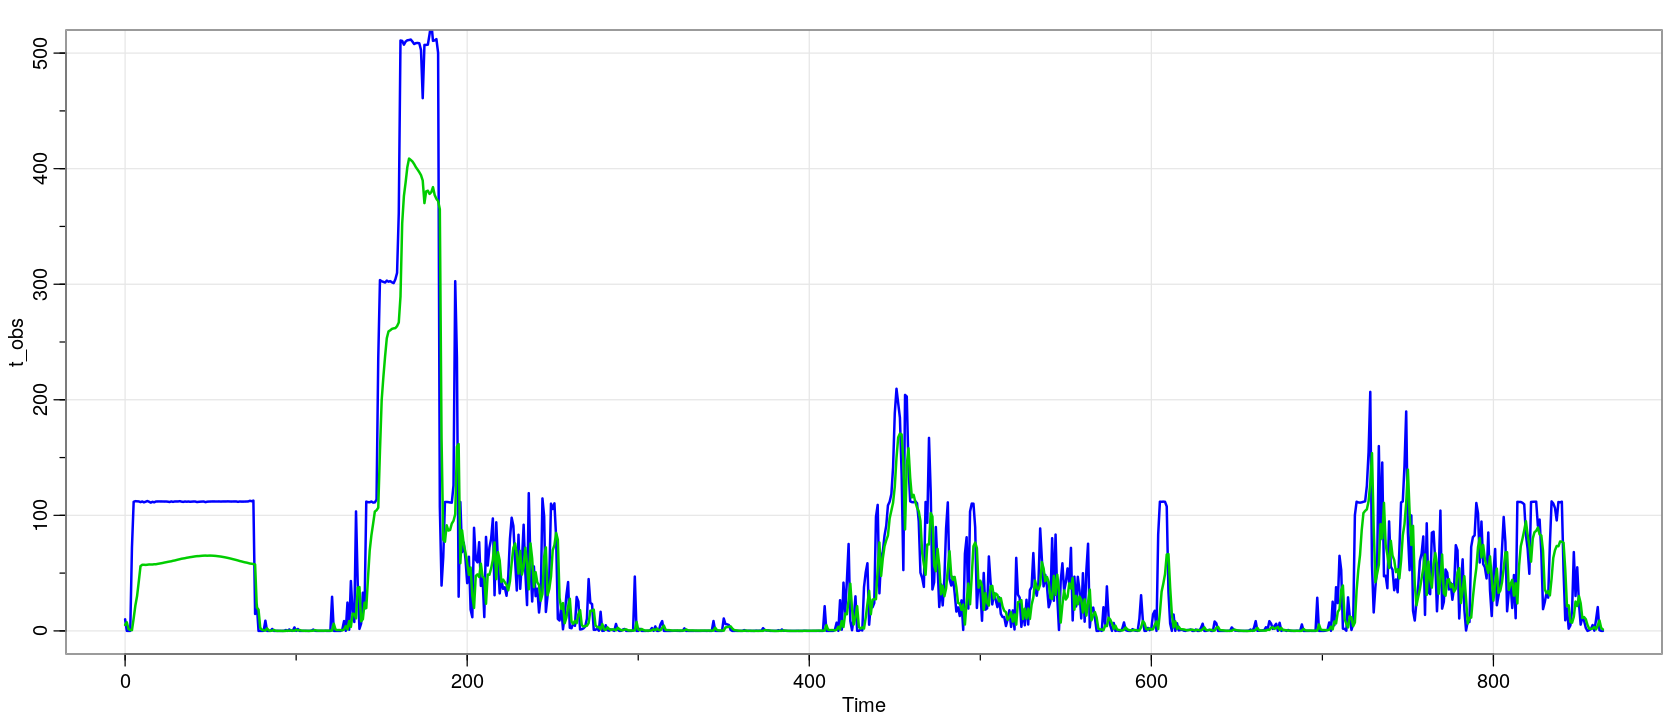

In [39]:
t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

In [40]:
 # EXP

In [ ]:
# Probamos una prediccion de tres días del modelo ARMA(4,0,6)

In [76]:

fit_predict_exp <- function(start_train, start_test, time_series) {
    
    ret = c(0,0)
    
    ts_length = length(time_series)        
    
    end_train = start_test - 1

    ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
    ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)
    
    dn = ts_df_train
    dnt = ts_df_test
    
    # nuevos datos para prediccion 
    new_t = seq(start_test-1,start_test-1,by=1)
    new_t = ts(new_t,start=start_test-1,freq=1)
    new_data = data.frame(t=new_t)
    
    # agrego para probar +1 para evitar log(0)
    ldn = log(dn+1)
    ldnt = log(dnt+1)
    t = time(ldn)
    
    fit = lm(ldn ~ t, na.action=NULL)
    
    ndata <- data.frame(t = new_data)
    
    predict_trend = predict(fit,newdata=ndata)
    
    predicttrend = ts(fitted(fit), start=start_train-1, freq=1)
    
    ldnc = ldn-predicttrend
    ###
    ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)
    ### 
    
    t = time(ldnc)
    
    f1 =  0.003473
    f2 =  0.006946
    f3 =  0.010419

    fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                      cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                     cos(2*pi*f3*t) + sin(2*pi*f3*t) ,
             na.action=NULL)
    
    prediction = ts(fitted(fit), start=start_train-1, freq=1)
    
    #tn = ts_length
    tn = start_test - 1 
            
#    v = 0 + cos(2*pi*f1*tn) + sin(2*pi*f1*tn) +
#                  cos(2*pi*f2*tn) + sin(2*pi*f2*tn) +
#                 cos(2*pi*f3*tn) + sin(2*pi*f3*tn)

    #vdf <- data.frame(t = v)
    
    vdf <- data.frame(t = new_data)
    fore_f = predict(fit, vdf)    

    res = (ts(residuals(fit), start=start_train -1, freq=1))

    ldncr1 = res
        
    #fit = Arima(ldncr1, order = c(4,0,6), method='CSS', include.mean=FALSE)
    #############################
    fit = Arima(ldncr1, order = c(6,0,6), method='CSS', seasonal = list(order = c(6,0,1), period = 6), include.mean=FALSE)
    #############################
    
    fore = forecast(fit, h=1)   
    
    ldnt = as.numeric(ldnt)

    ldnt = ts(ldnt, start=start_test -1, frequency=1)    
    
    v_ldnt = ldnt 
    v_pred = fore$mean + fore_f + predict_trend    
    
    v_ldnt = (exp(v_ldnt)) -1 
    v_pred = (exp(v_pred)) -1 
    
    v_ldnt[1:5]
    v_pred[1:5]
    ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1],fore$mean,fore_f,predict_trend)
    
    return(ret)
    
}

In [77]:
print(Sys.time())

[1] "2021-07-26 23:42:08 -03"


In [78]:

df_validation <- data.frame(observed=double(), predicted=double(), timeo=integer(), timep=integer())

vect_obs <- c()
vect_pred <- c()

for (i in (5184:6048)) {   
    print(i)    
    testv <- fit_predict_exp(i-3550, i, ts_df)
    print(testv)
    vect_obs <- append(vect_obs, testv[1])
    vect_pred <- append(vect_pred, testv[2])
    df_validation[nrow(df_validation)+1,] = testv
}

[1] 5184
                        1                                                   1 
  10.0249133    3.4481344 5183.0000000 5183.0000000   -0.4782864   -0.3384790 
           1 
   2.3092503 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5185
                        1                                                   1 
   0.0384400    6.7890577 5184.0000000 5184.0000000    0.1449705   -0.4022948 
           1 
   2.3100441 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5186
                          1                                           
 5.016667e-03  1.703732e+00  5.185000e+03  5.185000e+03 -8.451943e-01 
            1             1 
-4.683383e-01  2.308166e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5187
                        1                                                   1 
   0.0231700    1.1697874 5186.0000000 5186.0000000   -0.9990869   -0.5325487 
           1 
   2.3062649 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5188
                        1                                                   1 
  72.2856433    1.5366603 5187.0000000 5187.0000000   -0.7788294   -0.5947055 
           1 
   2.3043832 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5189
                        1                                                   1 
 111.7091900   13.2843592 5188.0000000 5188.0000000    0.9993974   -0.6475459 
           1 
   2.3073136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5190
                        1                                                   1 
 112.2612533   22.8815425 5189.0000000 5189.0000000    1.5597962   -0.6974266 
           1 
   2.3107362 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5191
                        1                                                   1 
 112.1178467   28.8007328 5190.0000000 5190.0000000    1.8253453   -0.7449737 
           1 
   2.3141614 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5192
                        1                                                   1 
 112.0400633   36.5274257 5191.0000000 5191.0000000    2.0973704   -0.7901182 
           1 
   2.3178198 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5193
                        1                                                   1 
 111.4374967   50.2963799 5192.0000000 5192.0000000    2.4489033   -0.8327946 
           1 
   2.3215114 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5194
                        1                                                   1 
 111.9800500   40.9914686 5193.0000000 5193.0000000    2.2854090   -0.8729535 
           1 
   2.3250110 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5195
                        1                                                   1 
 111.2495167   53.2816299 5194.0000000 5194.0000000    2.5759391   -0.9105279 
           1 
   2.3287747 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5196
                        1                                                   1 
 111.7767600   31.9934475 5195.0000000 5195.0000000    2.1092218   -0.9455061 
           1 
   2.3325933 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5197
                        1                                                   1 
 112.3678267   42.3906481 5196.0000000 5196.0000000    2.4120005   -0.9778466 
           1 
   2.3360901 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5198
                      1                                               1 
 111.781473   34.833971 5197.000000 5197.000000    2.247589   -1.007532 
          1 
   2.338839 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5199
                      1                                               1 
 111.005633   46.777007 5198.000000 5198.000000    2.559414   -1.034567 
          1 
   2.341697 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5200
                      1                                               1 
 111.706627   48.501684 5199.000000 5199.000000    2.616121   -1.058971 
          1 
   2.344857 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5201
                      1                                               1 
 111.264197   61.978207 5200.000000 5200.000000    2.876779   -1.080753 
          1 
   2.346763 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5202
                      1                                               1 
 111.957293   57.210749 5201.000000 5201.000000    2.815684   -1.099948 
          1 
   2.348334 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5203
                      1                                               1 
 112.011300   57.924407 5202.000000 5202.000000    2.841437   -1.116581 
          1 
   2.351400 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5204
                      1                                               1 
 112.017720   47.707994 5203.000000 5203.000000    2.662281   -1.130751 
          1 
   2.354314 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5205
                      1                                               1 
 112.003947   53.680678 5204.000000 5204.000000    2.786981   -1.142525 
          1 
   2.357054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5206
                      1                                               1 
 111.977190   57.032217 5205.000000 5205.000000    2.852886   -1.151980 
          1 
   2.360092 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5207
                      1                                               1 
 111.945190   66.517110 5206.000000 5206.000000    3.009277   -1.159213 
          1 
   2.362317 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5208
                      1                                               1 
 111.966773   65.595887 5207.000000 5207.000000    2.996954   -1.164308 
          1 
   2.365997 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5209
                      1                                               1 
 111.807650   60.315701 5208.000000 5208.000000    2.914064   -1.167400 
          1 
   2.369372 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5210
                      1                                               1 
 111.538163   67.695688 5209.000000 5209.000000    3.025325   -1.168601 
          1 
   2.372962 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5211
                      1                                               1 
 112.023600   70.067295 5210.000000 5210.000000    3.055041   -1.168039 
          1 
   2.376625 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5212
                      1                                               1 
 111.656463   78.625311 5211.000000 5211.000000    3.162836   -1.165836 
          1 
   2.380331 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5213
                      1                                               1 
 111.997350   80.260456 5212.000000 5212.000000    3.175770   -1.162141 
          1 
   2.384030 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5214
                      1                                               1 
 111.997157   73.157863 5213.000000 5213.000000    3.075838   -1.157086 
          1 
   2.387445 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5215
                      1                                               1 
 112.004130   80.777383 5214.000000 5214.000000    3.163896   -1.150822 
          1 
   2.390927 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5216
                      1                                               1 
 112.241110   75.443072 5215.000000 5215.000000    3.085441   -1.143503 
          1 
   2.394608 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5217
                      1                                               1 
 111.831763   76.968458 5216.000000 5216.000000    3.093240   -1.135285 
          1 
   2.398350 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5218
                      1                                               1 
 111.637533   72.889937 5217.000000 5217.000000    3.026833   -1.126341 
          1 
   2.402085 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5219
                      1                                               1 
 111.969667   77.113698 5218.000000 5218.000000    3.069129   -1.116830 
          1 
   2.405866 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5220
                      1                                               1 
 111.783217   82.885423 5219.000000 5219.000000    3.126761   -1.106909 
          1 
   2.409600 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5221
                      1                                               1 
 111.951437   76.479015 5220.000000 5220.000000    3.033433   -1.096750 
          1 
   2.413323 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5222
                      1                                               1 
 111.733187   78.930789 5221.000000 5221.000000    3.050566   -1.086513 
          1 
   2.417108 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5223
                      1                                               1 
 111.857370   79.969419 5222.000000 5222.000000    3.049615   -1.076370 
          1 
   2.420827 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5224
                      1                                               1 
 111.956187   91.029756 5223.000000 5223.000000    3.164015   -1.066479 
          1 
   2.424576 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5225
                      1                                               1 
 111.956000   89.040248 5224.000000 5224.000000    3.129043   -1.057001 
          1 
   2.428214 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5226
                      1                                               1 
 111.512567   86.648425 5225.000000 5225.000000    3.089453   -1.048094 
          1 
   2.431974 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5227
                      1                                               1 
 111.695367   88.279183 5226.000000 5226.000000    3.096075   -1.039921 
          1 
   2.435615 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5228
                      1                                               1 
 111.820777   86.761327 5227.000000 5227.000000    3.067856   -1.032622 
          1 
   2.439387 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5229
                      1                                               1 
 111.912883   86.201078 5228.000000 5228.000000    3.051494   -1.026344 
          1 
   2.443067 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5230
                      1                                               1 
 111.963120   83.776467 5229.000000 5229.000000    3.014396   -1.021225 
          1 
   2.446847 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5231
                      1                                               1 
 111.421820   85.014860 5230.000000 5230.000000    3.021332   -1.017398 
          1 
   2.450586 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5232
                      1                                               1 
 111.814530   86.241299 5231.000000 5231.000000    3.029351   -1.014998 
          1 
   2.454325 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5233
                      1                                               1 
 111.903503   85.274781 5232.000000 5232.000000    3.013584   -1.014127 
          1 
   2.458080 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5234
                      1                                               1 
 111.947290   86.297572 5233.000000 5233.000000    3.022227   -1.014897 
          1 
   2.461993 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5235
                      1                                               1 
 112.005000   85.777183 5234.000000 5234.000000    3.014625   -1.017411 
          1 
   2.466130 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5236
                      1                                               1 
 112.003787   85.490628 5235.000000 5235.000000    3.011556   -1.021761 
          1 
   2.470242 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5237
                      1                                               1 
 111.967337   85.065640 5236.000000 5236.000000    3.008749   -1.028026 
          1 
   2.474388 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5238
                      1                                               1 
 111.975787   84.392759 5237.000000 5237.000000    3.004999   -1.036275 
          1 
   2.478537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5239
                      1                                               1 
 112.007617   83.995409 5238.000000 5238.000000    3.006771   -1.046563 
          1 
   2.482389 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5240
                      1                                               1 
 111.910653   83.528332 5239.000000 5239.000000    3.009766   -1.058931 
          1 
   2.486252 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5241
                      1                                               1 
 111.990293   83.153528 5240.000000 5240.000000    3.015831   -1.073417 
          1 
   2.490228 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5242
                      1                                               1 
 112.008550   82.521196 5241.000000 5241.000000    3.020801   -1.090040 
          1 
   2.494340 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5243
                      1                                               1 
 111.996137   81.832496 5242.000000 5242.000000    3.027155   -1.108817 
          1 
   2.498482 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5244
                      1                                               1 
 112.077520   81.147831 5243.000000 5243.000000    3.035644   -1.129744 
          1 
   2.502620 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5245
                      1                                               1 
 112.009943   80.597529 5244.000000 5244.000000    3.047840   -1.152806 
          1 
   2.506765 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5246
                      1                                               1 
 111.936703   79.768314 5245.000000 5245.000000    3.059072   -1.177980 
          1 
   2.510492 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5247
                      1                                               1 
 111.977190   79.218393 5246.000000 5246.000000    3.075755   -1.205219 
          1 
   2.514216 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5248
                      1                                               1 
 112.009117   78.384967 5247.000000 5247.000000    3.090962   -1.234472 
          1 
   2.517819 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5249
                      1                                               1 
 112.010850   77.837099 5248.000000 5248.000000    3.111576   -1.265676 
          1 
   2.521483 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5250
                      1                                               1 
 111.681393   77.083104 5249.000000 5249.000000    3.131484   -1.298758 
          1 
   2.525048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5251
                      1                                               1 
 111.989620   76.365011 5250.000000 5250.000000    3.154280   -1.333638 
          1 
   2.527892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5252
                      1                                               1 
 111.868710   75.716427 5251.000000 5251.000000    3.178812   -1.370197 
          1 
   2.531501 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5253
                      1                                               1 
 111.887417   74.987746 5252.000000 5252.000000    3.203572   -1.408349 
          1 
   2.535349 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5254
                      1                                               1 
 111.912903   74.338019 5253.000000 5253.000000    3.230727   -1.447977 
          1 
   2.539234 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5255
                      1                                               1 
 111.974383   73.675067 5254.000000 5254.000000    3.259372   -1.488952 
          1 
   2.542727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5256
                      1                                               1 
 112.028107   73.045699 5255.000000 5255.000000    3.291009   -1.531131 
          1 
   2.544805 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5257
                      1                                               1 
 112.578530   72.455381 5256.000000 5256.000000    3.324538   -1.574345 
          1 
   2.546485 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5258
                      1                                               1 
 112.197173   72.007463 5257.000000 5257.000000    3.359307   -1.618426 
          1 
   2.549681 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5259
                      1                                               1 
 112.738197   71.357334 5258.000000 5258.000000    3.392269   -1.663255 
          1 
   2.552603 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5260
                      1                                               1 
  14.640450   71.080102 5259.000000 5259.000000    3.432374   -1.708644 
          1 
   2.554048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5261
                      1                                               1 
  22.631273   26.149495 5260.000000 5260.000000    2.504889   -1.757731 
          1 
   2.554200 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5262
                      1                                               1 
   0.000780   24.853935 5261.000000 5261.000000    2.504178   -1.806316 
          1 
   2.554601 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5263
                        1                                                   1 
   0.0000000    4.0530288 5262.0000000 5262.0000000    0.9284444   -1.8602038 
           1 
   2.5517472 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5264
                        1                                                   1 
   0.0000000    2.1327491 5263.0000000 5263.0000000    0.5081659   -1.9138778 
           1 
   2.5476229 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5265
                        1                                                   1 
   0.0658500    1.5192200 5264.0000000 5264.0000000    0.3475488   -1.9671049 
           1 
   2.5435055 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5266
                      1                                               1 
   8.827987    1.246471 5265.000000 5265.000000    0.288373   -2.019566 
          1 
   2.540554 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5267
                      1                                               1 
   0.000000    4.880671 5266.000000 5266.000000    1.298608   -2.067445 
          1 
   2.540508 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5268
                        1                                                   1 
   0.0000000    1.8255639 5267.0000000 5267.0000000    0.6183092   -2.1181060 
           1 
   2.5385048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5269
                        1                                                   1 
   0.0000000    0.9261994 5268.0000000 5268.0000000    0.2866793   -2.1674984 
           1 
   2.5363679 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5270
                        1                                                   1 
   1.6619533    1.4154035 5269.0000000 5269.0000000    0.5631901   -2.2153991 
           1 
   2.5340753 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5271
                      1                                               1 
   0.000000    1.613971 5270.000000 5270.000000    0.688672   -2.259945 
          1 
   2.532143 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5272
                        1                                                   1 
   0.0000000    1.1182860 5271.0000000 5271.0000000    0.5246915   -2.3041979 
           1 
   2.5301137 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5273
                          1                                           
   0.01429667    0.55754403 5272.00000000 5272.00000000    0.26133601 
            1             1 
  -2.34631801    2.52809224 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5274
                        1                                                   1 
   0.0000000    0.2917280 5273.0000000 5273.0000000    0.1162097   -2.3860717 
           1 
   2.5258428 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5275
                        1                                                   1 
   0.0000000    0.3039026 5274.0000000 5274.0000000    0.1649398   -2.4232977 
           1 
   2.5237197 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5276
                          1                                           
   0.00000000    0.01814975 5275.00000000 5275.00000000   -0.04426281 
            1             1 
  -2.45777745    2.52002727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5277
                          1                                           
   0.06687667    0.40689335 5276.00000000 5276.00000000    0.31312433 
            1             1 
  -2.48929283    2.51755248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5278
                        1                                                   1 
   0.7558433    0.2295446 5277.0000000 5277.0000000    0.2094891   -2.5175750 
           1 
   2.5147298 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5279
                        1                                                   1 
   0.0000000    0.7326420 5278.0000000 5278.0000000    0.5782349   -2.5417147 
           1 
   2.5131272 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5280
                          1                                           
   1.23558000    0.09360389 5279.00000000 5279.00000000    0.14228916 
            1             1 
  -2.56334142    2.51053083 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5281
                        1                                                   1 
   0.1174033    0.6461433 5280.0000000 5280.0000000    0.5713403   -2.5799980 
           1 
   2.5070929 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5282
                        1                                                   1 
   0.0470600    0.2270490 5281.0000000 5281.0000000    0.2955602   -2.5940296 
           1 
   2.5030815 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5283
                        1                                                   1 
   3.0123500    0.2100860 5282.0000000 5282.0000000    0.2962871   -2.6042543 
           1 
   2.4986586 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5284
                          1                                           
   0.02853667    1.18978603 5283.00000000 5283.00000000    0.89529755 
            1             1 
  -2.60818458    2.49669086 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5285
                        1                                                   1 
   1.6343967    0.3328250 5284.0000000 5284.0000000    0.4048849   -2.6102779 
           1 
   2.4926938 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5286
                        1                                                   1 
   0.0000000    0.5831134 5285.0000000 5285.0000000    0.5761971   -2.6065653 
           1 
   2.4897616 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5287
                        1                                                   1 
   0.0000000    0.2750662 5286.0000000 5286.0000000    0.3574046   -2.6001757 
           1 
   2.4857693 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5288
                          1                                           
 0.000000e+00  3.020222e-03  5.287000e+03  5.287000e+03  1.101245e-01 
            1             1 
-2.589414e+00  2.482305e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5289
                          1                                           
   0.04909667    0.17594661 5288.00000000 5288.00000000    0.25751696 
            1             1 
  -2.57423474    2.47879123 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5290
                        1                                                   1 
   0.0000000    0.1874212 5289.0000000 5289.0000000    0.2515339   -2.5545168 
           1 
   2.4747667 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5291
                          1                                           
   0.00000000    0.06568026 5290.00000000 5290.00000000    0.12332758 
            1             1 
  -2.53038574    2.47067150 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5292
                        1                                                   1 
   0.0000000    0.2118264 5291.0000000 5291.0000000    0.2273045   -2.5017508 
           1 
   2.4665749 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5293
                          1                                           
 2.314033e-01  3.519489e-03  5.292000e+03  5.292000e+03  9.792511e-03 
            1             1 
-2.468617e+00  2.462337e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5294
                        1                                                   1 
   1.1512800    0.4293405 5293.0000000 5293.0000000    0.3295349   -2.4306509 
           1 
   2.4583291 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5295
                          1                                           
   0.09060333    0.60230486 5294.00000000 5294.00000000    0.40347523 
            1             1 
  -2.38730266    2.45527056 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5296
                        1                                                   1 
   0.0000000    0.3989548 5295.0000000 5295.0000000    0.2250569   -2.3407065 
           1 
   2.4513749 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5297
                          1                                           
 2.033333e-04  2.854912e-01  5.296000e+03  5.296000e+03  9.265236e-02 
            1             1 
-2.289927e+00  2.448415e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5298
                          1                                           
   0.00000000    0.17046816 5297.00000000 5297.00000000   -0.05219507 
            1             1 
  -2.23491187    2.44451074 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5299
                        1                                                   1 
   0.0000000    0.1449820 5298.0000000 5298.0000000   -0.1293801   -2.1757358 
           1 
   2.4405049 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5300
                        1                                                   1 
   0.0000000    0.1813189 5299.0000000 5299.0000000   -0.1568495   -2.1125022 
           1 
   2.4359833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5301
                        1                                                   1 
   0.0715600    0.2563452 5300.0000000 5300.0000000   -0.1579315   -2.0453214 
           1 
   2.4314598 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5302
                          1                                           
   0.00000000    0.43279993 5301.00000000 5301.00000000   -0.09476253 
            1             1 
  -1.97420961    2.42860266 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5303
                        1                                                   1 
   0.0000000    0.2935271 5302.0000000 5302.0000000   -0.2687288   -1.8995704 
           1 
   2.4256719 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5304
                        1                                                   1 
   0.0000000    0.3507976 5303.0000000 5303.0000000   -0.3001990   -1.8214415 
           1 
   2.4223357 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5305
                        1                                                   1 
  29.5051433    0.3825934 5304.0000000 5304.0000000   -0.3542229   -1.7399824 
           1 
   2.4181663 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5306
                      1                                               1 
   0.036520    6.641170 5305.000000 5305.000000    1.263838   -1.649622 
          1 
   2.419334 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5307
                          1                                           
 0.000000e+00  1.331224e+00  5.306000e+03  5.306000e+03 -7.631065e-03 
            1             1 
-1.562005e+00  2.416030e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5308
                        1                                                   1 
   0.0000000    0.7284658 5307.0000000 5307.0000000   -0.3937765   -1.4716944 
           1 
   2.4127051 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5309
                        1                                                   1 
   0.0003800    0.7729296 5308.0000000 5308.0000000   -0.4567778   -1.3788359 
           1 
   2.4082470 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5310
                        1                                                   1 
   0.0000000    0.5534126 5309.0000000 5309.0000000   -0.6800642   -1.2836258 
           1 
   2.4041442 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5311
                        1                                                   1 
   1.3188800    0.4756628 5310.0000000 5310.0000000   -0.8252784   -1.1862962 
           1 
   2.4006818 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5312
                        1                                                   1 
   8.5171133    1.6826305 5311.0000000 5311.0000000   -0.3252126   -1.0856775 
           1 
   2.3976880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5313
                        1                                                   1 
   0.0505000    3.6258895 5312.0000000 5312.0000000    0.1156282   -0.9810447 
           1 
   2.3970851 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5314
                        1                                                   1 
  24.4968633    1.8443483 5313.0000000 5313.0000000   -0.4701419   -0.8787310 
           1 
   2.3942069 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5315
                        1                                                   1 
   0.9949133    6.5264107 5314.0000000 5314.0000000    0.3949002   -0.7699299 
           1 
   2.3934479 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5316
                          1                                           
  43.14587000    4.32581732 5315.00000000 5315.00000000   -0.05285908 
            1             1 
  -0.66451137    2.38993664 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5317
                        1                                                   1 
  15.4643033   14.3712861 5316.0000000 5316.0000000    0.8960572   -0.5532546 
           1 
   2.3896986 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5318
                        1                                                   1 
   7.7067900   15.2785064 5317.0000000 5317.0000000    0.8439104   -0.4432836 
           1 
   2.3892189 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5319
                        1                                                   1 
 103.3897767    9.8110904 5318.0000000 5318.0000000    0.3254222   -0.3342869 
           1 
   2.3894372 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5320
                        1                                                   1 
  40.7138133   27.2333839 5319.0000000 5319.0000000    1.1694293   -0.2213084 
           1 
   2.3923842 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5321
                        1                                                   1 
   1.7277867   30.7699297 5320.0000000 5320.0000000    1.1745012   -0.1103242 
           1 
   2.3943433 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5322
                          1                                           
 6.406297e+00  5.354317e+00  5.321000e+03  5.321000e+03 -5.389957e-01 
            1             1 
-4.626388e-03  2.392757e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5323
                        1                                                   1 
  33.0665067   13.6461259 5322.0000000 5322.0000000    0.1893670    0.1018099 
           1 
   2.3929990 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5324
                        1                                                   1 
  19.1323900   15.4142105 5323.0000000 5323.0000000    0.1939299    0.2096099 
           1 
   2.3946077 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5325
                        1                                                   1 
 111.8717500   24.1896919 5324.0000000 5324.0000000    0.5159035    0.3150887 
           1 
   2.3954426 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5326
                        1                                                   1 
 111.3747633   40.1227485 5325.0000000 5325.0000000    0.8965961    0.4217898 
           1 
   2.3981756 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5327
                        1                                                   1 
 111.3080200   64.8701206 5326.0000000 5326.0000000    1.2603767    0.5265724 
           1 
   2.4007358 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5328
                        1                                                   1 
 111.9396833   77.3655457 5327.0000000 5327.0000000    1.3288790    0.6292174 
           1 
   2.4032880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5329
                        1                                                   1 
 111.0434000   99.5488501 5328.0000000 5328.0000000    1.4750308    0.7295149 
           1 
   2.4060979 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5330
                        1                                                   1 
 111.1930633   85.9766934 5329.0000000 5329.0000000    1.2312279    0.8272254 
           1 
   2.4071869 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5331
                        1                                                   1 
 113.5895433  103.7413622 5330.0000000 5330.0000000    1.3198639    0.9221922 
           1 
   2.4094380 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5332
                      1                                               1 
 235.925457   96.694462 5331.000000 5331.000000    1.155726    1.014235 
          1 
   2.411884 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5333
                      1                                               1 
 303.574390  125.044810 5332.000000 5332.000000    1.316309    1.104355 
          1 
   2.415973 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5334
                      1                                               1 
 302.535293  171.365511 5333.000000 5333.000000    1.538593    1.191568 
          1 
   2.419457 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5335
                      1                                               1 
 302.036357  174.094943 5334.000000 5334.000000    1.467335    1.275303 
          1 
   2.422690 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5336
                      1                                               1 
 301.445650  239.804957 5335.000000 5335.000000    1.703029    1.355420 
          1 
   2.425538 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5337
                      1                                               1 
 303.129613  259.525817 5336.000000 5336.000000    1.703120    1.431790 
          1 
   2.427791 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5338
                      1                                               1 
 302.177760  277.723837 5337.000000 5337.000000    1.695151    1.504316 
          1 
   2.430754 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5339
                      1                                               1 
 302.673503  245.956727 5338.000000 5338.000000    1.503335    1.572863 
          1 
   2.433015 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5340
                      1                                               1 
 301.652047  271.881604 5339.000000 5339.000000    1.536289    1.637356 
          1 
   2.435394 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5341
                      1                                               1 
 300.947903  284.491191 5340.000000 5340.000000    1.519199    1.697706 
          1 
   2.437306 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5342
                      1                                               1 
 304.223153  235.370814 5341.000000 5341.000000    1.272349    1.753857 
          1 
   2.439196 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5343
                      1                                               1 
 309.813180  306.348462 5342.000000 5342.000000    1.481102    1.805781 
          1 
   2.441099 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5344
                      1                                               1 
 361.542613  284.676129 5343.000000 5343.000000    1.357203    1.853456 
          1 
   2.444199 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5345
                      1                                               1 
 510.909393  303.767610 5344.000000 5344.000000    1.376191    1.897069 
          1 
   2.446290 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5346
                      1                                               1 
 510.578123  385.865681 5345.000000 5345.000000    1.572355    1.936956 
          1 
   2.448767 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5347
                      1                                               1 
 507.280513  417.276409 5346.000000 5346.000000    1.611008    1.972545 
          1 
   2.452589 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5348
                      1                                               1 
 509.967917  449.345254 5347.000000 5347.000000    1.650356    2.003825 
          1 
   2.455833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5349
                      1                                               1 
 511.098847  432.116629 5348.000000 5348.000000    1.581841    2.030867 
          1 
   2.458298 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5350
                      1                                               1 
 511.325703  482.121527 5349.000000 5349.000000    1.665773    2.053731 
          1 
   2.460764 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5351
                      1                                               1 
 511.738607  454.380678 5350.000000 5350.000000    1.585428    2.072480 
          1 
   2.463226 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5352
                      1                                               1 
 509.957230  471.923985 5351.000000 5351.000000    1.606057    2.087191 
          1 
   2.465687 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5353
                      1                                               1 
 507.862737  436.710800 5352.000000 5352.000000    1.515443    2.097950 
          1 
   2.468165 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5354
                      1                                               1 
 508.632633  425.069787 5353.000000 5353.000000    1.478470    2.104861 
          1 
   2.471272 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5355
                      1                                               1 
 508.788493  449.342808 5354.000000 5354.000000    1.528253    2.108039 
          1 
   2.473718 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5356
                      1                                               1 
 508.514510  443.215276 5355.000000 5355.000000    1.512527    2.107622 
          1 
   2.476160 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5357
                      1                                               1 
 502.638163  425.551049 5356.000000 5356.000000    1.473351    2.103748 
          1 
   2.478634 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5358
                      1                                               1 
 461.007987  445.249672 5357.000000 5357.000000    1.522783    2.096547 
          1 
   2.481549 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5359
                      1                                               1 
 507.083293  434.803744 5358.000000 5358.000000    1.507229    2.086046 
          1 
   2.483917 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5360
                      1                                               1 
 507.105317  427.958446 5359.000000 5359.000000    1.502273    2.072725 
          1 
   2.486362 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5361
                      1                                               1 
 507.310210  437.063269 5360.000000 5360.000000    1.536975    2.056601 
          1 
   2.488787 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5362
                      1                                               1 
 516.311817  431.790926 5361.000000 5361.000000    1.541187    2.037858 
          1 
   2.491209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5363
                      1                                               1 
 526.918800  434.689886 5362.000000 5362.000000    1.566569    2.016714 
          1 
   2.493648 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5364
                      1                                               1 
 510.601420  432.165943 5363.000000 5363.000000    1.581646    1.993367 
          1 
   2.496107 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5365
                      1                                               1 
 510.998663  415.565029 5364.000000 5364.000000    1.565092    1.967931 
          1 
   2.499019 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5366
                      1                                               1 
 512.115213  411.077555 5365.000000 5365.000000    1.579118    1.940656 
          1 
   2.501438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5367
                      1                                               1 
 500.257667  404.865975 5366.000000 5366.000000    1.590409    1.911758 
          1 
   2.503856 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5368
                      1                                               1 
 107.760897  408.486820 5367.000000 5367.000000    1.627257    1.881403 
          1 
   2.506245 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5369
                        1                                                   1 
  39.2118000  190.7083523 5368.0000000 5368.0000000    0.9017893    1.8472760 
           1 
   2.5069099 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5370
                        1                                                   1 
  63.7721533   95.0892870 5369.0000000 5369.0000000    0.2483344    1.8104924 
           1 
   2.5064510 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5371
                        1                                                   1 
 111.5674600   94.2663303 5370.0000000 5370.0000000    0.2764068    1.7737421 
           1 
   2.5065276 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5372
                        1                                                   1 
 111.5659200  113.5455215 5371.0000000 5371.0000000    0.4963814    1.7373660 
           1 
   2.5072249 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5373
                      1                                               1 
 111.433790  115.519767 5372.000000 5372.000000    0.549489    1.700646 
          1 
   2.507926 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5374
                        1                                                   1 
 111.1162433  119.6600248 5373.0000000 5373.0000000    0.6205736    1.6637854 
           1 
   2.5086178 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5375
                        1                                                   1 
 110.9468900  116.1956191 5374.0000000 5374.0000000    0.6268683    1.6269866 
           1 
   2.5099897 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5376
                        1                                                   1 
 125.9768567  119.2074174 5375.0000000 5375.0000000    0.6881092    1.5904373 
           1 
   2.5106723 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5377
                        1                                                   1 
 302.6263333  122.3642648 5376.0000000 5376.0000000    0.7490016    1.5545563 
           1 
   2.5115837 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5378
                      1                                               1 
 236.378320  200.035155 5377.000000 5377.000000    1.269316    1.520778 
          1 
   2.513386 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5379
                      1                                               1 
  29.597580  189.685138 5378.000000 5378.000000    1.248317    1.487399 
          1 
   2.514908 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5380
                        1                                                   1 
 111.5330800   64.6046161 5379.0000000 5379.0000000    0.2179634    1.4515628 
           1 
   2.5141198 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5381
                      1                                               1 
  68.154687   89.358821 5380.000000 5380.000000    0.569927    1.419065 
          1 
   2.514797 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5382
                        1                                                   1 
  76.3643667   72.4599285 5381.0000000 5381.0000000    0.3947673    1.3870496 
           1 
   2.5149232 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5383
                        1                                                   1 
  62.1274167   72.8243506 5382.0000000 5382.0000000    0.4298474    1.3566675 
           1 
   2.5151738 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5384
                        1                                                   1 
  41.3246367   71.5540686 5383.0000000 5383.0000000    0.4416179    1.3275210 
           1 
   2.5151932 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5385
                        1                                                   1 
  64.1724767   56.6906874 5384.0000000 5384.0000000    0.2409323    1.2994034 
           1 
   2.5147601 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5386
                        1                                                   1 
  18.4287200   59.7524917 5385.0000000 5385.0000000    0.3181736    1.2738228 
           1 
   2.5148117 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5387
                        1                                                   1 
  11.8159300   33.4852481 5386.0000000 5386.0000000   -0.2215397    1.2481223 
           1 
   2.5139491 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5388
                        1                                                   1 
  89.2119933   21.8719637 5387.0000000 5387.0000000   -0.6059749    1.2237216 
           1 
   2.5121651 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5389
                        1                                                   1 
  61.6099600   65.3533069 5388.0000000 5388.0000000    0.4774691    1.2046828 
           1 
   2.5128417 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5390
                      1                                               1 
  59.323447   52.111225 5389.000000 5389.000000    0.272051    1.187169 
          1 
   2.513169 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5391
                        1                                                   1 
  76.7902100   58.2942992 5390.0000000 5390.0000000    0.3976095    1.1717783 
           1 
   2.5131254 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5392
                        1                                                   1 
  38.9562400   59.4066480 5391.0000000 5391.0000000    0.4286897    1.1590428 
           1 
   2.5133666 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5393
                        1                                                   1 
  45.6025767   43.7630120 5392.0000000 5392.0000000    0.1409645    1.1474387 
           1 
   2.5129790 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5394
                        1                                                   1 
  11.9752000   47.6974005 5393.0000000 5393.0000000    0.2346339    1.1383526 
           1 
   2.5126392 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5395
                        1                                                   1 
  81.3241900   25.6438701 5394.0000000 5394.0000000   -0.3576781    1.1293804 
           1 
   2.5108568 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5396
                        1                                                   1 
  56.5398133   52.8417168 5395.0000000 5395.0000000    0.3491335    1.1257601 
           1 
   2.5111550 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5397
                        1                                                   1 
  72.1757500   52.2872851 5396.0000000 5396.0000000    0.3408958    1.1237544 
           1 
   2.5110475 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5398
                        1                                                   1 
  79.7545500   50.1548314 5397.0000000 5397.0000000    0.2993209    1.1243271 
           1 
   2.5112090 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5399
                        1                                                   1 
  97.3094767   62.9601778 5398.0000000 5398.0000000    0.5195969    1.1271844 
           1 
   2.5114794 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5400
                        1                                                   1 
  30.8539600   74.2300789 5399.0000000 5399.0000000    0.6745586    1.1324250 
           1 
   2.5135676 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5401
                        1                                                   1 
  93.9746900   44.3439494 5400.0000000 5400.0000000    0.1633552    1.1377218 
           1 
   2.5131997 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5402
                        1                                                   1 
  59.0691400   78.7461004 5401.0000000 5401.0000000    0.7184601    1.1467390 
           1 
   2.5136487 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5403
                        1                                                   1 
  32.4459700   53.2389595 5402.0000000 5402.0000000    0.3230416    1.1567785 
           1 
   2.5135794 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5404
                        1                                                   1 
  44.0805533   45.0015181 5403.0000000 5403.0000000    0.1483067    1.1675186 
           1 
   2.5128491 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5405
                          1                                           
  36.37048000   36.00832266 5404.00000000 5404.00000000   -0.08163924 
            1             1 
   1.18032796    2.51245410 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5406
                        1                                                   1 
3.775346e+01 4.333430e+01 5.405000e+03 5.405000e+03 8.565065e-02 1.194263e+00 
           1 
2.511845e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5407
                          1                                           
  30.36999333   38.04266172 5406.00000000 5406.00000000   -0.05618606 
            1             1 
   1.20956665    2.51127435 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5408
                          1                                           
  47.29125667   40.48421390 5407.00000000 5407.00000000   -0.01083152 
            1             1 
   1.22568040    2.51046409 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5409
                        1                                                   1 
  79.7785333   46.7829257 5408.0000000 5408.0000000    0.1111963    1.2435373 
           1 
   2.5119348 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5410
                        1                                                   1 
  97.9590033   66.6125738 5409.0000000 5409.0000000    0.4381761    1.2630896 
           1 
   2.5125282 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5411
                      1                                               1 
  90.869353   67.216555 5410.000000 5410.000000    0.423890    1.283681 
          1 
   2.515117 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5412
                        1                                                   1 
  61.1083833   81.7003597 5411.0000000 5411.0000000    0.5934834    1.3046483 
           1 
   2.5170923 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5413
                        1                                                   1 
  34.9640033   68.6253544 5412.0000000 5412.0000000    0.3985852    1.3253049 
           1 
   2.5192387 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5414
                        1                                                   1 
8.321009e+01 4.990328e+01 5.413000e+03 5.413000e+03 6.375368e-02 1.345214e+00 
           1 
2.520960e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5415
                        1                                                   1 
  36.4047000   67.0362315 5414.0000000 5414.0000000    0.3312275    1.3665500 
           1 
   2.5222628 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5416
                        1                                                   1 
6.042464e+01 5.006228e+01 5.415000e+03 5.415000e+03 2.466478e-02 1.386373e+00 
           1 
2.522009e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5417
                        1                                                   1 
  91.8663333   56.1425181 5416.0000000 5416.0000000    0.1166684    1.4067156 
           1 
   2.5221645 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5418
                        1                                                   1 
  50.1860800   67.4650084 5417.0000000 5417.0000000    0.2745658    1.4272669 
           1 
   2.5244901 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5419
                        1                                                   1 
  22.3283200   58.5380761 5418.0000000 5418.0000000    0.1162674    1.4461270 
           1 
   2.5242217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5420
                        1                                                   1 
 119.1954133   37.2183608 5419.0000000 5419.0000000   -0.3432519    1.4628425 
           1 
   2.5237254 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5421
                        1                                                   1 
  57.1592400   82.7432753 5420.0000000 5420.0000000    0.4212346    1.4813070 
           1 
   2.5252143 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5422
                        1                                                   1 
  25.4402000   64.3962971 5421.0000000 5421.0000000    0.1571256    1.4973765 
           1 
   2.5259635 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5423
                        1                                                   1 
  55.7642067   44.3337653 5422.0000000 5422.0000000   -0.2222399    1.5107867 
           1 
   2.5255053 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5424
                          1                                           
  30.06412000   52.93765645 5423.00000000 5423.00000000   -0.06395379 
            1             1 
   1.52399876    2.52778390 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5425
                        1                                                   1 
  36.5464633   43.9291701 5424.0000000 5424.0000000   -0.2586661    1.5345368 
           1 
   2.5292166 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5426
                        1                                                   1 
  15.9013467   39.4875792 5425.0000000 5425.0000000   -0.3725336    1.5435979 
           1 
   2.5299310 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5427
                        1                                                   1 
  29.5915833   29.4189642 5426.0000000 5426.0000000   -0.6654404    1.5494105 
           1 
   2.5310961 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5428
                        1                                                   1 
 114.6338667   34.7117253 5427.0000000 5427.0000000   -0.5118459    1.5541685 
           1 
   2.5331564 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5429
                        1                                                   1 
  98.9232267   74.5227435 5428.0000000 5428.0000000    0.2294073    1.5589894 
           1 
   2.5360371 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5430
                      1                                               1 
  16.384073   67.155660 5429.000000 5429.000000    0.121112    1.561297 
          1 
   2.539385 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5431
                        1                                                   1 
  30.4489233   34.4688238 5430.0000000 5430.0000000   -0.5303458    1.5582943 
           1 
   2.5407055 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5432
                        1                                                   1 
  46.5043067   39.9720494 5431.0000000 5431.0000000   -0.3837634    1.5538349 
           1 
   2.5428187 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5433
                        1                                                   1 
 110.1232233   43.7282199 5432.0000000 5432.0000000   -0.2922339    1.5475392 
           1 
   2.5452993 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5434
                        1                                                   1 
 105.4831100   76.0706321 5433.0000000 5433.0000000    0.2559637    1.5400776 
           1 
   2.5486809 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5435
                        1                                                   1 
 110.3753933   76.1636517 5434.0000000 5434.0000000    0.2645806    1.5298942 
           1 
   2.5514537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5436
                        1                                                   1 
  80.6127100   82.7704540 5435.0000000 5435.0000000    0.3569916    1.5170995 
           1 
   2.5539892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5437
                        1                                                   1 
  10.3529367   68.9685643 5436.0000000 5436.0000000    0.1903118    1.5010658 
           1 
   2.5566685 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5438
                        1                                                   1 
   8.9747067   25.5888098 5437.0000000 5437.0000000   -0.7560456    1.4789752 
           1 
   2.5575608 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5439
                      1                                               1 
  20.852380   16.950742 5438.000000 5438.000000   -1.124359    1.453916 
          1 
   2.558075 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5440
                        1                                                   1 
   1.3592033   27.1462935 5439.0000000 5439.0000000   -0.6490298    1.4274341 
           1 
   2.5590114 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5441
                      1                                               1 
  13.434777    7.374156 5440.000000 5440.000000   -1.827267    1.394503 
          1 
   2.557914 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5442
                      1                                               1 
  30.834490   14.174989 5441.000000 5441.000000   -1.200412    1.361932 
          1 
   2.558129 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5443
                        1                                                   1 
  42.2669700   20.7240987 5442.0000000 5442.0000000   -0.8085495    1.3280558 
           1 
   2.5589159 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5444
                        1                                                   1 
   2.7013767   29.7306092 5443.0000000 5443.0000000   -0.4275376    1.2921148 
           1 
   2.5606821 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5445
                      1                                               1 
   2.292100    9.959134 5444.000000 5444.000000   -1.415058    1.249516 
          1 
   2.559716 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5446
                      1                                               1 
   6.896770    7.870220 5445.000000 5445.000000   -1.579998    1.204273 
          1 
   2.558424 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5447
                      1                                               1 
   4.370777   10.443722 5446.000000 5446.000000   -1.279464    1.158146 
          1 
   2.558759 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5448
                      1                                               1 
  29.370407    7.713778 5447.000000 5447.000000   -1.502884    1.109103 
          1 
   2.558687 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5449
                        1                                                   1 
  25.3554767   13.8129479 5448.0000000 5448.0000000   -0.9260072    1.0608074 
           1 
   2.5607015 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5450
                        1                                                   1 
   1.2265700   20.1923093 5449.0000000 5449.0000000   -0.5191197    1.0102200 
           1 
   2.5625381 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5451
                        1                                                   1 
   1.4356367    3.9645288 5450.0000000 5450.0000000   -1.9124271    0.9535547 
           1 
   2.5611908 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5452
                      1                                               1 
   2.211590    4.333887 5451.000000 5451.000000   -1.780689    0.895261 
          1 
   2.559508 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5453
                        1                                                   1 
   3.8185700    3.7896261 5452.0000000 5452.0000000   -1.8278713    0.8358042 
           1 
   2.5585194 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5454
                        1                                                   1 
  10.5701133    5.1028294 5453.0000000 5453.0000000   -1.5250528    0.7755438 
           1 
   2.5582614 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5455
                        1                                                   1 
  44.8483300    7.6100381 5454.0000000 5454.0000000   -1.1213144    0.7154183 
           1 
   2.5588249 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5456
                        1                                                   1 
  24.2153267   17.3544502 5455.0000000 5455.0000000   -0.3071806    0.6564260 
           1 
   2.5606267 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5457
                        1                                                   1 
  23.2340300   14.7058480 5456.0000000 5456.0000000   -0.4028100    0.5954118 
           1 
   2.5614313 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5458
                        1                                                   1 
   0.9275300   12.8406153 5457.0000000 5457.0000000   -0.4684178    0.5334824 
           1 
   2.5625428 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5459
                        1                                                   1 
   0.9253133    3.8166122 5458.0000000 5458.0000000   -1.4551577    0.4666176 
           1 
   2.5606109 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5460
                      1                                               1 
   2.039207    3.567996 5459.000000 5459.000000   -1.439431    0.399253 
          1 
   2.559253 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5461
                        1                                                   1 
   0.1488233    2.7965377 5460.0000000 5460.0000000   -1.5567061    0.3323273 
           1 
   2.5584683 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5462
                        1                                                   1 
  16.5355733    1.1179608 5461.0000000 5461.0000000   -2.0697130    0.2636214 
           1 
   2.5565454 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5463
                        1                                                   1 
   0.0013400    4.8455052 5462.0000000 5462.0000000   -0.9915553    0.1995289 
           1 
   2.5576994 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5464
                        1                                                   1 
   0.1959233    0.9689453 5463.0000000 5463.0000000   -2.0085911    0.1308396 
           1 
   2.5552495 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5465
                          1                                           
   4.91437667    0.63684565 5464.00000000 5464.00000000   -2.12331471 
            1             1 
   0.06285375    2.55323197 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5466
                          1                                           
 6.290133e-01  3.642517e+00  5.465000e+03  5.465000e+03 -1.015032e+00 
            1             1 
-1.870025e-03  2.552158e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5467
                          1                                           
   0.16337333    1.79834013 5466.00000000 5466.00000000   -1.45319211 
            1             1 
  -0.06799592    2.55021445 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5468
                        1                                                   1 
   1.2880933    1.0894397 5467.0000000 5467.0000000   -1.6766366   -0.1337609 
           1 
   2.5472934 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5469
                        1                                                   1 
   0.7244033    1.4921462 5468.0000000 5468.0000000   -1.4356924   -0.1972850 
           1 
   2.5461217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5470
                          1                                           
   0.01995333    0.76135012 5469.00000000 5469.00000000   -1.71888642 
            1             1 
  -0.26003575    2.54500279 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5471
                        1                                                   1 
   6.0272433    0.4596491 5470.0000000 5470.0000000   -1.8423289   -0.3222673 
           1 
   2.5427923 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5472
                        1                                                   1 
   0.8894667    1.8259446 5471.0000000 5471.0000000   -1.1242786   -0.3796971 
           1 
   2.5428184 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5473
                        1                                                   1 
   0.0000000    1.5681588 5472.0000000 5472.0000000   -1.1602857   -0.4376358 
           1 
   2.5411107 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5474
                          1                                           
   0.05778333    0.51473216 5473.00000000 5473.00000000   -1.62837980 
            1             1 
  -0.49480382    2.53842225 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5475
                        1                                                   1 
   1.1294233    0.3326783 5474.0000000 5474.0000000   -1.6990943   -0.5499043 
           1 
   2.5361892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5476
                        1                                                   1 
   1.6453000    0.7082922 5475.0000000 5475.0000000   -1.3979789   -0.6017448 
           1 
   2.5352179 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5477
                        1                                                   1 
   0.0005200    0.9662778 5476.0000000 5476.0000000   -1.2069002   -0.6510379 
           1 
   2.5340804 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5478
                        1                                                   1 
   0.0000000    0.3828680 5477.0000000 5477.0000000   -1.5080723   -0.6996742 
           1 
   2.5319061 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5479
                          1                                           
 1.486667e-03  3.047427e-01  5.478000e+03  5.478000e+03 -1.517514e+00 
            1             1 
-7.459313e-01  2.529451e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5480
                        1                                                   1 
   0.0000000    0.3504444 5479.0000000 5479.0000000   -1.4369763   -0.7897214 
           1 
   2.5271314 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5481
                          1                                           
   0.34637667   -0.01363343 5480.00000000 5480.00000000   -1.70741241 
            1             1 
  -0.83098415    2.52466935 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5482
                        1                                                   1 
  47.0158767    0.3206457 5481.0000000 5481.0000000   -1.3756083   -0.8691588 
           1 
   2.5228879 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5483
                        1                                                   1 
   0.0000000    6.5548516 5482.0000000 5482.0000000    0.3958869   -0.8987112 
           1 
   2.5250143 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5484
                        1                                                   1 
   0.0000000    0.8299213 5483.0000000 5483.0000000   -0.9862024   -0.9321231 
           1 
   2.5225985 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5485
                        1                                                   1 
   1.7757500    0.3348625 5484.0000000 5484.0000000   -1.2682969   -0.9628626 
           1 
   2.5199878 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5486
                        1                                                   1 
   0.0335500    1.0004860 5485.0000000 5485.0000000   -0.8359696   -0.9892049 
           1 
   2.5185648 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5487
                        1                                                   1 
   0.0000000    0.3121557 5486.0000000 5486.0000000   -1.2301227   -1.0145313 
           1 
   2.5163253 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5488
                        1                                                   1 
   0.0000000    0.1686175 5487.0000000 5487.0000000   -1.3207112   -1.0372571 
           1 
   2.5137898 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5489
                          1                                           
   0.06243667    0.40026142 5488.00000000 5488.00000000   -1.11813953 
            1             1 
  -1.05734856    2.51214704 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5490
                        1                                                   1 
   0.0000000    0.0372099 5489.0000000 5489.0000000   -1.3980411   -1.0747585 
           1 
   2.5093339 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5491
                        1                                                   1 
   0.4985933    0.2092564 5490.0000000 5490.0000000   -1.2269516   -1.0897187 
           1 
   2.5066759 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5492
                        1                                                   1 
   2.4941200    0.0424688 5491.0000000 5491.0000000   -1.3620236   -1.1015149 
           1 
   2.5051302 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5493
                        1                                                   1 
   0.0445700    1.8614049 5492.0000000 5492.0000000   -0.3429937   -1.1094929 
           1 
   2.5037994 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5494
                        1                                                   1 
   3.8997733    0.4031195 5493.0000000 5493.0000000   -1.0452402   -1.1171767 
           1 
   2.5011148 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5495
                          1                                           
 3.733333e-04  1.929176e+00  5.494000e+03  5.494000e+03 -3.057675e-01 
            1             1 
-1.120038e+00  2.500527e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5496
                          1                                           
 9.723333e-03  5.590408e-01  5.495000e+03  5.495000e+03 -9.308276e-01 
            1             1 
-1.123457e+00  2.498355e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5497
                        1                                                   1 
   5.5814533    0.1517409 5496.0000000 5496.0000000   -1.2287476   -1.1248643 
           1 
   2.4948865 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5498
                        1                                                   1 
   8.4678700    1.9157283 5497.0000000 5497.0000000   -0.3022227   -1.1212311 
           1 
   2.4935734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5499
                        1                                                   1 
   0.0258500    3.6037224 5498.0000000 5498.0000000    0.1491473   -1.1152390 
           1 
   2.4929569 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5500
                          1                                           
 8.666667e-05  8.322282e-01  5.499000e+03  5.499000e+03 -7.733289e-01 
            1             1 
-1.111381e+00  2.490243e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5501
                        1                                                   1 
   0.0337100    0.5917625 5500.0000000 5500.0000000   -0.9160831   -1.1061182 
           1 
   2.4870432 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5502
                          1                                           
   0.02176667    0.18543158 5501.00000000 5501.00000000   -1.21525213 
            1             1 
  -1.09949569    2.48485473 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5503
                        1                                                   1 
   0.0247100    0.5236775 5502.0000000 5502.0000000   -0.9698367   -1.0917629 
           1 
   2.4827263 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5504
                          1                                           
   0.05642667    0.07966569 5503.00000000 5503.00000000   -1.32042417 
            1             1 
  -1.08305750    2.48013312 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5505
                        1                                                   1 
   0.1204733    0.5159834 5504.0000000 5504.0000000   -0.9879951   -1.0734903 
           1 
   2.4775497 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5506
                        1                                                   1 
   0.1104567    0.3885112 5505.0000000 5505.0000000   -1.0836009   -1.0631824 
           1 
   2.4750154 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5507
                          1                                           
   0.06496667    0.29726787 5506.00000000 5506.00000000   -1.15957421 
            1             1 
  -1.05241959    2.47225421 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5508
                          1                                           
   0.02200333    0.22160395 5507.00000000 5507.00000000   -1.22842781 
            1             1 
  -1.04142650    2.47001902 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5509
                          1                                           
   0.02906667    0.47565841 5508.00000000 5508.00000000   -1.04817500 
            1             1 
  -1.03038579    2.46766506 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5510
                          1                                           
   0.07281333    0.31379579 5509.00000000 5509.00000000   -1.17287369 
            1             1 
  -1.01938848    2.46518266 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5511
                        1                                                   1 
   2.1972233    0.4621711 5510.0000000 5510.0000000   -1.0741889   -1.0085464 
           1 
   2.4626577 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5512
                        1                                                   1 
   0.0000000    1.0889805 5511.0000000 5511.0000000   -0.7288343   -0.9962668 
           1 
   2.4617773 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5513
                          1                                           
   0.04641333    0.34994034 5512.00000000 5512.00000000   -1.17293870 
            1             1 
  -0.98651464    2.45951373 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5514
                        1                                                   1 
   0.0000000    0.2748871 5513.0000000 5513.0000000   -1.2371445   -0.9774227 
           1 
   2.4574248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5515
                          1                                           
 7.333333e-05  3.563942e-01  5.514000e+03  5.514000e+03 -1.181663e+00 
            1             1 
-9.693050e-01  2.455797e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5516
                          1                                           
   0.01953333    0.32894628 5515.00000000 5515.00000000   -1.20749147 
            1             1 
  -0.96224788    2.45412571 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5517
                        1                                                   1 
   0.0407400    0.2577267 5516.0000000 5516.0000000   -1.2669022   -0.9563657 
           1 
   2.4525738 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5518
                          1                                           
 3.683333e-03  4.522061e-01  5.517000e+03  5.517000e+03 -1.126173e+00 
            1             1 
-9.517990e-01  2.451056e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5519
                          1                                           
   0.00000000    0.07842991 5518.00000000 5518.00000000   -1.42513473 
            1             1 
  -0.94877707    2.44941799 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5520
                        1                                                   1 
   0.0000000    0.1939141 5519.0000000 5519.0000000   -1.3230777   -0.9473698 
           1 
   2.4476845 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5521
                          1                                           
   0.03487333    0.18021020 5520.00000000 5520.00000000   -1.33264501 
            1             1 
  -0.94768679    2.44602436 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5522
                          1                                           
   0.03963667    0.30701571 5521.00000000 5521.00000000   -1.22577574 
            1             1 
  -0.94978159    2.44330379 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5523
                          1                                           
   0.07144333    0.19464666 5522.00000000 5522.00000000   -1.30951300 
            1             1 
  -0.95378508    2.44114854 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5524
                      1                                               1 
   0.000000    0.210318 5523.000000 5523.000000   -1.288915   -0.959755 
          1 
   2.439553 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5525
                          1                                           
   0.07264333    0.19377569 5524.00000000 5524.00000000   -1.29259102 
            1             1 
  -0.96794609    2.43765824 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5526
                        1                                                   1 
   0.0000000    0.1761261 5525.0000000 5525.0000000   -1.2943987   -0.9781892 
           1 
   2.4348140 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5527
                          1                                           
   0.03392667    0.09749559 5526.00000000 5526.00000000   -1.34880520 
            1             1 
  -0.99075923    2.43259527 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5528
                        1                                                   1 
   8.5570633    0.1887902 5527.0000000 5527.0000000   -1.2525719   -1.0055402 
           1 
   2.4310483 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5529
                          1                                           
   0.06633667    2.41641995 5528.00000000 5528.00000000   -0.18446667 
            1             1 
  -1.01890036    2.43196023 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5530
                          1                                           
 1.466667e-04  6.017656e-01  5.529000e+03  5.529000e+03 -9.210085e-01 
            1             1 
-1.038283e+00  2.430398e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5531
                          1                                           
 5.333333e-04  2.301250e-01  5.530000e+03  5.530000e+03 -1.161634e+00 
            1             1 
-1.060117e+00  2.428866e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5532
                        1                                                   1 
   0.0000000    0.1978383 5531.0000000 5531.0000000   -1.1624750   -1.0842863 
           1 
   2.4272798 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5533
                        1                                                   1 
   0.0000000    0.1404222 5532.0000000 5532.0000000   -1.1835735   -1.1107732 
           1 
   2.4257453 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5534
                          1                                           
  10.75042000    0.09849757 5533.00000000 5533.00000000   -1.19071217 
            1             1 
  -1.13954455    2.42420012 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5535
                          1                                           
   5.90966000    2.59284713 5534.00000000 5534.00000000    0.01992834 
            1             1 
  -1.16642062    2.42543724 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5536
                          1                                           
   5.67472000    2.23749589 5535.00000000 5535.00000000   -0.05481343 
            1             1 
  -1.19638450    2.42599809 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5537
                      1                                               1 
   5.060697    3.180363 5536.000000 5536.000000    0.233392   -1.228537 
          1 
   2.425543 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5538
                          1                                           
   0.89535333    2.31727675 5537.00000000 5537.00000000    0.03703426 
            1             1 
  -1.26289051    2.42500045 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5539
                        1                                                   1 
   0.0000000    1.5867846 5538.0000000 5538.0000000   -0.1706354   -1.3011473 
           1 
   2.4221983 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5540
                        1                                                   1 
   0.0000000    0.4284432 5539.0000000 5539.0000000   -0.7211163   -1.3423075 
           1 
   2.4200089 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5541
                          1                                           
   0.05434667    0.40367643 5540.00000000 5540.00000000   -0.69312815 
            1             1 
  -1.38520404    2.41742700 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5542
                        1                                                   1 
   0.0000000    0.1239484 5541.0000000 5541.0000000   -0.8691998   -1.4296123 
           1 
   2.4156599 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5543
                          1                                           
   0.00000000    0.07585023 5542.00000000 5542.00000000   -0.86523705 
            1             1 
  -1.47558326    2.41393157 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5544
                        1                                                   1 
   0.0000000   -0.1687314 5543.0000000 5543.0000000   -1.0739112   -1.5228786 
           1 
   2.4119875 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5545
                          1                                           
 7.553333e-03  7.652188e-02  5.544000e+03  5.544000e+03 -7.649198e-01 
            1             1 
-1.571333e+00  2.409989e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5546
                          1                                           
   0.69263000    0.06044081 5545.00000000 5545.00000000   -0.72684598 
            1             1 
  -1.62076616    2.40629682 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5547
                        1                                                   1 
   0.0000000    0.4983844 5546.0000000 5546.0000000   -0.3303074   -1.6701125 
           1 
   2.4048074 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5548
                        1                                                   1 
   0.0000000    0.1837160 5547.0000000 5547.0000000   -0.5130885   -1.7209741 
           1 
   2.4027212 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5549
                          1                                           
   0.11208667    0.09351007 5548.00000000 5548.00000000   -0.53873046 
            1             1 
  -1.77227355    2.40039678 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5550
                          1                                           
   0.00000000   -0.01328046 5549.00000000 5549.00000000   -0.58725327 
            1             1 
  -1.82363033    2.39751417 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5551
                        1                                                   1 
   0.0000000   -0.0468734 5550.0000000 5550.0000000   -0.5681160   -1.8751860 
           1 
   2.3952945 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5552
                          1                                           
   0.01960000   -0.04299782 5551.00000000 5551.00000000   -0.51051107 
            1             1 
  -1.92656734    2.39312880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5553
                        1                                                   1 
   0.2026433   -0.0599571 5552.0000000 5552.0000000   -0.4753746   -1.9775294 
           1 
   2.3910742 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5554
                          1                                           
   0.00000000    0.01154408 5553.00000000 5553.00000000   -0.35014675 
            1             1 
  -2.02761255    2.38923726 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5555
                          1                                           
   0.17108667   -0.02717354 5554.00000000 5554.00000000   -0.33758768 
            1             1 
  -2.07718600    2.38722411 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5556
                          1                                           
   0.06779000   -0.09187187 5555.00000000 5555.00000000   -0.35637370 
            1             1 
  -2.12545438    2.38545828 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5557
                        1                                                   1 
   2.3536367   -0.0380239 5556.0000000 5556.0000000   -0.2497502   -2.1726185 
           1 
   2.3836030 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5558
                        1                                                   1 
   0.6636233    0.6171399 5557.0000000 5557.0000000    0.3140907   -2.2163827 
           1 
   2.3829510 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5559
                        1                                                   1 
   0.3113933    0.3480852 5558.0000000 5558.0000000    0.1776315   -2.2596309 
           1 
   2.3806846 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5560
                          1                                           
   0.47486000    0.18549399 5559.00000000 5559.00000000    0.09286433 
            1             1 
  -2.30135486    2.37865009 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5561
                          1                                           
   0.01044667    0.18627860 5560.00000000 5560.00000000    0.13461979 
            1             1 
  -2.34075474    2.37695613 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5562
                          1                                           
   0.00000000   -0.04490854 5561.00000000 5561.00000000   -0.04240955 
            1             1 
  -2.37845785    2.37491923 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5563
                          1                                           
   0.04335000   -0.10890944 5562.00000000 5562.00000000   -0.07454279 
            1             1 
  -2.41364229    2.37287587 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5564
                          1                                           
 0.000000e+00 -6.878546e-03  5.563000e+03  5.563000e+03  6.842227e-02 
            1             1 
-2.446020e+00  2.370696e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5565
                          1                                           
   0.05817333   -0.17120804 5564.00000000 5564.00000000   -0.08093377 
            1             1 
  -2.47553793    2.36868559 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5566
                          1                                           
   0.60224000   -0.05975458 5565.00000000 5565.00000000    0.07350489 
            1             1 
  -2.50184792    2.36672868 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5567
                          1                                           
   0.00000000    0.03927086 5566.00000000 5566.00000000    0.19732066 
            1             1 
  -2.52417157    2.36537029 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5568
                          1                                           
   1.22611667   -0.01088752 5567.00000000 5567.00000000    0.16930228 
            1             1 
  -2.54383225    2.36358274 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5569
                          1                                           
   0.05864333    0.40957203 5568.00000000 5568.00000000    0.53923737 
            1             1 
  -2.55853746    2.36258623 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5570
                        1                                                   1 
   0.1740067    0.1779902 5569.0000000 5569.0000000    0.3759539   -2.5707335 
           1 
   2.3585893 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5571
                        1                                                   1 
   0.0000000    0.1421030 5570.0000000 5570.0000000    0.3561123   -2.5788248 
           1 
   2.3555838 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5572
                          1                                           
 0.000000e+00  6.250542e-03  5.571000e+03  5.571000e+03  2.374346e-01 
            1             1 
-2.583150e+00  2.351946e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5573
                          1                                           
 3.566667e-04 -3.099621e-02  5.572000e+03  5.572000e+03  2.043761e-01 
            1             1 
-2.583323e+00  2.347460e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5574
                          1                                           
   0.00000000   -0.06850199 5573.00000000 5573.00000000    0.16319177 
            1             1 
  -2.57923195    2.34507894 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5575
                          1                                           
   0.00000000   -0.02775802 5574.00000000 5574.00000000    0.19985810 
            1             1 
  -2.57083191    2.34282326 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5576
                        1                                                   1 
   0.0000000   -0.0763155 5575.0000000 5575.0000000    0.1377862   -2.5580510 
           1 
   2.3408800 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5577
                          1                                           
   0.04971667    0.05306001 5576.00000000 5576.00000000    0.25387948 
            1             1 
  -2.54083513    2.33865586 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5578
                          1                                           
   0.00000000   -0.03225699 5577.00000000 5577.00000000    0.15012928 
            1             1 
  -2.51905295    2.33613496 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5579
                          1                                           
   0.00000000    0.09517008 5578.00000000 5578.00000000    0.24978683 
            1             1 
  -2.49283108    2.33395393 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5580
                          1                                           
   0.00000000    0.03705866 5579.00000000 5579.00000000    0.16851565 
            1             1 
  -2.46208122    2.32995407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5581
                        1                                                   1 
   0.1484633    0.1227560 5580.0000000 5580.0000000    0.2156087   -2.4267726 
           1 
   2.3269503 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5582
                          1                                           
   0.03233333    0.17000875 5581.00000000 5581.00000000    0.22085661 
            1             1 
  -2.38670945    2.32286407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5583
                        1                                                   1 
   0.0000000    0.1203300 5582.0000000 5582.0000000    0.1373984   -2.3423159 
           1 
   2.3185407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5584
                          1                                           
   0.00000000    0.11723262 5583.00000000 5583.00000000    0.09014891 
            1             1 
  -2.29351454    2.31422038 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5585
                          1                                           
 3.166667e-04  1.418858e-01  5.584000e+03  5.584000e+03  6.325323e-02 
            1             1 
-2.240318e+00  2.309746e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5586
                          1                                           
   0.00000000    0.16840988 5585.00000000 5585.00000000    0.03099691 
            1             1 
  -2.18280209    2.30744893 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5587
                          1                                           
   0.00000000    0.18151270 5586.00000000 5586.00000000   -0.01748042 
            1             1 
  -2.12109619    2.30537218 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5588
                          1                                           
   0.00000000    0.20613109 5587.00000000 5587.00000000   -0.06078027 
            1             1 
  -2.05530566    2.30350372 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5589
                          1                                           
   0.05987333    0.25323444 5588.00000000 5588.00000000   -0.08986733 
            1             1 
  -1.98554965    2.30114474 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5590
                        1                                                   1 
   0.0000000    0.2947236 5589.0000000 5589.0000000   -0.1277235   -1.9118519 
           1 
   2.2978727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5591
                        1                                                   1 
   0.0000000    0.2799972 5590.0000000 5590.0000000   -0.2142328   -1.8345341 
           1 
   2.2956248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5592
                        1                                                   1 
   0.0000000    0.3281948 5591.0000000 5591.0000000   -0.2558217   -1.7536737 
           1 
   2.2933162 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5593
                        1                                                   1 
  21.3798433    0.4916221 5592.0000000 5592.0000000   -0.2221066   -1.6694363 
           1 
   2.2914071 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5594
                      1                                               1 
   0.033590    5.505393 5593.000000 5593.000000    1.157057   -1.576792 
          1 
   2.292367 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5595
                          1                                           
   0.00000000    1.03350849 5594.00000000 5594.00000000   -0.09318616 
            1             1 
  -1.48631563    2.28926441 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5596
                        1                                                   1 
   0.0000000    0.7922553 5595.0000000 5595.0000000   -0.3082473   -1.3930840 
           1 
   2.2848061 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5597
                          1                                           
 2.813333e-03  6.455834e-01  5.596000e+03  5.596000e+03 -4.850206e-01 
            1             1 
-1.297232e+00  2.280348e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5598
                        1                                                   1 
   0.0000000    0.5353300 5597.0000000 5597.0000000   -0.6481754   -1.1989792 
           1 
   2.2759000 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5599
                        1                                                   1 
   1.0532300    0.6193329 5598.0000000 5598.0000000   -0.6908626   -1.0985663 
           1 
   2.2714432 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5600
                        1                                                   1 
   7.1325567    1.4912854 5599.0000000 5599.0000000   -0.3599764   -0.9950202 
           1 
   2.2677955 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5601
                          1                                           
   0.04385333    3.39546433 5600.00000000 5600.00000000    0.10236351 
            1             1 
  -0.88748869    2.26569836 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5602
                        1                                                   1 
  26.5439333    1.6085275 5601.0000000 5601.0000000   -0.5205138   -0.7819873 
           1 
   2.2612871 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5603
                        1                                                   1 
   1.0363667    6.6435963 5602.0000000 5602.0000000    0.4430293   -0.6698291 
           1 
   2.2606680 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5604
                          1                                           
  41.74990333    4.20270158 5603.00000000 5603.00000000   -0.04705821 
            1             1 
  -0.56115644    2.25739268 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5605
                        1                                                   1 
  16.3145933   13.6585752 5604.0000000 5604.0000000    0.8744786   -0.4467514 
           1 
   2.2572983 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5606
                        1                                                   1 
  43.5178200   14.8922137 5605.0000000 5605.0000000    0.8432959   -0.3335178 
           1 
   2.2560512 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5607
                        1                                                   1 
  75.2079133   22.2805036 5606.0000000 5606.0000000    1.1103728   -0.2186223 
           1 
   2.2558658 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5608
                        1                                                   1 
   8.5649067   31.3760092 5607.0000000 5607.0000000    1.3236155   -0.1030255 
           1 
   2.2568277 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5609
                        1                                                   1 
5.811033e-01 1.507811e+01 5.608000e+03 5.608000e+03 5.138812e-01 8.602146e-03 
           1 
2.254975e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5610
                        1                                                   1 
  10.8470800    3.7044287 5609.0000000 5609.0000000   -0.8189915    0.1164728 
           1 
   2.2510231 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5611
                        1                                                   1 
  29.9087167   14.9743451 5610.0000000 5610.0000000    0.2949079    0.2267365 
           1 
   2.2493396 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5612
                        1                                                   1 
   0.1159400   14.5710229 5611.0000000 5611.0000000    0.1592146    0.3373581 
           1 
   2.2488391 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5613
                          1                                           
   0.04446667    5.70640322 5612.00000000 5612.00000000   -0.78232377 
            1             1 
   0.44089484    2.24449170 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5614
                        1                                                   1 
   1.1115700    1.8552566 5613.0000000 5613.0000000   -1.7334910    0.5425823 
           1 
   2.2400704 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5615
                        1                                                   1 
   0.3598300    3.9098944 5614.0000000 5614.0000000   -1.2889253    0.6434817 
           1 
   2.2366960 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5616
                        1                                                   1 
  37.8933233    2.2046259 5615.0000000 5615.0000000   -1.8094271    0.7414416 
           1 
   2.2325809 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5617
                          1                                           
  50.63063333   19.11182755 5616.00000000 5616.00000000   -0.07355823 
            1             1 
   0.84261674    2.23224957 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5618


Warning message in predict.Arima(object, n.ahead = h):
“seasonal MA part of model is not invertible”


                        1                                                   1 
  58.5395200   32.3696138 5617.0000000 5617.0000000    0.3337987    0.9416270 
           1 
   2.2322200 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5619
                        1                                                   1 
   5.3439400   44.8334007 5618.0000000 5618.0000000    0.5546376    1.0380264 
           1 
   2.2323491 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5620
                        1                                                   1 
  23.5533633   15.8370716 5619.0000000 5619.0000000   -0.5339901    1.1276199 
           1 
   2.2299533 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5621
                        1                                                   1 
  20.4459867   21.8607043 5620.0000000 5620.0000000   -0.3159249    1.2162628 
           1 
   2.2290816 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5622
                        1                                                   1 
  24.1076567   25.3587686 5621.0000000 5621.0000000   -0.2575363    1.3012815 
           1 
   2.2280558 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5623
                        1                                                   1 
  98.7304700   29.6767695 5622.0000000 5622.0000000   -0.1867099    1.3830093 
           1 
   2.2272062 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5624
                        1                                                   1 
 109.0455667   55.4721368 5623.0000000 5623.0000000    0.3424886    1.4633496 
           1 
   2.2279092 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5625
                        1                                                   1 
  32.5040267   76.7134002 5624.0000000 5624.0000000    0.5842951    1.5400117 
           1 
   2.2287209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5626
                        1                                                   1 
  63.4604367   29.9740198 5625.0000000 5625.0000000   -0.4057534    1.6107118 
           1 
   2.2281904 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5627
                      1                                               1 
  68.687557   53.017977 5626.000000 5626.000000    0.082479    1.678442 
          1 
   2.228396 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5628
                        1                                                   1 
  82.5436233   58.8649362 5627.0000000 5627.0000000    0.1212623    1.7421421 
           1 
   2.2286866 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5629
                      1                                               1 
  90.977647  108.903987 5628.000000 5628.000000    0.668497    1.801907 
          1 
   2.229203 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5630
                        1                                                   1 
 108.6161933   80.7241602 5629.0000000 5629.0000000    0.3160163    1.8575307 
           1 
   2.2298027 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5631
                        1                                                   1 
 111.8241367   93.8149004 5630.0000000 5630.0000000    0.4122301    1.9090986 
           1 
   2.2305978 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5632
                        1                                                   1 
 118.3277233   76.0499377 5631.0000000 5631.0000000    0.1566992    1.9563313 
           1 
   2.2314233 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5633
                        1                                                   1 
 141.7115267   83.9684523 5632.0000000 5632.0000000    0.2107137    1.9992568 
           1 
   2.2323096 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5634
                        1                                                   1 
 188.3768800  111.2550847 5633.0000000 5633.0000000    0.4492998    2.0380787 
           1 
   2.2333952 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5635
                        1                                                   1 
 209.5482567  169.0277527 5634.0000000 5634.0000000    0.8281812    2.0729831 
           1 
   2.2347973 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5636
                        1                                                   1 
 196.8840267  157.7124918 5635.0000000 5635.0000000    0.7270796    2.1036984 
           1 
   2.2363163 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5637
                        1                                                   1 
 184.4507000  155.0959775 5636.0000000 5636.0000000    0.6827251    2.1299831 
           1 
   2.2377629 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5638
                        1                                                   1 
 135.4312333  154.5118143 5637.0000000 5637.0000000    0.6556732    2.1518879 
           1 
   2.2391607 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5639
                        1                                                   1 
  52.6280633  124.3366845 5638.0000000 5638.0000000    0.4216285    2.1690764 
           1 
   2.2402987 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5640
                      1                                               1 
 204.210553   92.741021 5639.000000 5639.000000    0.119336    2.180582 
          1 
   2.240618 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5641
                        1                                                   1 
 202.8127000  161.3167653 5640.0000000 5640.0000000    0.6569104    2.1903229 
           1 
   2.2423164 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5642
                        1                                                   1 
 142.3691733  170.8109759 5641.0000000 5641.0000000    0.7063883    2.1961449 
           1 
   2.2438616 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5643
                        1                                                   1 
 112.1120400  136.4061244 5642.0000000 5642.0000000    0.4798634    2.1975941 
           1 
   2.2454835 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5644
                        1                                                   1 
 111.4236700  115.6975042 5643.0000000 5643.0000000    0.3178221    2.1949910 
           1 
   2.2467720 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5645
                      1                                               1 
 111.322643  109.261232 5644.000000 5644.000000    0.265613    2.188873 
          1 
   2.248366 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5646
                        1                                                   1 
 112.1418967  110.3810892 5645.0000000 5645.0000000    0.2844001    2.1794018 
           1 
   2.2491556 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5647
                        1                                                   1 
 110.4932667  128.8717762 5646.0000000 5646.0000000    0.4493518    2.1667721 
           1 
   2.2504238 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5648
                        1                                                   1 
  94.8486000  102.5259544 5647.0000000 5647.0000000    0.2375077    2.1511138 
           1 
   2.2512008 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5649
                        1                                                   1 
  50.3773500  106.0147936 5648.0000000 5648.0000000    0.2887722    2.1323896 
           1 
   2.2518053 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5650
                        1                                                   1 
  45.8484200   65.8082922 5649.0000000 5649.0000000   -0.1598754    2.1099977 
           1 
   2.2517049 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5651
                        1                                                   1 
  38.0574967   59.2763096 5650.0000000 5650.0000000   -0.2375897    2.0850301 
           1 
   2.2514987 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5652
                        1                                                   1 
 111.5588833   55.9845735 5651.0000000 5651.0000000   -0.2663931    2.0575416 
           1 
   2.2516321 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5653
                        1                                                   1 
  93.5779000   87.9777042 5652.0000000 5652.0000000    0.2061378    2.0298138 
           1 
   2.2524343 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5654
                        1                                                   1 
 167.0135200   89.8416757 5653.0000000 5653.0000000    0.2561095    1.9999944 
           1 
   2.2530143 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5655
                        1                                                   1 
 120.1176433  111.6197317 5654.0000000 5654.0000000    0.5002249    1.9695524 
           1 
   2.2542396 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5656
                        1                                                   1 
  35.8498367   99.8076073 5655.0000000 5655.0000000    0.4209355    1.9371845 
           1 
   2.2550938 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5657
                        1                                                   1 
  42.0298433   56.4428507 5656.0000000 5656.0000000   -0.1054723    1.9016580 
           1 
   2.2546049 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5658
                        1                                                   1 
  89.8794733   51.8794518 5657.0000000 5657.0000000   -0.1517248    1.8654507 
           1 
   2.2542889 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5659
                        1                                                   1 
  56.5511600   78.6701521 5658.0000000 5658.0000000    0.2933092    1.8297722 
           1 
   2.2548136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5660
                        1                                                   1 
2.069376e+01 5.801588e+01 5.659000e+03 5.659000e+03 3.017478e-02 1.792810e+00 
           1 
2.254821e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5661
                        1                                                   1 
  40.2566833   36.6486508 5660.0000000 5660.0000000   -0.3793461    1.7539063 
           1 
   2.2537369 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5662
                        1                                                   1 
  22.0543500   36.4117922 5661.0000000 5661.0000000   -0.3473678    1.7159876 
           1 
   2.2533662 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5663
                        1                                                   1 
  45.3447667   29.9553920 5662.0000000 5662.0000000   -0.4969908    1.6772000 
           1 
   2.2523380 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5664
                        1                                                   1 
  88.9709400   39.4105463 5663.0000000 5663.0000000   -0.1929602    1.6398925 
           1 
   2.2521585 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5665
                        1                                                   1 
 111.2145433   61.1821947 5664.0000000 5664.0000000    0.2731908    1.6041933 
           1 
   2.2526846 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5666
                        1                                                   1 
  44.9511300   77.4129304 5665.0000000 5665.0000000    0.5390153    1.5695393 
           1 
   2.2534342 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5667
                        1                                                   1 
  39.2573300   49.9113388 5666.0000000 5666.0000000    0.1426765    1.5342336 
           1 
   2.2531755 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5668
                          1                                           
  46.61278000   40.73609080 5667.00000000 5667.00000000   -0.02112148 
            1             1 
   1.49972172    2.25276600 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5669
                        1                                                   1 
3.264359e+01 4.233305e+01 5.668000e+03 5.668000e+03 4.970638e-02 1.466665e+00 
           1 
2.252544e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5670
                          1                                           
  16.71442333   37.84072968 5669.00000000 5669.00000000   -0.02680652 
            1             1 
   1.43434756    2.25192839 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5671
                        1                                                   1 
  20.3419467   24.5732840 5670.0000000 5670.0000000   -0.4114545    1.4024142 
           1 
   2.2505886 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5672
                        1                                                   1 
  12.8854133   26.6505478 5671.0000000 5671.0000000   -0.3021977    1.3723859 
           1 
   2.2494573 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5673
                        1                                                   1 
  26.3879633   17.0704550 5672.0000000 5672.0000000   -0.6969083    1.3433462 
           1 
   2.2478403 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5674
                        1                                                   1 
   0.8349633   22.1050397 5673.0000000 5673.0000000   -0.4242015    1.3172649 
           1 
   2.2469874 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5675
                      1                                               1 
  66.819897    5.707520 5674.000000 5674.000000   -1.628855    1.288559 
          1 
   2.243526 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5676
                          1                                           
  81.04860333   31.49694023 5675.00000000 5675.00000000   -0.03052715 
            1             1 
   1.26791016    2.24376293 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5677
                        1                                                   1 
  19.3201200   44.3213124 5676.0000000 5676.0000000    0.3199758    1.2496426 
           1 
   2.2441590 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5678
                        1                                                   1 
 103.2721233   25.8747410 5677.0000000 5677.0000000   -0.1829232    1.2311458 
           1 
   2.2429642 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5679
                        1                                                   1 
 110.1622100   51.7213702 5678.0000000 5678.0000000    0.5038576    1.2175526 
           1 
   2.2436107 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5680
                        1                                                   1 
 110.0721767   61.0682696 5679.0000000 5679.0000000    0.6776631    1.2062447 
           1 
   2.2443271 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5681
                      1                                               1 
  89.696687   60.726504 5680.000000 5680.000000    0.680550    1.197123 
          1 
   2.245040 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5682
                        1                                                   1 
  19.8590467   75.7199435 5681.0000000 5681.0000000    0.9047917    1.1898463 
           1 
   2.2455237 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5683
                          1                                           
  43.26340333   26.89811624 5682.00000000 5682.00000000   -0.09806267 
            1             1 
   1.18227373    2.24434811 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5684
                        1                                                   1 
  35.9396200   45.3938774 5683.0000000 5683.0000000    0.4150332    1.1781155 
           1 
   2.2440188 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5685
                        1                                                   1 
   8.7760067   25.9437934 5684.0000000 5684.0000000   -0.1254962    1.1757652 
           1 
   2.2434840 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5686
                        1                                                   1 
  50.1126533   16.9646474 5685.0000000 5685.0000000   -0.5262908    1.1732471 
           1 
   2.2414495 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5687
                        1                                                   1 
  18.3758867   34.7914338 5686.0000000 5686.0000000    0.1609172    1.1755136 
           1 
   2.2412777 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5688
                        1                                                   1 
  19.5137900   23.3775895 5687.0000000 5687.0000000   -0.2259958    1.1780839 
           1 
   2.2415761 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5689
                        1                                                   1 
  64.4228300   25.6302030 5688.0000000 5688.0000000   -0.1409263    1.1825755 
           1 
   2.2403968 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5690
                      1                                               1 
  42.289950   43.743290 5689.000000 5689.000000    0.369407    1.190774 
          1 
   2.240760 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5691
                      1                                               1 
  22.899373   37.161740 5690.000000 5690.000000    0.201511    1.199926 
          1 
   2.240396 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5692
                        1                                                   1 
  32.7594500   31.7642787 5691.0000000 5691.0000000    0.0398937    1.2096185 
           1 
   2.2398266 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5693
                        1                                                   1 
2.681593e+01 3.278604e+01 5.692000e+03 5.692000e+03 5.819028e-02 1.221299e+00 
           1 
2.240558e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5694
                          1                                           
  20.55662333   30.35759684 5693.00000000 5693.00000000   -0.02815179 
            1             1 
   1.23391616    2.23969219 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5695
                        1                                                   1 
  29.1005800   27.0475846 5694.0000000 5694.0000000   -0.1518908    1.2472535 
           1 
   2.2385398 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5696
                        1                                                   1 
  14.7043467   25.7410261 5695.0000000 5695.0000000   -0.2137149    1.2621541 
           1 
   2.2377598 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5697
                        1                                                   1 
  12.0298967   23.7693667 5696.0000000 5696.0000000   -0.3052607    1.2768136 
           1 
   2.2380548 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5698
                        1                                                   1 
  11.9849600   17.1812088 5697.0000000 5697.0000000   -0.6281036    1.2918258 
           1 
   2.2366663 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5699
                        1                                                   1 
   4.1985400   17.7844544 5698.0000000 5698.0000000   -0.6113601    1.3073689 
           1 
   2.2370209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5700
                      1                                               1 
  10.132423   11.223196 5699.000000 5699.000000   -1.054138    1.321721 
          1 
   2.235753 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5701
                      1                                               1 
  17.865637   14.283643 5700.000000 5700.000000   -0.845690    1.337550 
          1 
   2.234924 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5702
                        1                                                   1 
   3.4593333   18.5608874 5701.0000000 5701.0000000   -0.6170145    1.3543027 
           1 
   2.2362438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5703
                      1                                               1 
  17.722327    9.428664 5702.000000 5702.000000   -1.258586    1.368478 
          1 
   2.234665 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5704
                      1                                               1 
   1.217993   18.065999 5703.000000 5703.000000   -0.670259    1.384767 
          1 
   2.233399 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5705
                      1                                               1 
  63.187997    5.645123 5704.000000 5704.000000   -1.732879    1.397028 
          1 
   2.229734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5706
                        1                                                   1 
  31.3328033   25.8416344 5705.0000000 5705.0000000   -0.3560431    1.4143313 
           1 
   2.2316661 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5707
                        1                                                   1 
  28.8042733   28.3628431 5706.0000000 5706.0000000   -0.2816233    1.4296634 
           1 
   2.2316899 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5708
                        1                                                   1 
   3.5022033   25.9100981 5707.0000000 5707.0000000   -0.3825742    1.4438933 
           1 
   2.2311826 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5709
                      1                                               1 
  17.973803   11.413134 5708.000000 5708.000000   -1.163333    1.453828 
          1 
   2.228260 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5710
                        1                                                   1 
   4.8396667   15.6418419 5709.0000000 5709.0000000   -0.8803644    1.4649091 
           1 
   2.2273754 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5711
                      1                                               1 
  26.914373    9.309599 5710.000000 5710.000000   -1.366177    1.472579 
          1 
   2.226674 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5712
                        1                                                   1 
   5.5148933   23.7335058 5711.0000000 5711.0000000   -0.5014365    1.4812739 
           1 
   2.2283214 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5713
                      1                                               1 
  35.249943    9.011729 5712.000000 5712.000000   -1.409858    1.485774 
          1 
   2.227841 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5714
                        1                                                   1 
  38.0441667   29.2280834 5713.0000000 5713.0000000   -0.3111168    1.4912859 
           1 
   2.2286023 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5715
                        1                                                   1 
  67.3518867   20.9328591 5714.0000000 5714.0000000   -0.6361463    1.4949333 
           1 
   2.2291990 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5716
                        1                                                   1 
3.754437e+01 4.375322e+01 5.715000e+03 5.715000e+03 7.206657e-02 1.497416e+00 
           1 
2.231681e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5717
                        1                                                   1 
  30.4580667   30.2577568 5716.0000000 5716.0000000   -0.2878094    1.4966970 
           1 
   2.2333799 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5718
                        1                                                   1 
  41.8569667   35.8015542 5717.0000000 5717.0000000   -0.1232031    1.4933028 
           1 
   2.2354404 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5719
                        1                                                   1 
  88.6503733   31.6279057 5718.0000000 5718.0000000   -0.2404399    1.4879951 
           1 
   2.2376127 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5720
                        1                                                   1 
  61.6797367   54.9047602 5719.0000000 5719.0000000    0.3027709    1.4814174 
           1 
   2.2394612 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5721
                        1                                                   1 
  38.5425267   34.4293703 5720.0000000 5720.0000000   -0.1455431    1.4716770 
           1 
   2.2414072 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5722
                        1                                                   1 
4.845253e+01 4.147361e+01 5.721000e+03 5.721000e+03 4.724818e-02 1.458533e+00 
           1 
2.243102e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5723
                        1                                                   1 
  38.1180333   32.6077966 5722.0000000 5722.0000000   -0.1726126    1.4430833 
           1 
   2.2442874 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5724
                        1                                                   1 
2.046173e+01 3.950212e+01 5.723000e+03 5.723000e+03 3.129063e-02 1.424535e+00 
           1 
2.245529e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5725
                        1                                                   1 
  25.2189600   24.6053721 5724.0000000 5724.0000000   -0.4061516    1.4022456 
           1 
   2.2467082 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5726
                        1                                                   1 
  80.2360700   27.8370500 5725.0000000 5725.0000000   -0.2644795    1.3775403 
           1 
   2.2486003 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5727
                      1                                               1 
  26.078947   43.140224 5726.000000 5726.000000    0.183630    1.351975 
          1 
   2.251766 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5728
                        1                                                   1 
  83.3517533   29.1317840 5727.0000000 5727.0000000   -0.1699228    1.3218182 
           1 
   2.2536852 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5729
                        1                                                   1 
  29.1282500   46.0032956 5728.0000000 5728.0000000    0.3024181    1.2908509 
           1 
   2.2569487 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5730
                        1                                                   1 
7.892167e-01 3.328694e+01 5.729000e+03 5.729000e+03 2.000772e-02 1.255471e+00 
           1 
2.259286e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5731
                      1                                               1 
  42.973683    7.120634 5730.000000 5730.000000   -1.377004    1.212720 
          1 
   2.258692 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5732
                        1                                                   1 
  58.5142500   23.3669136 5731.0000000 5731.0000000   -0.2412567    1.1727870 
           1 
   2.2616959 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5733
                        1                                                   1 
  34.6153667   33.0109471 5732.0000000 5732.0000000    0.1307362    1.1308712 
           1 
   2.2650751 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5734
                        1                                                   1 
4.193430e+01 2.878910e+01 5.733000e+03 5.733000e+03 4.051967e-02 1.085686e+00 
           1 
2.267936e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5735
                        1                                                   1 
  54.0480667   30.9594233 5734.0000000 5734.0000000    0.1549371    1.0385053 
           1 
   2.2710246 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5736
                        1                                                   1 
  40.9302433   32.7137759 5735.0000000 5735.0000000    0.2540221    0.9895364 
           1 
   2.2743481 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5737
                        1                                                   1 
  71.8464000   36.3243182 5736.0000000 5736.0000000    0.4042272    0.9380211 
           1 
   2.2773968 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5738
                        1                                                   1 
   9.0412700   38.2803205 5737.0000000 5737.0000000    0.5041796    0.8854682 
           1 
   2.2810758 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5739
                        1                                                   1 
  46.9160000   18.7458803 5738.0000000 5738.0000000   -0.1273511    0.8277564 
           1 
   2.2825395 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5740
                        1                                                   1 
  21.1344167   33.3940202 5739.0000000 5739.0000000    0.4811097    0.7709854 
           1 
   2.2857876 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5741
                          1                                           
  46.80391333   17.98611354 5740.00000000 5740.00000000   -0.05581957 
            1             1 
   0.71138101    2.28814640 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5742
                        1                                                   1 
  34.9341633   27.5486382 5741.0000000 5741.0000000    0.4085187    0.6516919 
           1 
   2.2913986 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5743
                        1                                                   1 
  10.8153467   24.6507249 5742.0000000 5742.0000000    0.3599888    0.5903062 
           1 
   2.2942769 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5744
                        1                                                   1 
  49.9348033   14.1674542 5743.0000000 5743.0000000   -0.1027645    0.5260064 
           1 
   2.2959101 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5745
                        1                                                   1 
   7.9650567   27.9599206 5744.0000000 5744.0000000    0.6034488    0.4632898 
           1 
   2.2991743 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5746
                        1                                                   1 
5.224195e+01 1.418922e+01 5.745000e+03 5.745000e+03 2.300598e-02 3.969613e-01 
           1 
2.300619e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5747
                        1                                                   1 
  75.4284767   22.0522329 5746.0000000 5746.0000000    0.5005675    0.3331119 
           1 
   2.3040833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5748
                        1                                                   1 
   2.9699133   36.2473613 5747.0000000 5747.0000000    1.0400757    0.2695337 
           1 
   2.3079717 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5749
                        1                                                   1 
  18.5833467    8.0815349 5748.0000000 5748.0000000   -0.3031170    0.2008374 
           1 
   2.3085229 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5750
                        1                                                   1 
  20.1798467   16.0539560 5749.0000000 5749.0000000    0.3919071    0.1348627 
           1 
   2.3096124 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5751
                        1                                                   1 
1.134086e+01 1.387210e+01 5.750000e+03 5.750000e+03 3.192699e-01 6.926451e-02 
           1 
2.310953e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5752
                        1                                                   1 
0.000000e+00 1.185246e+01 5.751000e+03 5.751000e+03 2.382670e-01 3.183264e-03 
           1 
2.312085e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5753
                          1                                           
 1.066667e-04  3.066156e+00  5.752000e+03  5.752000e+03 -8.413163e-01 
            1             1 
-6.651397e-02  2.310528e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5754
                        1                                                   1 
   0.6204233    1.2409569 5753.0000000 5753.0000000   -1.3661982   -0.1354167 
           1 
   2.3085179 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5755
                        1                                                   1 
   0.0000000    1.9835948 5754.0000000 5754.0000000   -1.0109086   -0.2025231 
           1 
   2.3065606 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5756
                        1                                                   1 
  20.4742700    0.6364103 5755.0000000 5755.0000000   -1.5424025   -0.2692678 
           1 
   2.3041754 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5757
                          1                                           
   5.77832000    5.96953652 5756.00000000 5756.00000000   -0.03428314 
            1             1 
  -0.32952289    2.30535476 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5758
                        1                                                   1 
  38.5350233    6.5343805 5757.0000000 5757.0000000    0.1052407   -0.3902241 
           1 
   2.3044599 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5759
                        1                                                   1 
  12.5417767   11.4231503 5758.0000000 5758.0000000    0.6593185   -0.4463070 
           1 
   2.3065501 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5760
                        1                                                   1 
   4.5199267   10.6834664 5759.0000000 5759.0000000    0.6533375   -0.5024112 
           1 
   2.3072484 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5761
                          1                                           
 2.576667e-03  5.138944e+00  5.760000e+03  5.760000e+03  6.695193e-02 
            1             1 
-5.581022e-01  2.305803e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5762
                        1                                                   1 
   6.8801533    1.9269063 5761.0000000 5761.0000000   -0.6149689   -0.6145828 
           1 
   2.3034977 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5763
                          1                                           
 7.333333e-05  3.949033e+00  5.762000e+03  5.762000e+03 -3.904297e-02 
            1             1 
-6.654183e-01  2.303654e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5764
                        1                                                   1 
   0.4740233    1.0238817 5763.0000000 5763.0000000   -0.8792512   -0.7174282 
           1 
   2.3016967 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5765
                        1                                                   1 
   0.0000800    1.0874653 5764.0000000 5764.0000000   -0.7976201   -0.7663864 
           1 
   2.2999571 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5766
                          1                                           
   0.00000000   -0.03533414 5765.00000000 5765.00000000   -1.52012485 
            1             1 
  -0.81349477    2.29764612 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5767
                        1                                                   1 
   1.9428900    0.7246928 5766.0000000 5766.0000000   -0.8909245   -0.8580131 
           1 
   2.2939866 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5768
                        1                                                   1 
   7.3394567    1.0260301 5767.0000000 5767.0000000   -0.6879171   -0.8980332 
           1 
   2.2920285 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5769
                        1                                                   1 
   0.7673267    3.7755643 5768.0000000 5768.0000000    0.2051650   -0.9335734 
           1 
   2.2919205 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5770
                        1                                                   1 
   0.1116733    1.6168813 5769.0000000 5769.0000000   -0.3590162   -0.9689572 
           1 
   2.2899567 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5771
                      1                                               1 
   0.000000    1.146656 5770.000000 5770.000000   -0.521749   -1.002315 
          1 
   2.287976 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5772
                        1                                                   1 
   0.0004800    0.1675813 5771.0000000 5771.0000000   -1.0979757   -1.0330286 
           1 
   2.2859388 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5773
                        1                                                   1 
   1.5045800    0.4845689 5772.0000000 5772.0000000   -0.8264244   -1.0609051 
           1 
   2.2824539 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5774
                        1                                                   1 
   0.4666467    0.6827404 5773.0000000 5773.0000000   -0.6755437   -1.0843799 
           1 
   2.2803472 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5775
                        1                                                   1 
   0.1229867    0.8304318 5774.0000000 5774.0000000   -0.5674810   -1.1059159 
           1 
   2.2779488 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5776
                        1                                                   1 
   0.0149300    0.3356278 5775.0000000 5775.0000000   -0.8617680   -1.1250924 
           1 
   2.2762618 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5777
                        1                                                   1 
  10.2946733    0.2941740 5776.0000000 5776.0000000   -0.8744215   -1.1416841 
           1 
   2.2739782 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5778
                        1                                                   1 
  30.8756033    2.1739096 5777.0000000 5777.0000000    0.0316344   -1.1515162 
           1 
   2.2748460 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5779
                      1                                               1 
   9.688527    7.686186 5778.000000 5778.000000    1.042371   -1.156974 
          1 
   2.276337 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5780
                        1                                                   1 
   0.0000000    6.6813167 5779.0000000 5779.0000000    0.9237709   -1.1617084 
           1 
   2.2767285 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5781
                        1                                                   1 
   0.0564200    1.2823012 5780.0000000 5780.0000000   -0.2811662   -1.1679504 
           1 
   2.2743008 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5782
                        1                                                   1 
   2.5646667    0.8463811 5781.0000000 5781.0000000   -0.4875009   -1.1717154 
           1 
   2.2724438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5783
                        1                                                   1 
   0.5905000    1.3988048 5782.0000000 5782.0000000   -0.2258274   -1.1711672 
           1 
   2.2719653 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5784
                        1                                                   1 
   2.1319967    0.6611532 5783.0000000 5783.0000000   -0.5932852   -1.1698209 
           1 
   2.2706181 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5785
                        1                                                   1 
  14.4042833    1.5794790 5784.0000000 5784.0000000   -0.1565949   -1.1653071 
           1 
   2.2694895 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5786
                        1                                                   1 
  17.4345900    5.1127277 5785.0000000 5785.0000000    0.6972133   -1.1562189 
           1 
   2.2693787 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5787
                        1                                                   1 
   0.0000000    5.9033034 5786.0000000 5786.0000000    0.8072695   -1.1450700 
           1 
   2.2698006 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5788
                        1                                                   1 
  83.4986800    1.0602701 5787.0000000 5787.0000000   -0.4074155   -1.1372168 
           1 
   2.2674694 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5789
                      1                                               1 
 111.797827   12.987848 5788.000000 5788.000000    1.488877   -1.120482 
          1 
   2.269794 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5790
                      1                                               1 
 111.732193   27.318310 5789.000000 5789.000000    2.173367   -1.102009 
          1 
   2.272151 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5791
                      1                                               1 
 111.872347   36.719964 5790.000000 5790.000000    2.437915   -1.082466 
          1 
   2.274740 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5792
                      1                                               1 
 111.695950   39.611711 5791.000000 5791.000000    2.489229   -1.062040 
          1 
   2.276868 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5793
                      1                                               1 
 107.703493   38.112101 5792.000000 5792.000000    2.428033   -1.040923 
          1 
   2.279322 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5794
                      1                                               1 
  33.636803   36.411794 5793.000000 5793.000000    2.359474   -1.019373 
          1 
   2.281886 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5795
                        1                                                   1 
   6.3251867   26.0678727 5794.0000000 5794.0000000    2.0140120   -0.9994479 
           1 
   2.2837835 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5796
                          1                                           
   0.01473667   10.22370657 5795.00000000 5795.00000000    1.11557887 
            1             1 
  -0.98203298    2.28448231 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5797
                        1                                                   1 
  14.1412167    4.0914522 5796.0000000 5796.0000000    0.3129285   -0.9680280 
           1 
   2.2826626 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5798
                          1                                           
   0.03342667    6.18516399 5797.00000000 5797.00000000    0.63785520 
            1             1 
  -0.94974687    2.28391001 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5799
                        1                                                   1 
   6.6242867    2.0277934 5798.0000000 5798.0000000   -0.2375408   -0.9364222 
           1 
   2.2817972 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5800
                        1                                                   1 
   0.4093033    4.4861205 5799.0000000 5799.0000000    0.3411856   -0.9203564 
           1 
   2.2813922 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5801
                        1                                                   1 
   0.7436333    2.5417881 5800.0000000 5800.0000000   -0.1066666   -0.9079097 
           1 
   2.2792081 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5802
                        1                                                   1 
   0.9795233    2.5618149 5801.0000000 5801.0000000   -0.1108844   -0.8960581 
           1 
   2.2772127 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5803
                          1                                           
   0.19137333    2.91292694 5802.00000000 5802.00000000   -0.02689324 
            1             1 
  -0.88510912    2.27628803 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5804
                        1                                                   1 
   0.0000000    1.8531554 5803.0000000 5803.0000000   -0.3492715   -0.8763024 
           1 
   2.2739994 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5805
                        1                                                   1 
   0.8071167    0.9195219 5804.0000000 5804.0000000   -0.7510241   -0.8692128 
           1 
   2.2723130 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5806
                        1                                                   1 
   0.7027733    2.0742203 5805.0000000 5805.0000000   -0.2857296   -0.8627082 
           1 
   2.2714891 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5807
                        1                                                   1 
   1.2121900    0.8893085 5806.0000000 5806.0000000   -0.7763057   -0.8580203 
           1 
   2.2705369 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5808
                        1                                                   1 
   0.0000000    2.2759004 5807.0000000 5807.0000000   -0.2285468   -0.8547339 
           1 
   2.2698734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5809
                          1                                           
   0.01672667    0.67455295 5808.00000000 5808.00000000   -0.89762440 
            1             1 
  -0.85473766    2.26790830 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5810
                        1                                                   1 
   1.1923300    1.0967583 5809.0000000 5809.0000000   -0.6691019   -0.8567663 
           1 
   2.2662608 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5811
                        1                                                   1 
   0.0000000    1.1730686 5810.0000000 5810.0000000   -0.6298677   -0.8596580 
           1 
   2.2656659 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5812
                        1                                                   1 
   0.0000000    0.7249256 5811.0000000 5811.0000000   -0.8523677   -0.8661101 
           1 
   2.2636617 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5813
                        1                                                   1 
   2.5317000    0.6367820 5812.0000000 5812.0000000   -0.8940459   -0.8748659 
           1 
   2.2616439 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5814
                        1                                                   1 
   6.2337767    1.6545175 5813.0000000 5813.0000000   -0.4012111   -0.8838687 
           1 
   2.2613427 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5815
                          1                                           
   0.02428000    3.02059768 5814.00000000 5814.00000000    0.02381818 
            1             1 
  -0.89409446    2.26170685 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5816
                        1                                                   1 
   0.0000000    0.9434915 5815.0000000 5815.0000000   -0.6851643   -0.9100682 
           1 
   2.2597187 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5817
                        1                                                   1 
   0.5266867    0.4720847 5816.0000000 5816.0000000   -0.9425507   -0.9285648 
           1 
   2.2577950 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5818
                        1                                                   1 
   0.9082967    0.8068490 5817.0000000 5817.0000000   -0.7160355   -0.9488456 
           1 
   2.2564655 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5819
                        1                                                   1 
   0.0000000    0.7536421 5818.0000000 5818.0000000   -0.7221463   -0.9712480 
           1 
   2.2550891 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5820
                        1                                                   1 
   0.0000000    0.3230658 5819.0000000 5819.0000000   -0.9763936   -0.9972114 
           1 
   2.2535567 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5821
                        1                                                   1 
   8.1272633    0.4232626 5820.0000000 5820.0000000   -0.8730841   -1.0256300 
           1 
   2.2516660 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5822
                        1                                                   1 
   6.5186700    2.4389642 5821.0000000 5821.0000000    0.0361957   -1.0527446 
           1 
   2.2517192 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5823
                        1                                                   1 
   0.0000000    2.6233543 5822.0000000 5822.0000000    0.1178246   -1.0825401 
           1 
   2.2521156 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5824
                        1                                                   1 
   0.0000000    0.7980218 5823.0000000 5823.0000000   -0.5459761   -1.1180233 
           1 
   2.2506864 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5825
                          1                                           
 4.066667e-04  7.731883e-01  5.824000e+03  5.824000e+03 -5.207340e-01 
            1             1 
-1.155728e+00  2.249241e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5826
                        1                                                   1 
   0.0000000    0.3240488 5825.0000000 5825.0000000   -0.7714540   -1.1955564 
           1 
   2.2477048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5827
                        1                                                   1 
   0.0000000    0.2479386 5826.0000000 5826.0000000   -0.7873039   -1.2374001 
           1 
   2.2461971 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5828
                        1                                                   1 
   0.0000000    0.1711717 5827.0000000 5827.0000000   -0.8055812   -1.2811381 
           1 
   2.2447239 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5829
                          1                                           
   0.06432667    0.01155859 5828.00000000 5828.00000000   -0.90515268 
            1             1 
  -1.32663856    2.24328354 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5830
                        1                                                   1 
   0.0000000    0.1179103 5829.0000000 5829.0000000   -0.7567915   -1.3736540 
           1 
   2.2419066 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5831
                          1                                           
   2.98373000   -0.02846257 5830.00000000 5830.00000000   -0.84701962 
            1             1 
  -1.42223961    2.24038374 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5832
                        1                                                   1 
   1.4065633    0.8705354 5831.0000000 5831.0000000   -0.1441556   -1.4698066 
           1 
   2.2401869 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5833
                          1                                           
   0.24675667    1.23882008 5832.00000000 5832.00000000    0.08595973 
            1             1 
  -1.51935185    2.23934111 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5834
                        1                                                   1 
   0.2101800    0.3974403 5833.0000000 5833.0000000   -0.3320913   -1.5709520 
           1 
   2.2376855 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5835
                        1                                                   1 
   0.0000000    0.3228428 5834.0000000 5834.0000000   -0.3328547   -1.6233617 
           1 
   2.2359995 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5836
                          1                                           
   0.00000000    0.01212166 5835.00000000 5835.00000000   -0.54542692 
            1             1 
  -1.67665498    2.23413068 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5837
                          1                                           
   0.00012000   -0.05325875 5836.00000000 5836.00000000   -0.55669192 
            1             1 
  -1.73030835    2.23227082 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5838
                          1                                           
   0.00000000   -0.04146541 5837.00000000 5837.00000000   -0.48866387 
            1             1 
  -1.78411242    2.23042666 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5839
                          1                                           
 2.233333e-04 -3.435957e-02  5.838000e+03  5.838000e+03 -4.256409e-01 
            1             1 
-1.837854e+00  2.228531e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5840
                          1                                           
   0.01779667   -0.02211754 5839.00000000 5839.00000000   -0.35766166 
            1             1 
  -1.89131164    2.22660750 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5841
                        1                                                   1 
   0.1778333   -0.1757825 5840.0000000 5840.0000000   -0.4737994   -1.9442357 
           1 
   2.2247144 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5842
                          1                                           
   1.15990333    0.01984192 5841.00000000 5841.00000000   -0.20719330 
            1             1 
  -1.99618616    2.22302710 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5843
                        1                                                   1 
   0.0000000    0.3525422 5842.0000000 5842.0000000    0.1260472   -2.0461665 
           1 
   2.2221053 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5844
                          1                                           
   2.57701667   -0.03661031 5843.00000000 5843.00000000   -0.16125674 
            1             1 
  -2.09626582    2.22022527 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5845
                        1                                                   1 
   8.4454800    0.9167058 5844.0000000 5844.0000000    0.5736525   -2.1428235 
           1 
   2.2197790 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5846
                      1                                               1 
   0.093420    2.080666 5845.000000 5845.000000    1.090817   -2.186133 
          1 
   2.220461 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5847
                        1                                                   1 
   0.1045767    0.2225142 5846.0000000 5846.0000000    0.2133580   -2.2312284 
           1 
   2.2187800 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5848
                          1                                           
   0.19510667    0.09375532 5847.00000000 5847.00000000    0.14679596 
            1             1 
  -2.27425111    2.21707218 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5849
                        1                                                   1 
   0.3894000    0.1200824 5848.0000000 5848.0000000    0.2128459   -2.3148688 
           1 
   2.2154252 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5850
                          1                                           
   0.56538000    0.09211264 5849.00000000 5849.00000000    0.22686349 
            1             1 
  -2.35274994    2.21400047 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5851
                        1                                                   1 
   3.1829300    0.1467717 5850.0000000 5850.0000000    0.3119794   -2.3877439 
           1 
   2.2127152 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5852
                        1                                                   1 
   1.3195267    0.7722402 5851.0000000 5851.0000000    0.7779459   -2.4182045 
           1 
   2.2125031 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5853
                        1                                                   1 
   8.4284700    0.7056855 5852.0000000 5852.0000000    0.7689043   -2.4465859 
           1 
   2.2116486 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5854
                      1                                               1 
   6.257327    2.034555 5853.000000 5853.000000    1.367028   -2.469364 
          1 
   2.212400 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5855
                      1                                               1 
   1.744117    2.351410 5854.000000 5854.000000    1.485697   -2.489168 
          1 
   2.212852 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5856
                      1                                               1 
   4.296017    1.643762 5855.000000 5855.000000    1.267022   -2.507032 
          1 
   2.212213 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5857
                      1                                               1 
   6.139613    2.118794 5856.000000 5856.000000    1.445193   -2.520067 
          1 
   2.212321 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5858
                          1                                           
   0.02661333    2.80079778 5857.00000000 5857.00000000    1.65118699 
            1             1 
  -2.52873926    2.21276326 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5859
                        1                                                   1 
   7.0210633    0.3744088 5858.0000000 5858.0000000    0.6436776   -2.5366784 
           1 
   2.2110244 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5860
                      1                                               1 
   0.000000    2.097465 5859.000000 5859.000000    1.456108   -2.537056 
          1 
   2.211531 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5861
                        1                                                   1 
   0.7812633    0.3150924 5860.0000000 5860.0000000    0.6009383   -2.5367181 
           1 
   2.2096867 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5862
                        1                                                   1 
   0.6683200    0.7141999 5861.0000000 5861.0000000    0.8615197   -2.5311032 
           1 
   2.2085299 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5863
                        1                                                   1 
   0.0000000    0.5651005 5862.0000000 5862.0000000    0.7618174   -2.5212130 
           1 
   2.2073456 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5864
                        1                                                   1 
   0.7739400    0.2800468 5863.0000000 5863.0000000    0.5490900   -2.5077319 
           1 
   2.2055385 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5865
                          1                                           
   0.07172667    0.62626074 5864.00000000 5864.00000000    0.77065718 
            1             1 
  -2.48878432    2.20441050 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5866
                        1                                                   1 
   0.0000000    0.3061367 5865.0000000 5865.0000000    0.5305436   -2.4661440 
           1 
   2.2026741 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5867
                        1                                                   1 
   0.0000000    0.1795846 5866.0000000 5866.0000000    0.4035076   -2.4390566 
           1 
   2.2007113 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5868
                        1                                                   1 
   0.0000000    0.4656748 5867.0000000 5867.0000000    0.5909904   -2.4073952 
           1 
   2.1987205 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5869
                          1                                           
 1.332267e-01  5.152214e-04  5.868000e+03  5.868000e+03  1.751692e-01 
            1             1 
-2.371167e+00  2.196513e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5870
                          1                                           
   0.02787667    0.51127974 5869.00000000 5869.00000000    0.54849553 
            1             1 
  -2.33018128    2.19464256 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5871
                        1                                                   1 
   0.0000000    0.1223228 5870.0000000 5870.0000000    0.2076886   -2.2848542 
           1 
   2.1925660 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5872
                        1                                                   1 
   5.6008667    0.2246227 5871.0000000 5871.0000000    0.2475130   -2.2351195 
           1 
   2.1902393 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5873
                          1                                           
 1.333333e-04  2.057450e+00  5.872000e+03  5.872000e+03  1.104899e+00 
            1             1 
-2.177829e+00  2.190512e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5874
                        1                                                   1 
   0.0000000    0.5112352 5873.0000000 5873.0000000    0.3434980   -2.1194196 
           1 
   2.1888489 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5875
                        1                                                   1 
   0.0000000    0.5015526 5874.0000000 5874.0000000    0.2761055   -2.0568180 
           1 
   2.1872122 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5876
                        1                                                   1 
   0.0000000    0.3735396 5875.0000000 5875.0000000    0.1218844   -1.9901349 
           1 
   2.1856416 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5877
                          1                                           
   0.05967333    0.35703518 5876.00000000 5876.00000000    0.04069545 
            1             1 
  -1.91949496    2.18410181 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5878
                          1                                           
 0.000000e+00  3.967694e-01  5.877000e+03  5.877000e+03 -3.502891e-03 
            1             1 
-1.844938e+00  2.182603e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5879
                        1                                                   1 
   0.0000000    0.3204714 5878.0000000 5878.0000000   -0.1362712   -1.7668094 
           1 
   2.1810694 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5880
                        1                                                   1 
   0.0000000    0.4351301 5879.0000000 5879.0000000   -0.1331152   -1.6851731 
           1 
   2.1795439 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5881
                        1                                                   1 
  28.6734500    0.5083128 5880.0000000 5880.0000000   -0.1667939   -1.6002035 
           1 
   2.1779891 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5882
                      1                                               1 
   0.037360    4.695339 5881.000000 5881.000000    1.065817   -1.506398 
          1 
   2.180229 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5883
                        1                                                   1 
   0.0000000    1.7206186 5882.0000000 5882.0000000    0.2374468   -1.4152878 
           1 
   2.1787003 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5884
                        1                                                   1 
   0.0000000    0.7915574 5883.0000000 5883.0000000   -0.2725531   -1.3215045 
           1 
   2.1771429 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5885
                          1                                           
   0.02995333    0.90307609 5884.00000000 5884.00000000   -0.30693864 
            1             1 
  -1.22520058    2.17561079 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5886
                        1                                                   1 
   0.2542133    0.6662535 5885.0000000 5885.0000000   -0.5369863   -1.1265496 
           1 
   2.1741136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5887
                        1                                                   1 
   1.0034133    0.8080108 5886.0000000 5886.0000000   -0.5549995   -1.0255011 
           1 
   2.1727278 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5888
                        1                                                   1 
   7.2863633    1.3938007 5887.0000000 5887.0000000   -0.3770137   -0.9218363 
           1 
   2.1717323 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5889
                          1                                           
   0.05926333    3.96610618 5888.00000000 5888.00000000    0.24443895 
            1             1 
  -0.81420384    2.17240095 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5890
                        1                                                   1 
  25.2692133    1.8969478 5889.0000000 5889.0000000   -0.3985545   -0.7086981 
           1 
   2.1709103 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5891
                        1                                                   1 
   4.9114467    6.1533547 5890.0000000 5890.0000000    0.3910071   -0.5967291 
           1 
   2.1733034 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5892
                        1                                                   1 
  37.8160800    8.1732948 5891.0000000 5891.0000000    0.5287458   -0.4864669 
           1 
   2.1740176 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5893
                        1                                                   1 
  24.0322867   15.4000999 5892.0000000 5892.0000000    0.9929441   -0.3725094 
           1 
   2.1768527 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5894
                        1                                                   1 
  64.9675733   17.0839648 5893.0000000 5893.0000000    0.9748931   -0.2590263 
           1 
   2.1791588 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5895
                        1                                                   1 
  52.6308300   31.7033284 5894.0000000 5894.0000000    1.4488318   -0.1439228 
           1 
   2.1825679 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5896
                          1                                           
   1.94823000   28.44830268 5895.00000000 5895.00000000    1.22632009 
            1             1 
  -0.02944682    2.18576301 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5897
                          1                                           
   1.68581333    8.28004053 5896.00000000 5896.00000000   -0.03744522 
            1             1 
   0.07961380    2.18569733 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5898
                        1                                                   1 
   0.1537933    4.5322784 5897.0000000 5897.0000000   -0.6626453    0.1877234 
           1 
   2.1855216 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5899
                        1                                                   1 
  29.0313567    3.9784355 5898.0000000 5898.0000000   -0.8726588    0.2933702 
           1 
   2.1844042 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5900
                        1                                                   1 
  12.1755633    9.8031312 5899.0000000 5899.0000000   -0.2103243    0.4031986 
           1 
   2.1869617 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5901
                        1                                                   1 
   0.7995100   16.3287805 5900.0000000 5900.0000000    0.1536793    0.5100979 
           1 
   2.1885915 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5902
                        1                                                   1 
   6.0622967    4.3340704 5901.0000000 5901.0000000   -1.1257378    0.6118726 
           1 
   2.1879798 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5903
                        1                                                   1 
 100.1476167    9.0567487 5902.0000000 5902.0000000   -0.5946031    0.7139370 
           1 
   2.1889101 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5904
                        1                                                   1 
 111.7937333   35.3551051 5903.0000000 5903.0000000    0.5822572    0.8182353 
           1 
   2.1928422 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5905
                        1                                                   1 
 111.1745733   58.2732839 5904.0000000 5904.0000000    0.9650091    0.9202522 
           1 
   2.1968974 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5906
                      1                                               1 
 110.966490   87.608492 5905.000000 5905.000000    1.263700    1.019580 
          1 
   2.200947 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5907
                      1                                               1 
 111.249477   76.168613 5906.000000 5906.000000    1.024989    1.116022 
          1 
   2.204982 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5908
                      1                                               1 
 111.711420  100.226129 5907.000000 5907.000000    1.198935    1.209390 
          1 
   2.209032 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5909
                        1                                                   1 
 112.1380500   62.2581442 5908.0000000 5908.0000000    0.6346306    1.2995068 
           1 
   2.2130865 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5910
                        1                                                   1 
 125.4678533   82.6727089 5909.0000000 5909.0000000    0.8235667    1.3862014 
           1 
   2.2171447 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5911
                        1                                                   1 
 154.5102467  105.6147447 5910.0000000 5910.0000000    0.9783989    1.4694982 
           1 
   2.2213247 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5912
                        1                                                   1 
 206.8342700  113.4935429 5911.0000000 5911.0000000    0.9653631    1.5494132 
           1 
   2.2257421 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5913
                        1                                                   1 
  56.9315667  126.1257259 5912.0000000 5912.0000000    0.9887355    1.6259549 
           1 
   2.2304861 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5914
                        1                                                   1 
  15.9557800   78.4983001 5913.0000000 5913.0000000    0.4455687    1.6963752 
           1 
   2.2337917 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5915
                        1                                                   1 
  38.2591467   37.7790589 5914.0000000 5914.0000000   -0.3384931    1.7606621 
           1 
   2.2357115 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5916
                          1                                           
  54.87326333   54.47234419 5915.00000000 5915.00000000   -0.04490615 
            1             1 
   1.82221039    2.23858036 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5917
                        1                                                   1 
 159.9185200   74.0974396 5916.0000000 5916.0000000    0.1968066    1.8801340 
           1 
   2.2418458 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5918
                        1                                                   1 
  79.2131500  107.8848369 5917.0000000 5917.0000000    0.5084257    1.9355613 
           1 
   2.2463039 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5919
                        1                                                   1 
 145.7195467   87.4005907 5918.0000000 5918.0000000    0.2463933    1.9855041 
           1 
   2.2499812 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5920
                        1                                                   1 
  47.2879800  111.5468448 5919.0000000 5919.0000000    0.4369084    2.0321218 
           1 
   2.2543394 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5921
                        1                                                   1 
  47.7297333   76.6905593 5920.0000000 5920.0000000    0.0227646    2.0725236 
           1 
   2.2574456 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5922
                      1                                               1 
  36.910800   67.246952 5921.000000 5921.000000   -0.146031    2.108601 
          1 
   2.260563 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5923
                        1                                                   1 
  94.7469467   65.6573592 5922.0000000 5922.0000000   -0.2037729    2.1399405 
           1 
   2.2633978 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5924
                      1                                               1 
  55.688420  100.120384 5923.000000 5923.000000    0.180477    2.168557 
          1 
   2.267278 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5925
                        1                                                   1 
  52.9264133   62.4111940 5924.0000000 5924.0000000   -0.3129906    2.1920636 
           1 
   2.2705674 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5926
                        1                                                   1 
  35.1793100   76.1708630 5925.0000000 5925.0000000   -0.1391017    2.2113230 
           1 
   2.2738007 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5927
                      1                                               1 
  44.510227   49.726274 5926.000000 5926.000000   -0.575971    2.225829 
          1 
   2.276586 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5928
                      1                                               1 
  33.386617   67.584123 5927.000000 5927.000000   -0.288299    2.236732 
          1 
   2.279628 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5929
                        1                                                   1 
  69.9359267   51.9634572 5928.0000000 5928.0000000   -0.5560357    2.2432823 
           1 
   2.2823556 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5930
                          1                                           
 111.15165000   84.17385284 5929.00000000 5929.00000000   -0.08849115 
            1             1 
   2.24728491    2.28590074 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5931
                          1                                           
 112.02210333   91.20270935 5930.00000000 5930.00000000   -0.01439385 
            1             1 
   2.24841962    2.28996375 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5932
                          1                                           
 142.69036333   89.00230639 5931.00000000 5931.00000000   -0.04026714 
            1             1 
   2.24606699    2.29403545 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5933
                        1                                                   1 
1.898748e+02 9.401491e+01 5.932000e+03 5.932000e+03 1.489071e-02 2.240765e+00 
           1 
2.298378e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5934
                        1                                                   1 
  85.1216267  127.0577630 5933.0000000 5933.0000000    0.3166996    2.2327421 
           1 
   2.3030397 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5935
                        1                                                   1 
5.252961e+01 1.011555e+02 5.934000e+03 5.934000e+03 9.933858e-02 2.220351e+00 
           1 
2.306806e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5936
                        1                                                   1 
  99.8962300   79.3342487 5935.0000000 5935.0000000   -0.1281487    2.2043076 
           1 
   2.3100371 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5937
                        1                                                   1 
  17.3744567   77.1110079 5936.0000000 5936.0000000   -0.1425104    2.1866583 
           1 
   2.3139831 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5938
                        1                                                   1 
   8.9616300   40.5107278 5937.0000000 5937.0000000   -0.7537277    2.1636692 
           1 
   2.3160104 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5939
                      1                                               1 
  25.324230   22.825755 5938.000000 5938.000000   -1.283959    2.137377 
          1 
   2.317349 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5940
                      1                                               1 
  38.208240   32.278469 5939.000000 5939.000000   -0.925521    2.110647 
          1 
   2.319784 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5941
                      1                                               1 
  60.545927   38.549093 5940.000000 5940.000000   -0.727824    2.082724 
          1 
   2.322643 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5942
                        1                                                   1 
  66.8298100   53.3584579 5941.0000000 5941.0000000   -0.3843363    2.0539030 
           1 
   2.3260335 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5943
                        1                                                   1 
  81.7281100   62.7910158 5942.0000000 5942.0000000   -0.1977233    2.0237980 
           1 
   2.3295378 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5944
                          1                                           
  13.85149333   70.71879010 5943.00000000 5943.00000000   -0.05330102 
            1             1 
   1.99278868    2.33326512 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5945
                        1                                                   1 
  93.1082633   31.6381289 5944.0000000 5944.0000000   -0.8073218    1.9578694 
           1 
   2.3349336 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5946
                        1                                                   1 
  33.5118800   55.9775108 5945.0000000 5945.0000000   -0.2212693    1.9252415 
           1 
   2.3386845 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5947
                        1                                                   1 
  31.7719867   46.3297972 5946.0000000 5946.0000000   -0.3744899    1.8903246 
           1 
   2.3413054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5948
                        1                                                   1 
  84.9642500   38.3926208 5947.0000000 5947.0000000   -0.5252156    1.8549253 
           1 
   2.3438688 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5949
                        1                                                   1 
  85.8677067   50.2662871 5948.0000000 5948.0000000   -0.2314365    1.8209525 
           1 
   2.3475174 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5950
                          1                                           
  59.15143333   55.72982747 5949.00000000 5949.00000000   -0.09987276 
            1             1 
   1.78699881    2.35117408 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5951
                        1                                                   1 
  16.9641967   47.9561346 5950.0000000 5950.0000000   -0.2161199    1.7526213 
           1 
   2.3544234 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5952
                        1                                                   1 
  49.6767100   30.3935437 5951.0000000 5951.0000000   -0.6263057    1.7165965 
           1 
   2.3563115 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5953
                        1                                                   1 
 104.0906700   40.2457042 5952.0000000 5952.0000000   -0.3227024    1.6828802 
           1 
   2.3593692 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5954
                        1                                                   1 
  19.2625700   72.0644258 5953.0000000 5953.0000000    0.2769665    1.6511257 
           1 
   2.3632493 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5955
                        1                                                   1 
  25.0654000   27.1960725 5954.0000000 5954.0000000   -0.6436004    1.6175079 
           1 
   2.3652752 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5956
                        1                                                   1 
  53.1303533   31.8463596 5955.0000000 5955.0000000   -0.4611206    1.5853758 
           1 
   2.3675858 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5957
                        1                                                   1 
  50.3963600   38.8113855 5956.0000000 5956.0000000   -0.2422493    1.5556813 
           1 
   2.3707209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5958
                        1                                                   1 
  35.8315900   36.9139690 5957.0000000 5957.0000000   -0.2656782    1.5272459 
           1 
   2.3737519 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5959
                        1                                                   1 
  41.6036733   37.8903966 5958.0000000 5958.0000000   -0.2153642    1.4997247 
           1 
   2.3763869 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5960
                        1                                                   1 
  26.9335567   39.2896157 5959.0000000 5959.0000000   -0.1571296    1.4740390 
           1 
   2.3791844 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5961
                        1                                                   1 
  37.7134700   32.8636762 5960.0000000 5960.0000000   -0.3084718    1.4493405 
           1 
   2.3814743 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5962
                        1                                                   1 
  74.1807433   31.5796421 5961.0000000 5961.0000000   -0.3272334    1.4269810 
           1 
   2.3839401 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5963
                        1                                                   1 
6.971991e+01 4.449502e+01 5.962000e+03 5.962000e+03 2.516488e-02 1.407607e+00 
           1 
2.384831e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5964
                        1                                                   1 
  10.7263800   53.3850006 5963.0000000 5963.0000000    0.2206167    1.3901026 
           1 
   2.3853691 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5965
                        1                                                   1 
  40.8110133   22.5132012 5964.0000000 5964.0000000   -0.5981837    1.3716064 
           1 
   2.3841392 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5966
                      1                                               1 
  61.929637   36.283912 5965.000000 5965.000000   -0.122780    1.357307 
          1 
   2.384035 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5967
                        1                                                   1 
  18.3829200   43.5300596 5966.0000000 5966.0000000    0.0659951    1.3457789 
           1 
   2.3843905 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5968
                        1                                                   1 
   0.3321367   26.2676165 5967.0000000 5967.0000000   -0.4120846    1.3343677 
           1 
   2.3834167 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5969
                      1                                               1 
   8.609760    6.954587 5968.000000 5968.000000   -1.626235    1.320559 
          1 
   2.379424 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5970
                      1                                               1 
   7.682923   12.313786 5969.000000 5969.000000   -1.101023    1.312164 
          1 
   2.377659 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5971
                      1                                               1 
  72.701870   11.323268 5970.000000 5970.000000   -1.169956    1.305668 
          1 
   2.375777 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5972
                        1                                                   1 
  81.1702600   31.2584965 5971.0000000 5971.0000000   -0.2073163    1.3047930 
           1 
   2.3763048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5973
                        1                                                   1 
8.265328e+01 4.275378e+01 5.972000e+03 5.972000e+03 9.555462e-02 1.306071e+00 
           1 
2.376953e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5974
                        1                                                   1 
 110.6817567   58.7721400 5973.0000000 5973.0000000    0.4036405    1.3092804 
           1 
   2.3776188 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5975
                        1                                                   1 
 101.7770333   60.4182042 5974.0000000 5974.0000000    0.4243004    1.3147976 
           1 
   2.3786083 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5976
                        1                                                   1 
  59.1664367   71.9402337 5975.0000000 5975.0000000    0.5866079    1.3219075 
           1 
   2.3811250 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5977
                        1                                                   1 
  94.6242967   53.9109860 5976.0000000 5976.0000000    0.2945174    1.3297233 
           1 
   2.3814727 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5978
                        1                                                   1 
  57.8593100   74.2940215 5977.0000000 5977.0000000    0.5992368    1.3398431 
           1 
   2.3823209 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5979
                        1                                                   1 
5.501730e+01 4.263444e+01 5.978000e+03 5.978000e+03 4.269986e-02 1.350555e+00 
           1 
2.382592e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5980
                        1                                                   1 
  45.4014867   48.3736540 5979.0000000 5979.0000000    0.1541436    1.3624644 
           1 
   2.3828089 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5981
                        1                                                   1 
  85.1416833   36.3523577 5980.0000000 5980.0000000   -0.1376151    1.3752055 
           1 
   2.3828056 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5982
                        1                                                   1 
  35.0653467   52.0460025 5981.0000000 5981.0000000    0.1976618    1.3899915 
           1 
   2.3835062 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5983
                        1                                                   1 
  12.8584667   48.7228361 5982.0000000 5982.0000000    0.1190834    1.4041719 
           1 
   2.3832090 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5984
                        1                                                   1 
  50.0034833   29.8332310 5983.0000000 5983.0000000   -0.3706911    1.4174534 
           1 
   2.3818307 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5985
                          1                                           
  70.85921333   40.55529101 5984.00000000 5984.00000000   -0.09018609 
            1             1 
   1.43347779    2.38373316 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5986
                        1                                                   1 
  22.1847633   55.6743281 5985.0000000 5985.0000000    0.2019857    1.4504371 
           1 
   2.3848985 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5987
                        1                                                   1 
  30.5887100   30.6642845 5986.0000000 5986.0000000   -0.3967209    1.4657144 
           1 
   2.3861958 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5988
                        1                                                   1 
  41.0231433   37.4133599 5987.0000000 5987.0000000   -0.2205764    1.4815435 
           1 
   2.3874382 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5989
                        1                                                   1 
7.019980e+01 5.126378e+01 5.988000e+03 5.988000e+03 6.834064e-02 1.497728e+00 
           1 
2.390235e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5990
                        1                                                   1 
  98.5853267   60.1699993 5989.0000000 5989.0000000    0.2051973    1.5144884 
           1 
   2.3939712 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5991
                        1                                                   1 
  76.7701067   62.5394294 5990.0000000 5990.0000000    0.2223182    1.5313309 
           1 
   2.3980116 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5992
                      1                                               1 
  16.972730   64.585947 5991.000000 5991.000000    0.234882    1.547114 
          1 
   2.401366 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5993
                        1                                                   1 
  33.7870500   37.8938741 5992.0000000 5992.0000000   -0.3021092    1.5596406 
           1 
   2.4033054 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5994
                      1                                               1 
  40.986057   36.887311 5993.000000 5993.000000   -0.343639    1.572322 
          1 
   2.405933 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5995
                          1                                           
  19.79800333   48.46154890 5994.00000000 5994.00000000   -0.09188803 
            1             1 
   1.58421087    2.40887274 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5996
                        1                                                   1 
  48.3503833   32.6456988 5995.0000000 5995.0000000   -0.4889151    1.5936596 
           1 
   2.4111407 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5997
                        1                                                   1 
  10.9637233   43.9312638 5996.0000000 5996.0000000   -0.2118861    1.6031522 
           1 
   2.4138677 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5998
                        1                                                   1 
 111.6533800   26.9210368 5997.0000000 5997.0000000   -0.6934162    1.6087246 
           1 
   2.4140720 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5999
                      1                                               1 
 111.572343   57.847517 5998.000000 5998.000000    0.042479    1.616402 
          1 
   2.416068 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6000
                        1                                                   1 
 111.5543200   67.6382776 5999.0000000 5999.0000000    0.1871592    1.6222905 
           1 
   2.4194006 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6001
                        1                                                   1 
 110.8313833   79.2217068 6000.0000000 6000.0000000    0.3359736    1.6262364 
           1 
   2.4225841 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6002
                        1                                                   1 
 109.5306733   99.3205936 6001.0000000 6001.0000000    0.5545847    1.6281112 
           1 
   2.4256751 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6003
                        1                                                   1 
  83.1553633   84.4778343 6002.0000000 6002.0000000    0.3907474    1.6277955 
           1 
   2.4297142 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6004
                        1                                                   1 
  71.0778100   63.9028111 6003.0000000 6003.0000000    0.1147759    1.6247320 
           1 
   2.4333830 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6005
                        1                                                   1 
  49.4189267   71.6097349 6004.0000000 6004.0000000    0.2296887    1.6190287 
           1 
   2.4363816 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6006
                        1                                                   1 
 111.5890333   47.2209720 6005.0000000 6005.0000000   -0.1739476    1.6102738 
           1 
   2.4394678 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6007
                      1                                               1 
 111.725173   85.747244 6006.000000 6006.000000    0.419010    1.600337 
          1 
   2.443651 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6008
                        1                                                   1 
 111.8012467   73.3375082 6007.0000000 6007.0000000    0.2731084    1.5878061 
           1 
   2.4477012 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6009
                        1                                                   1 
 111.8202833   89.2164337 6008.0000000 6008.0000000    0.4777374    1.5726304 
           1 
   2.4518438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6010
                        1                                                   1 
  90.8804533   85.1971557 6009.0000000 6009.0000000    0.4458778    1.5547683 
           1 
   2.4559910 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6011
                        1                                                   1 
  96.3233833   82.0103104 6010.0000000 6010.0000000    0.4254854    1.5338463 
           1 
   2.4596331 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6012
                        1                                                   1 
  67.7993933   79.9453251 6011.0000000 6011.0000000    0.4203382    1.5102939 
           1 
   2.4631418 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6013
                        1                                                   1 
  18.8020967   74.2233871 6012.0000000 6012.0000000    0.3705884    1.4834300 
           1 
   2.4664438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6014
                        1                                                   1 
  24.7368167   36.3544272 6013.0000000 6013.0000000   -0.2998954    1.4517520 
           1 
   2.4685948 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6015
                        1                                                   1 
  32.5579500   34.2139492 6014.0000000 6014.0000000   -0.3274634    1.4178122 
           1 
   2.4710935 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6016
                        1                                                   1 
  28.7618833   31.6861574 6015.0000000 6015.0000000   -0.3685571    1.3816486 
           1 
   2.4738601 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6017
                        1                                                   1 
  74.6513800   35.1672897 6016.0000000 6016.0000000   -0.2309992    1.3426592 
           1 
   2.4764951 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6018
                        1                                                   1 
 112.0597267   47.9987996 6017.0000000 6017.0000000    0.1089433    1.3026670 
           1 
   2.4801855 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6019
                        1                                                   1 
 110.2640467   67.3215751 6018.0000000 6018.0000000    0.4792304    1.2608415 
           1 
   2.4841537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6020
                        1                                                   1 
 106.3559667   76.3141650 6019.0000000 6019.0000000    0.6432992    1.2165562 
           1 
   2.4880218 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6021
                        1                                                   1 
  95.5797300   73.3428964 6020.0000000 6020.0000000    0.6471359    1.1698617 
           1 
   2.4916905 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6022
                        1                                                   1 
 111.5265200   71.2958605 6021.0000000 6021.0000000    0.6645143    1.1207363 
           1 
   2.4955162 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6023
                        1                                                   1 
 111.2526367   76.7159889 6022.0000000 6022.0000000    0.7837398    1.0697121 
           1 
   2.4996092 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6024
                        1                                                   1 
 111.8226200   71.4664024 6023.0000000 6023.0000000    0.7628366    1.0166379 
           1 
   2.5036485 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6025
                        1                                                   1 
  51.7478700   71.7125889 6024.0000000 6024.0000000    0.8171584    0.9616479 
           1 
   2.5077082 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6026
                        1                                                   1 
   9.1882033   47.9554591 6025.0000000 6025.0000000    0.4763753    0.9035864 
           1 
   2.5109492 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6027
                        1                                                   1 
  19.5742667   19.5392849 6026.0000000 6026.0000000   -0.3310141    0.8411110 
           1 
   2.5122425 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6028
                        1                                                   1 
   1.9063300   20.8129976 6027.0000000 6027.0000000   -0.2100852    0.7783184 
           1 
   2.5142728 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6029
                        1                                                   1 
   4.7287867    8.3235866 6028.0000000 6028.0000000   -0.9923734    0.7109002 
           1 
   2.5140206 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6030
                        1                                                   1 
  18.0422567    8.7640974 6029.0000000 6029.0000000   -0.8792597    0.6434541 
           1 
   2.5145177 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6031
                        1                                                   1 
  68.1912300   14.7242583 6030.0000000 6030.0000000   -0.3382189    0.5770254 
           1 
   2.5163982 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6032
                        1                                                   1 
  30.2170700   30.0428601 6031.0000000 6031.0000000    0.4036192    0.5119291 
           1 
   2.5198205 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6033
                        1                                                   1 
  55.0134533   24.5651983 6032.0000000 6032.0000000    0.2745045    0.4448282 
           1 
   2.5218993 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6034
                        1                                                   1 
  23.8957467   34.9067466 6033.0000000 6033.0000000    0.6777800    0.3782235 
           1 
   2.5249217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6035
                        1                                                   1 
   5.4181333   25.1291340 6034.0000000 6034.0000000    0.4261533    0.3099402 
           1 
   2.5269574 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6036
                        1                                                   1 
  11.7997167   12.9237103 6035.0000000 6035.0000000   -0.1331606    0.2392467 
           1 
   2.5275071 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6037
                        1                                                   1 
   8.8108800   10.6905852 6036.0000000 6036.0000000   -0.2397228    0.1697622 
           1 
   2.5287444 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6038
                        1                                                   1 
   2.6413967   11.1969085 6037.0000000 6037.0000000   -0.1285414    0.1000620 
           1 
   2.5296619 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6039
                          1                                           
   0.00000000    4.64474639 6038.00000000 6038.00000000   -0.82672963 
            1             1 
   0.02910964    2.52834526 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6040
                          1                                           
   0.61325667    1.86305841 6039.00000000 6039.00000000   -1.43104860 
            1             1 
  -0.04339714    2.52633616 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6041
                        1                                                   1 
   1.5669233    1.6597961 6040.0000000 6040.0000000   -1.4320231   -0.1143159 
           1 
   2.5245885 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6042
                        1                                                   1 
   5.0833967    2.8141832 6041.0000000 6041.0000000   -1.0012723   -0.1834898 
           1 
   2.5234887 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6043
                        1                                                   1 
   0.1871133    4.2734411 6042.0000000 6042.0000000   -0.6104169   -0.2500841 
           1 
   2.5231841 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6044
                        1                                                   1 
   9.7187367    2.0896416 6043.0000000 6043.0000000   -1.0751318   -0.3181252 
           1 
   2.5213121 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6045
                        1                                                   1 
  20.6151667    5.8850006 6044.0000000 6044.0000000   -0.2116308   -0.3810173 
           1 
   2.5219933 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6046
                        1                                                   1 
   0.6064333    8.2189198 6045.0000000 6045.0000000    0.1393292   -0.4411359 
           1 
   2.5230646 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6047
                          1                                           
   0.03693333    2.45701528 6046.00000000 6046.00000000   -0.77643647 
            1             1 
  -0.50387652    2.52071857 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 6048
                        1                                                   1 
   0.0093800    1.3099241 6047.0000000 6047.0000000   -1.1160567   -0.5654564 
           1 
   2.5187278 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


In [79]:
print(Sys.time())

[1] "2021-07-26 23:54:52 -03"


In [80]:
#df_validation
rmse(vect_obs, vect_pred)

[1] 35.67711

In [81]:
summary(df_validation)

    observed          predicted            timeo          timep     
 Min.   :  0.0000   Min.   : -0.1758   Min.   :5183   Min.   :5183  
 1st Qu.:  0.1488   1st Qu.:  0.8322   1st Qu.:5399   1st Qu.:5399  
 Median : 20.4743   Median : 21.8720   Median :5615   Median :5615  
 Mean   : 55.7892   Mean   : 45.0183   Mean   :5615   Mean   :5615  
 3rd Qu.: 88.6504   3rd Qu.: 61.0683   3rd Qu.:5831   3rd Qu.:5831  
 Max.   :526.9188   Max.   :482.1215   Max.   :6047   Max.   :6047  

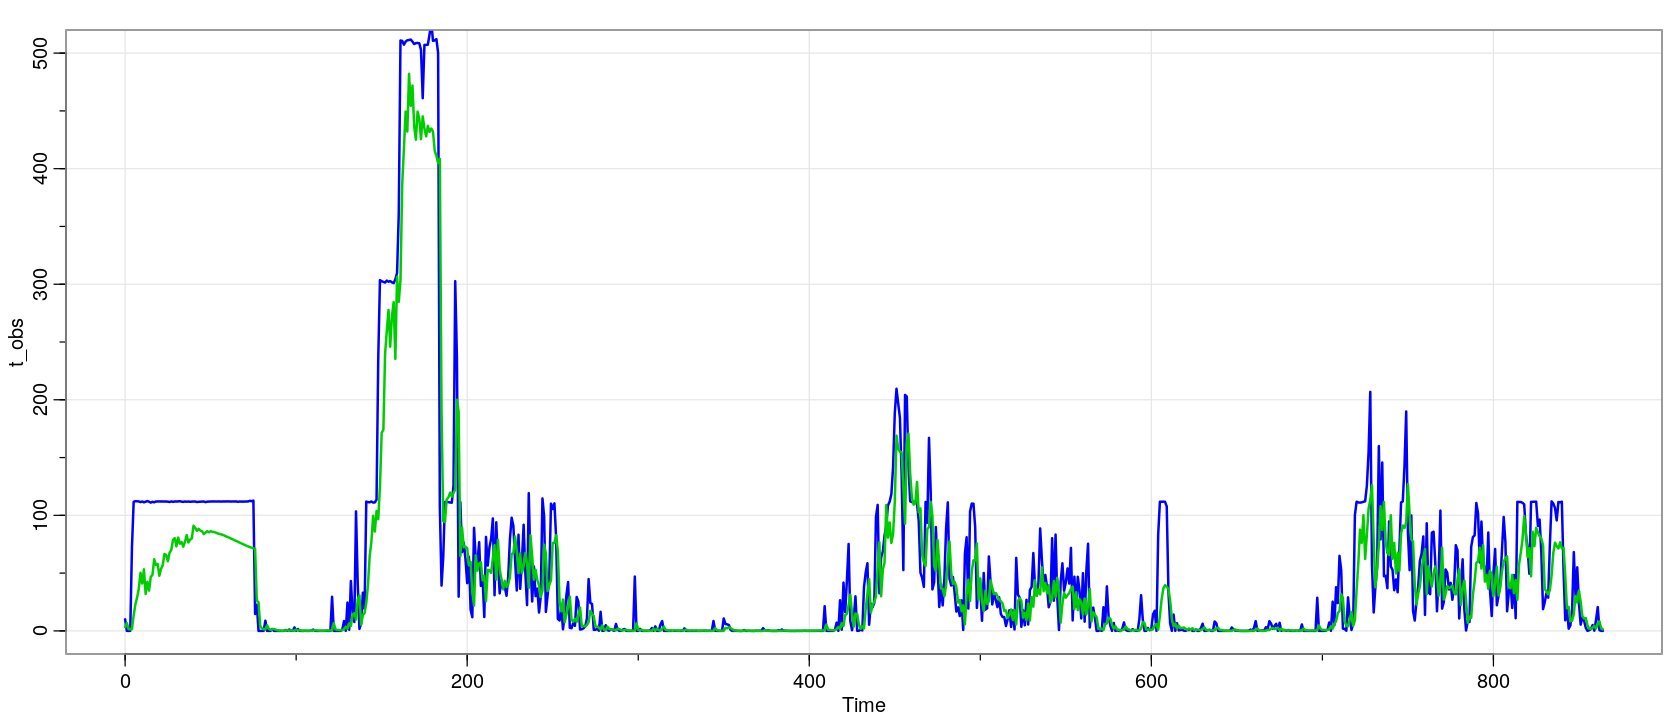

In [82]:
t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)